In [17]:
import random
import buildNetwork
import basicRunDORA
import pdb
import numpy as np
import seaborn as sns
NUM_ANALOGS = 4
N_COMPONENTS = 10
PER_ANALOG = 5
REPETITIONS = 10

In [21]:
parameters = {'asDORA': True, 'gamma': 0.3,
              'delta': 0.05, 'eta': 0.9,
              'HebbBias': 0.5,
              'bias_retrieval_analogs': False, 'use_relative_act': False, # Changeeeeddd!!!!!!!!
              #'run_order': ['cdr', 'selectTokens', 'r', 'wp', 'm', 'p', 's', 'f', 'c'],
              'run_order': ['cdr', 'selectTokens', 'r', 'm','c'],
              'run_cyles': 100, 'write_on_iteration': 100, 'firingOrderRule': 'in_order',
              'dim_list':[],
              'strategic_mapping': True, 'ignore_object_semantics': False,
              'ignore_memory_semantics': True, 'mag_decimal_precision': 0,
              'exemplar_memory': False, 'recent_analog_bias': True,
              'lateral_input_level': 1, 'screen_width': 1200, 'screen_height': 700,
              'doGUI': False, 'testing': True, 'GUI_update_rate': 50, 'starting_iteration': 0,
              'tokenize': False, 'ho_sem_act_flow': 0, 'remove_uncompressed': False, 'remove_compressed': False,
              'num_choose':10,'one_to_one':True,'max_norm':True, 'filename':'karthikeya/test_sim_custom-sg-7-empty_pred.py',
             'len_regularisation':1, 'count_by_RBs':False, 'parent_bias':0.1, 'order_activation_bias':0.5,
             'results':'karthikeya/data/results/sg.pkl'}

In [6]:
def init_network(parameters):
    reload(buildNetwork)
    reload(basicRunDORA)
    fileName = parameters['filename']
    f = open(fileName, 'r')
    simType = ''
    d = {'simType': simType}
    f.seek(0)
    exec (f.readline())
    if simType == 'sym_file':
        symstring = ''
        for line in f:
            symstring += line
        exec(symstring)
    # initialise memory
    memory = buildNetwork.initializeMemorySet()
    # interpret sym file
    mysym = buildNetwork.interpretSymfile(symProps)
    # build the network
    memory = basicRunDORA.dataTypes.memorySet()
    memory = buildNetwork.buildTheNetwork(mysym[0], memory)
    network = basicRunDORA.runDORA(memory, parameters)
    memory = basicRunDORA.update_memory_with_levels(memory)
    # run cycles
    # initialise mapping adjacency matrix:
    mapping_adj = np.zeros((len(network.memory.Ps), len(network.memory.Ps)))
    return [network, memory, mapping_adj]

In [7]:
def vis_mappings(mapping_mat, prop_names):
    sns_heatmap = sns.heatmap(mapping_mat, linewidth=0.5,xticklabels=prop_names, yticklabels=prop_names)
    fig = sns_heatmap.get_figure()
    return

In [8]:
def mapping_error(mapping_mat):
    # assuming an even split - NUM_ANALOGS * PER_ANALOG = number of analogs, number of propositions per analog
    # the mapping matrix is ordered by propositions, therefore every n%PER_ANALOG should be mapped together.
    # the mapping_mat is L1 normalised, and so the target matrix should contain values = 1.0/(NUM_ANALOGS - 1)
    target_mat = np.zeros(mapping_mat.shape)
    per_analog = mapping_mat.shape[0]/NUM_ANALOGS
    for row in range(target_mat.shape[0]):
        target_indices = [(idx*per_analog + row%per_analog) for idx in range(NUM_ANALOGS)] # fill the target mapping indices
        target_indices.pop(target_indices.index(row))
        target_mat[row,target_indices] = 1.0/(NUM_ANALOGS - 1)
    mapping_mat = mapping_mat * (target_mat > 0) # keep only diagonals for comparisons
    error_mat = (mapping_mat - target_mat)**2
    error_val = np.sqrt(np.mean(error_mat))
    return error_val

In [9]:
def get_metrics(mapping_mat):
    # mapping_mat contains the predicted mappings
    target_mat = np.zeros(mapping_mat.shape)
    per_analog = mapping_mat.shape[0]/NUM_ANALOGS
    for row in range(target_mat.shape[0]):
        target_indices = [(idx*per_analog + row%per_analog) for idx in range(NUM_ANALOGS)] # fill the target mapping indices
        target_indices.pop(target_indices.index(row))
        target_mat[row,target_indices] = 1
    # target_mat contains the true mappings in boolean values
    # Get True Positives (TP)
    true_positives = sum(sum(mapping_mat * target_mat))
    # False Positives (FP) 
    false_positives =  sum(np.sum(mapping_mat * abs(target_mat-1), axis=0))# gives all those non-zero mappings at the wrong place.
    # False Negatives (FN) giving zero mapping when it should actually be non zero
    false_negatives = sum(np.sum(mapping_mat * abs(target_mat-1), axis=1)) 
    precision = true_positives/(true_positives + false_positives)
    recall = true_positives/(true_positives + false_negatives) 
    f_score = (2 * precision * recall) / (precision + recall)
    rmse = mapping_error(mapping_mat)
    return precision, recall, f_score, rmse

In [ ]:
# networ, memory, mapping_adj = init_network()
for cycle in range(parameters['run_cyles']):
    print('\n\n************************* Cycle: ' + str(cycle+1))

    # clear driver and recipient
    network.memory = basicRunDORA.clearDriverSet(network.memory)
    network.memory = basicRunDORA.clearRecipientSet(network.memory)

    # put the randomly chosen proposition in the driver
    proposition = random.sample(network.memory.Ps,k=parameters['num_choose']) # currently three propositions
    if parameters['num_choose'] > 1:
        proposition_num = []
        for p in proposition:
            proposition_num.append(network.memory.Ps.index(p))
    else:
        proposition_num = network.memory.Ps.index(proposition)

    if parameters['num_choose'] > 1:
        for p_num in proposition_num:
            network.memory = basicRunDORA.add_tokens_to_set(network.memory, p_num, 'P', 'driver')
    else:
        network.memory = basicRunDORA.add_tokens_to_set(network.memory, proposition_num, 'P', 'driver')



    # make sure the driver and the recipient are set
    network.memory = basicRunDORA.findDriverRecipient(network.memory)
    network.do_map()

    # display ALL mappings
    #pdb.set_trace()
    for myP in network.memory.driver.Ps:
        for mapping in myP.mappingConnections:
            map_weight = mapping.weight
            if map_weight > 0:
                map_unit = mapping.recipientToken
                if mapping_adj[network.memory.Ps.index(myP), network.memory.Ps.index(map_unit)] < 0.1:
                    mapping_adj[network.memory.Ps.index(myP), network.memory.Ps.index(map_unit)] = map_weight
                else:
                    mapping_adj[network.memory.Ps.index(myP), network.memory.Ps.index(map_unit)] = (map_weight + 
                        mapping_adj[network.memory.Ps.index(myP), network.memory.Ps.index(map_unit)])/2.0 # DIRTY SOLUTION FOR NOW
            #print str(network.memory.Ps.index(myP)) + str(' -- ') + str(network.memory.Ps.index(map_unit)) + str(' : ') + str(map_weight)
    # display mappings
    print('\n\nMappings:\n')
    basicRunDORA.DORA_GUI.term_map_display(network.memory, only_Ps=True, only_max=False)

In [10]:
def print_map_connections(network):
    for myP in network.memory.driver.Ps:
        for mapping in myP.mappingConnections:
            print myP.name, mapping.recipientToken.name, mapping.weight

In [ ]:
simulated_data = {}
for repetition in range(REPETITIONS):
    network, memory, mapping_adj = init_network(parameters)
    precisions, recalls, fscores, rmses = [],[],[],[]
    for cycle in range(parameters['run_cyles']):
        print('\n\n************************* Cycle: ' + str(cycle+1))
        #pdb.set_trace()
        # clear driver and recipient
        network.memory = basicRunDORA.clearDriverSet(network.memory)
        network.memory = basicRunDORA.clearRecipientSet(network.memory)
        # choose random analog from memory
        analog = random.choice(network.memory.analogs) # currently only one analog
        # choose random propositions from memory

        # put the analog in the driver
        analog_num = network.memory.analogs.index(analog)
        network.memory = basicRunDORA.add_tokens_to_set(network.memory, analog_num, 'analog', 'driver')
        # retrieve analogs similar to one in the driver from LTM
        network.memory = basicRunDORA.findDriverRecipient(network.memory)
        network.do_retrieval()
        network.memory = basicRunDORA.findDriverRecipient(network.memory)

        #print('In driver : ' + network.memory.driver.Ps[0].name[1])
        #if len(network.memory.recipient.Ps) > 0:
        #    print('In recipient : ' + network.memory.recipient.Ps[0].name[1])
        #    if network.memory.recipient.Ps[0].name[1] == '3':
        #        network.do_map()
        #        print('\n\nMappings:\n')
        #        basicRunDORA.DORA_GUI.term_map_display(network.memory, only_Ps=True, only_max=False)

        if len(network.memory.recipient.Ps) > 0: 
            print 'retrieval successful'
            # map the analogs in driver and recipient
            network.do_map()
            # display ALL mappings
            # display mappings
            print('\n\nMappings:\n')
            basicRunDORA.DORA_GUI.term_map_display(network.memory, only_Ps=False, only_max=False)
            # store all mappings : 
            for myP in network.memory.driver.Ps:
                for mapping in myP.mappingConnections:
                    map_weight = mapping.weight
                    map_unit = mapping.recipientToken
                    mapping_adj[network.memory.Ps.index(myP), network.memory.Ps.index(map_unit)] = map_weight
        # append rmse to list to keep track of RMSE evolution
        temp_mapping_adj  = mapping_adj
        for ind in range(temp_mapping_adj.shape[0]):
            if sum(temp_mapping_adj[ind,:]) > 0:
                temp_mapping_adj[ind,:] = temp_mapping_adj[ind,:]/sum(temp_mapping_adj[ind,:])    
        prec,rec,fsc,rmse = get_metrics(temp_mapping_adj)
        precisions.append(prec)
        recalls.append(rec)
        fscores.append(fsc)
        rmses.append(rmse)

    # normalise mappings
    for ind in range(mapping_adj.shape[0]):
        if sum(mapping_adj[ind,:]) > 0:
            mapping_adj[ind,:] = mapping_adj[ind,:]/sum(mapping_adj[ind,:])
    simulated_data[repetition] = [fscores,rmses,mapping_adj]



************************* Cycle: 1
retrieval successful


Mappings:

('P: P10 -- NONE -- mapping_weight=', 0.0)
('P: P11 -- NONE -- mapping_weight=', 0.0)
('P: P12 -- P32 -- mapping_weight=', 0.9891594318152123)
('P: P13.1 -- NONE -- mapping_weight=', 0.0)
('P: P13 -- NONE -- mapping_weight=', 0.0)
('P: P14.1 -- P37.1 -- mapping_weight=', 0.9678179061388235)
('P: P14 -- NONE -- mapping_weight=', 0.0)
('P: P15.1 -- NONE -- mapping_weight=', 0.0)
('P: P15.2 -- P26.1 -- mapping_weight=', 0.933265844131711)
('P: P15 -- NONE -- mapping_weight=', 0.0)
('P: P16.1 -- NONE -- mapping_weight=', 0.0)
('P: P16.2 -- P26.2 -- mapping_weight=', 0.15097179911186248)
('P: P16 -- P26 -- mapping_weight=', 1)
('P: P17.1 -- NONE -- mapping_weight=', 0.0)
('P: P17 -- P37 -- mapping_weight=', 1)
('RB: detlions -- NONE -- mapping_weight=', 0.0)
('RB: huntdeer -- NONE -- mapping_weight=', 0.0)
('RB: angrylions -- NONE -- mapping_weight=', 0.0)
('RB: roarobj -- NONE -- mapping_weight=', 0.0)
('RB: detdeer -- 

retrieval successful


Mappings:

('P: P20 -- P03.1 -- mapping_weight=', 0.9944153861008469)
('P: P21 -- P10 -- mapping_weight=', 0.3322102697734296)
('P: P22 -- NONE -- mapping_weight=', 0.0)
('P: P23.1 -- P23.1 -- mapping_weight=', 0.7144209929650919)
('P: P23 -- P03 -- mapping_weight=', 1)
('P: P24.1 -- NONE -- mapping_weight=', 0.0)
('P: P24 -- P04 -- mapping_weight=', 0.9372621694625622)
('P: P25.1 -- P04.1 -- mapping_weight=', 0.6490434963422654)
('P: P25.2 -- P36.1 -- mapping_weight=', 1)
('P: P25 -- NONE -- mapping_weight=', 0.0)
('P: P26.1 -- P26.1 -- mapping_weight=', 0.933265844131711)
('P: P26.2 -- P26.2 -- mapping_weight=', 0.15097179911186248)
('P: P26 -- P26 -- mapping_weight=', 1)
('P: P27.1 -- NONE -- mapping_weight=', 0.0)
('P: P27 -- NONE -- mapping_weight=', 0.0)
('RB: deteagles -- NONE -- mapping_weight=', 0.0)
('RB: eatworms -- bitecats -- mapping_weight=', 1)
('RB: majesticeagles -- NONE -- mapping_weight=', 0.0)
('RB: glideobj -- huntdeer -- mapping_weight=', 0.

retrieval successful


Mappings:

('P: P20 -- P03.1 -- mapping_weight=', 0.9944153861008469)
('P: P21 -- P10 -- mapping_weight=', 0.3322102697734296)
('P: P22 -- NONE -- mapping_weight=', 0.0)
('P: P23.1 -- P23.1 -- mapping_weight=', 0.7144209929650919)
('P: P23 -- P03 -- mapping_weight=', 1)
('P: P24.1 -- NONE -- mapping_weight=', 0.0)
('P: P24 -- P04 -- mapping_weight=', 0.9372621694625622)
('P: P25.1 -- P04.1 -- mapping_weight=', 0.6490434963422654)
('P: P25.2 -- P36.1 -- mapping_weight=', 1)
('P: P25 -- P25 -- mapping_weight=', 0.8584705711735733)
('P: P26.1 -- P26.1 -- mapping_weight=', 0.933265844131711)
('P: P26.2 -- P26.2 -- mapping_weight=', 0.15097179911186248)
('P: P26 -- P26 -- mapping_weight=', 1)
('P: P27.1 -- P07.1 -- mapping_weight=', 0.6623637892063012)
('P: P27 -- P07 -- mapping_weight=', 1)
('RB: deteagles -- NONE -- mapping_weight=', 0.0)
('RB: eatworms -- bitecats -- mapping_weight=', 1)
('RB: majesticeagles -- purrsoftly -- mapping_weight=', 0.24858267687874425)
(

retrieval successful


Mappings:

('P: P30 -- P12 -- mapping_weight=', 0.3472576150961666)
('P: P31 -- P13.1 -- mapping_weight=', 0.7696286825846562)
('P: P32 -- P32 -- mapping_weight=', 0.9891594318152123)
('P: P33.1 -- P23.1 -- mapping_weight=', 0.8285133951794384)
('P: P33 -- P23 -- mapping_weight=', 1)
('P: P34.1 -- P05.2 -- mapping_weight=', 0.9637674708395967)
('P: P34 -- P25 -- mapping_weight=', 0.6716233806316357)
('P: P35.1 -- P24.1 -- mapping_weight=', 0.015248619844576877)
('P: P35.2 -- P16.1 -- mapping_weight=', 0.4254279036152015)
('P: P35 -- NONE -- mapping_weight=', 0.0)
('P: P36.1 -- P36.1 -- mapping_weight=', 1)
('P: P36.2 -- NONE -- mapping_weight=', 0.0)
('P: P36 -- P26 -- mapping_weight=', 0.3564647491819028)
('P: P37.1 -- P37.1 -- mapping_weight=', 0.9678179061388235)
('P: P37 -- P37 -- mapping_weight=', 1)
('RB: detsnakes -- growlobj -- mapping_weight=', 0.03381611909230448)
('RB: eatrats -- NONE -- mapping_weight=', 0.0)
('RB: angrysnakes -- dullworms -- mapping_

retrieval successful


Mappings:

('P: P10 -- P10 -- mapping_weight=', 0.3322102697734296)
('P: P11 -- P01 -- mapping_weight=', 0.8110119521567611)
('P: P12 -- P32 -- mapping_weight=', 0.9891594318152123)
('P: P13.1 -- P13.1 -- mapping_weight=', 0.7696286825846562)
('P: P13 -- NONE -- mapping_weight=', 0.0)
('P: P14.1 -- P37.1 -- mapping_weight=', 0.9678179061388235)
('P: P14 -- P25 -- mapping_weight=', 0.8584705711735733)
('P: P15.1 -- P25.2 -- mapping_weight=', 0.02786625180464254)
('P: P15.2 -- P26.1 -- mapping_weight=', 0.933265844131711)
('P: P15 -- NONE -- mapping_weight=', 0.0)
('P: P16.1 -- P16.1 -- mapping_weight=', 0.4254279036152015)
('P: P16.2 -- P26.2 -- mapping_weight=', 0.15097179911186248)
('P: P16 -- P26 -- mapping_weight=', 1)
('P: P17.1 -- NONE -- mapping_weight=', 0.0)
('P: P17 -- P37 -- mapping_weight=', 1)
('RB: detlions -- thesky -- mapping_weight=', 0.03884602635900774)
('RB: huntdeer -- huntdeer -- mapping_weight=', 0.971924577435971)
('RB: angrylions -- hungry

retrieval successful


Mappings:

('P: P00 -- NONE -- mapping_weight=', 0.0)
('P: P01 -- P01 -- mapping_weight=', 0.8110119521567611)
('P: P02 -- P32 -- mapping_weight=', 0.9303895258383454)
('P: P03.1 -- P03.1 -- mapping_weight=', 0.9944153861008469)
('P: P03 -- P03 -- mapping_weight=', 1)
('P: P04.1 -- P04.1 -- mapping_weight=', 0.6490434963422654)
('P: P04 -- P04 -- mapping_weight=', 0.9372621694625622)
('P: P05.1 -- P27.1 -- mapping_weight=', 0.17428244649620817)
('P: P05.2 -- P05.2 -- mapping_weight=', 0.9637674708395967)
('P: P05 -- P05 -- mapping_weight=', 1)
('P: P06.1 -- NONE -- mapping_weight=', 0.0)
('P: P06.2 -- NONE -- mapping_weight=', 0.0)
('P: P06 -- NONE -- mapping_weight=', 0.0)
('P: P07.1 -- P07.1 -- mapping_weight=', 0.6623637892063012)
('P: P07 -- P07 -- mapping_weight=', 1)
('RB: detdogs -- detsnakes -- mapping_weight=', 0.0015831018469506784)
('RB: chasecats -- eatrats -- mapping_weight=', 0.2757942056465608)
('RB: hungrydogs -- hungrydogs -- mapping_weight=', 0.



************************* Cycle: 22
retrieval successful


Mappings:

('P: P10 -- P10 -- mapping_weight=', 0.3322102697734296)
('P: P11 -- P01 -- mapping_weight=', 0.8110119521567611)
('P: P12 -- P32 -- mapping_weight=', 0.9891594318152123)
('P: P13.1 -- P23.1 -- mapping_weight=', 0.9232376347877372)
('P: P13 -- P23 -- mapping_weight=', 1)
('P: P14.1 -- P37.1 -- mapping_weight=', 0.9678179061388235)
('P: P14 -- P25 -- mapping_weight=', 0.8584705711735733)
('P: P15.1 -- P25.2 -- mapping_weight=', 0.02786625180464254)
('P: P15.2 -- P26.1 -- mapping_weight=', 0.933265844131711)
('P: P15 -- NONE -- mapping_weight=', 0.0)
('P: P16.1 -- P16.1 -- mapping_weight=', 0.4254279036152015)
('P: P16.2 -- P26.2 -- mapping_weight=', 0.15097179911186248)
('P: P16 -- P26 -- mapping_weight=', 1)
('P: P17.1 -- NONE -- mapping_weight=', 0.0)
('P: P17 -- P37 -- mapping_weight=', 1)
('RB: detlions -- thesky -- mapping_weight=', 0.03884602635900774)
('RB: huntdeer -- huntdeer -- mapping_weight=', 0.97192457

retrieval successful


Mappings:

('P: P30 -- P12 -- mapping_weight=', 0.3472576150961666)
('P: P31 -- P13.1 -- mapping_weight=', 0.7696286825846562)
('P: P32 -- P32 -- mapping_weight=', 0.9891594318152123)
('P: P33.1 -- P23.1 -- mapping_weight=', 0.8285133951794384)
('P: P33 -- P23 -- mapping_weight=', 1)
('P: P34.1 -- P05.2 -- mapping_weight=', 0.9637674708395967)
('P: P34 -- P25 -- mapping_weight=', 0.6716233806316357)
('P: P35.1 -- P16.1 -- mapping_weight=', 0.06747737575009896)
('P: P35.2 -- P16.1 -- mapping_weight=', 0.4254279036152015)
('P: P35 -- P05 -- mapping_weight=', 1)
('P: P36.1 -- P36.1 -- mapping_weight=', 1)
('P: P36.2 -- NONE -- mapping_weight=', 0.0)
('P: P36 -- P16 -- mapping_weight=', 0.4074465721377213)
('P: P37.1 -- P37.1 -- mapping_weight=', 0.9678179061388235)
('P: P37 -- P37 -- mapping_weight=', 1)
('RB: detsnakes -- huntdeer -- mapping_weight=', 0.06318539805151152)
('RB: eatrats -- NONE -- mapping_weight=', 0.0)
('RB: angrysnakes -- dullworms -- mapping_weig

retrieval successful


Mappings:

('P: P20 -- P03.1 -- mapping_weight=', 0.9944153861008469)
('P: P21 -- P10 -- mapping_weight=', 0.3322102697734296)
('P: P22 -- NONE -- mapping_weight=', 0.0)
('P: P23.1 -- P23.1 -- mapping_weight=', 0.9232376347877372)
('P: P23 -- P03 -- mapping_weight=', 1)
('P: P24.1 -- P24.1 -- mapping_weight=', 0.015248619844576877)
('P: P24 -- P04 -- mapping_weight=', 0.9372621694625622)
('P: P25.1 -- P04.1 -- mapping_weight=', 0.6490434963422654)
('P: P25.2 -- P36.1 -- mapping_weight=', 1)
('P: P25 -- P25 -- mapping_weight=', 0.8584705711735733)
('P: P26.1 -- P26.1 -- mapping_weight=', 0.933265844131711)
('P: P26.2 -- P26.2 -- mapping_weight=', 0.15097179911186248)
('P: P26 -- P26 -- mapping_weight=', 1)
('P: P27.1 -- P07.1 -- mapping_weight=', 0.6623637892063012)
('P: P27 -- P07 -- mapping_weight=', 1)
('RB: deteagles -- deteagles -- mapping_weight=', 0.48660794798136486)
('RB: eatworms -- bitecats -- mapping_weight=', 1)
('RB: majesticeagles -- angrylions -- m

retrieval successful


Mappings:

('P: P10 -- P10 -- mapping_weight=', 0.3322102697734296)
('P: P11 -- P01 -- mapping_weight=', 0.8110119521567611)
('P: P12 -- P32 -- mapping_weight=', 0.9891594318152123)
('P: P13.1 -- P23.1 -- mapping_weight=', 0.9232376347877372)
('P: P13 -- P23 -- mapping_weight=', 1)
('P: P14.1 -- P37.1 -- mapping_weight=', 0.9678179061388235)
('P: P14 -- P25 -- mapping_weight=', 0.8584705711735733)
('P: P15.1 -- P25.2 -- mapping_weight=', 0.02786625180464254)
('P: P15.2 -- P26.1 -- mapping_weight=', 0.933265844131711)
('P: P15 -- NONE -- mapping_weight=', 0.0)
('P: P16.1 -- P16.1 -- mapping_weight=', 0.4254279036152015)
('P: P16.2 -- P26.2 -- mapping_weight=', 0.15097179911186248)
('P: P16 -- P26 -- mapping_weight=', 1)
('P: P17.1 -- NONE -- mapping_weight=', 0.0)
('P: P17 -- P37 -- mapping_weight=', 1)
('RB: detlions -- thesky -- mapping_weight=', 0.03884602635900774)
('RB: huntdeer -- huntdeer -- mapping_weight=', 0.971924577435971)
('RB: angrylions -- hungrydog

retrieval successful


Mappings:

('P: P30 -- P12 -- mapping_weight=', 0.3472576150961666)
('P: P31 -- P13.1 -- mapping_weight=', 0.7696286825846562)
('P: P32 -- P32 -- mapping_weight=', 0.9891594318152123)
('P: P33.1 -- P33.1 -- mapping_weight=', 0.8404657410991654)
('P: P33 -- P23 -- mapping_weight=', 1)
('P: P34.1 -- P05.2 -- mapping_weight=', 0.9637674708395967)
('P: P34 -- P25 -- mapping_weight=', 0.6716233806316357)
('P: P35.1 -- P16.1 -- mapping_weight=', 0.06747737575009896)
('P: P35.2 -- P16.1 -- mapping_weight=', 0.4254279036152015)
('P: P35 -- P05 -- mapping_weight=', 1)
('P: P36.1 -- P36.1 -- mapping_weight=', 1)
('P: P36.2 -- NONE -- mapping_weight=', 0.0)
('P: P36 -- P16 -- mapping_weight=', 0.4074465721377213)
('P: P37.1 -- P37.1 -- mapping_weight=', 0.9678179061388235)
('P: P37 -- P37 -- mapping_weight=', 1)
('RB: detsnakes -- huntdeer -- mapping_weight=', 0.06361055186113858)
('RB: eatrats -- NONE -- mapping_weight=', 0.0)
('RB: angrysnakes -- dullworms -- mapping_weig

retrieval successful


Mappings:

('P: P00 -- P10 -- mapping_weight=', 0.25212207189075914)
('P: P01 -- P01 -- mapping_weight=', 0.8110119521567611)
('P: P02 -- P32 -- mapping_weight=', 0.9303895258383454)
('P: P03.1 -- P03.1 -- mapping_weight=', 0.9944153861008469)
('P: P03 -- P03 -- mapping_weight=', 1)
('P: P04.1 -- P04.1 -- mapping_weight=', 0.6490434963422654)
('P: P04 -- P04 -- mapping_weight=', 0.9372621694625622)
('P: P05.1 -- P27.1 -- mapping_weight=', 0.17428244649620817)
('P: P05.2 -- P05.2 -- mapping_weight=', 0.9637674708395967)
('P: P05 -- P05 -- mapping_weight=', 1)
('P: P06.1 -- P06.1 -- mapping_weight=', 0.03240603576547595)
('P: P06.2 -- NONE -- mapping_weight=', 0.0)
('P: P06 -- NONE -- mapping_weight=', 0.0)
('P: P07.1 -- P07.1 -- mapping_weight=', 0.6623637892063012)
('P: P07 -- P07 -- mapping_weight=', 1)
('RB: detdogs -- wanderaimlessly -- mapping_weight=', 0.02731008371240847)
('RB: chasecats -- majesticeagles -- mapping_weight=', 0.5648794573268873)
('RB: hungr



************************* Cycle: 43
retrieval successful


Mappings:

('P: P20 -- P03.1 -- mapping_weight=', 0.9944153861008469)
('P: P21 -- P10 -- mapping_weight=', 0.3322102697734296)
('P: P22 -- P22 -- mapping_weight=', 0.37446500811689004)
('P: P23.1 -- P23.1 -- mapping_weight=', 0.9232376347877372)
('P: P23 -- P03 -- mapping_weight=', 1)
('P: P24.1 -- P24.1 -- mapping_weight=', 0.015248619844576877)
('P: P24 -- P04 -- mapping_weight=', 0.9372621694625622)
('P: P25.1 -- P04.1 -- mapping_weight=', 0.6490434963422654)
('P: P25.2 -- P36.1 -- mapping_weight=', 1)
('P: P25 -- P25 -- mapping_weight=', 0.8584705711735733)
('P: P26.1 -- P26.1 -- mapping_weight=', 0.933265844131711)
('P: P26.2 -- P26.2 -- mapping_weight=', 0.15097179911186248)
('P: P26 -- P26 -- mapping_weight=', 1)
('P: P27.1 -- P07.1 -- mapping_weight=', 0.6623637892063012)
('P: P27 -- P07 -- mapping_weight=', 1)
('RB: deteagles -- deteagles -- mapping_weight=', 0.48660794798136486)
('RB: eatworms -- bitecats -- mapping

retrieval successful


Mappings:

('P: P10 -- P22 -- mapping_weight=', 0.37446500811689004)
('P: P11 -- P01 -- mapping_weight=', 0.8110119521567611)
('P: P12 -- P32 -- mapping_weight=', 0.9891594318152123)
('P: P13.1 -- P23.1 -- mapping_weight=', 0.9232376347877372)
('P: P13 -- P23 -- mapping_weight=', 1)
('P: P14.1 -- P37.1 -- mapping_weight=', 0.9678179061388235)
('P: P14 -- P25 -- mapping_weight=', 0.8584705711735733)
('P: P15.1 -- P34.1 -- mapping_weight=', 0.036755102392808554)
('P: P15.2 -- P26.1 -- mapping_weight=', 0.933265844131711)
('P: P15 -- NONE -- mapping_weight=', 0.0)
('P: P16.1 -- P16.1 -- mapping_weight=', 0.4254279036152015)
('P: P16.2 -- P26.2 -- mapping_weight=', 0.15097179911186248)
('P: P16 -- P26 -- mapping_weight=', 1)
('P: P17.1 -- NONE -- mapping_weight=', 0.0)
('P: P17 -- P37 -- mapping_weight=', 1)
('RB: detlions -- thesky -- mapping_weight=', 0.03884602635900774)
('RB: huntdeer -- huntdeer -- mapping_weight=', 0.971924577435971)
('RB: angrylions -- hungryd



************************* Cycle: 50
retrieval successful


Mappings:

('P: P20 -- P03.1 -- mapping_weight=', 0.9944153861008469)
('P: P21 -- P31 -- mapping_weight=', 0.5598185456285127)
('P: P22 -- P22 -- mapping_weight=', 0.37446500811689004)
('P: P23.1 -- P23.1 -- mapping_weight=', 0.9232376347877372)
('P: P23 -- P03 -- mapping_weight=', 1)
('P: P24.1 -- P24.1 -- mapping_weight=', 0.015248619844576877)
('P: P24 -- P04 -- mapping_weight=', 0.9372621694625622)
('P: P25.1 -- P04.1 -- mapping_weight=', 0.6490434963422654)
('P: P25.2 -- P36.1 -- mapping_weight=', 1)
('P: P25 -- P25 -- mapping_weight=', 0.8584705711735733)
('P: P26.1 -- P26.1 -- mapping_weight=', 0.933265844131711)
('P: P26.2 -- P26.2 -- mapping_weight=', 0.15097179911186248)
('P: P26 -- P26 -- mapping_weight=', 1)
('P: P27.1 -- P07.1 -- mapping_weight=', 0.6623637892063012)
('P: P27 -- P07 -- mapping_weight=', 1)
('RB: deteagles -- deteagles -- mapping_weight=', 0.48660794798136486)
('RB: eatworms -- bitecats -- mapping

retrieval successful


Mappings:

('P: P10 -- P22 -- mapping_weight=', 0.37446500811689004)
('P: P11 -- P01 -- mapping_weight=', 0.8110119521567611)
('P: P12 -- P32 -- mapping_weight=', 0.9891594318152123)
('P: P13.1 -- P23.1 -- mapping_weight=', 0.9232376347877372)
('P: P13 -- P23 -- mapping_weight=', 1)
('P: P14.1 -- P37.1 -- mapping_weight=', 0.9678179061388235)
('P: P14 -- P25 -- mapping_weight=', 0.8584705711735733)
('P: P15.1 -- P34.1 -- mapping_weight=', 0.036755102392808554)
('P: P15.2 -- P26.1 -- mapping_weight=', 0.933265844131711)
('P: P15 -- NONE -- mapping_weight=', 0.0)
('P: P16.1 -- P16.1 -- mapping_weight=', 0.4254279036152015)
('P: P16.2 -- P26.2 -- mapping_weight=', 0.15097179911186248)
('P: P16 -- P26 -- mapping_weight=', 1)
('P: P17.1 -- NONE -- mapping_weight=', 0.0)
('P: P17 -- P37 -- mapping_weight=', 1)
('RB: detlions -- thesky -- mapping_weight=', 0.03884602635900774)
('RB: huntdeer -- huntdeer -- mapping_weight=', 0.971924577435971)
('RB: angrylions -- hungryd

retrieval successful


Mappings:

('P: P00 -- P32 -- mapping_weight=', 0.2529349872811857)
('P: P01 -- P01 -- mapping_weight=', 0.8110119521567611)
('P: P02 -- P32 -- mapping_weight=', 0.9303895258383454)
('P: P03.1 -- P03.1 -- mapping_weight=', 0.9944153861008469)
('P: P03 -- P03 -- mapping_weight=', 1)
('P: P04.1 -- P04.1 -- mapping_weight=', 0.6490434963422654)
('P: P04 -- P04 -- mapping_weight=', 0.9372621694625622)
('P: P05.1 -- P27.1 -- mapping_weight=', 0.17428244649620817)
('P: P05.2 -- P05.2 -- mapping_weight=', 0.9637674708395967)
('P: P05 -- P05 -- mapping_weight=', 1)
('P: P06.1 -- P06.1 -- mapping_weight=', 0.03240603576547595)
('P: P06.2 -- NONE -- mapping_weight=', 0.0)
('P: P06 -- P16 -- mapping_weight=', 0.2707703891195003)
('P: P07.1 -- P07.1 -- mapping_weight=', 0.6623637892063012)
('P: P07 -- P07 -- mapping_weight=', 1)
('RB: detdogs -- wanderaimlessly -- mapping_weight=', 0.02731008371240847)
('RB: chasecats -- majesticeagles -- mapping_weight=', 0.5648794573268873

retrieval successful


Mappings:

('P: P10 -- P22 -- mapping_weight=', 0.37446500811689004)
('P: P11 -- P01 -- mapping_weight=', 0.8110119521567611)
('P: P12 -- P32 -- mapping_weight=', 0.9891594318152123)
('P: P13.1 -- P23.1 -- mapping_weight=', 0.9232376347877372)
('P: P13 -- P23 -- mapping_weight=', 1)
('P: P14.1 -- P37.1 -- mapping_weight=', 0.9678179061388235)
('P: P14 -- P25 -- mapping_weight=', 0.8584705711735733)
('P: P15.1 -- P24.1 -- mapping_weight=', 0.0611304075031239)
('P: P15.2 -- P26.1 -- mapping_weight=', 0.933265844131711)
('P: P15 -- NONE -- mapping_weight=', 0.0)
('P: P16.1 -- P16.1 -- mapping_weight=', 0.4254279036152015)
('P: P16.2 -- P26.2 -- mapping_weight=', 0.15097179911186248)
('P: P16 -- P26 -- mapping_weight=', 1)
('P: P17.1 -- NONE -- mapping_weight=', 0.0)
('P: P17 -- P37 -- mapping_weight=', 1)
('RB: detlions -- thesky -- mapping_weight=', 0.03884602635900774)
('RB: huntdeer -- huntdeer -- mapping_weight=', 0.971924577435971)
('RB: angrylions -- hungrydog

retrieval successful


Mappings:

('P: P10 -- P22 -- mapping_weight=', 0.37446500811689004)
('P: P11 -- P01 -- mapping_weight=', 0.8110119521567611)
('P: P12 -- P32 -- mapping_weight=', 0.9891594318152123)
('P: P13.1 -- P23.1 -- mapping_weight=', 0.9578214537114453)
('P: P13 -- P23 -- mapping_weight=', 1)
('P: P14.1 -- P37.1 -- mapping_weight=', 0.9678179061388235)
('P: P14 -- P25 -- mapping_weight=', 0.8584705711735733)
('P: P15.1 -- P24.1 -- mapping_weight=', 0.0611304075031239)
('P: P15.2 -- P26.1 -- mapping_weight=', 0.933265844131711)
('P: P15 -- NONE -- mapping_weight=', 0.0)
('P: P16.1 -- P16.1 -- mapping_weight=', 0.4254279036152015)
('P: P16.2 -- P26.2 -- mapping_weight=', 0.15097179911186248)
('P: P16 -- P26 -- mapping_weight=', 1)
('P: P17.1 -- NONE -- mapping_weight=', 0.0)
('P: P17 -- P37 -- mapping_weight=', 1)
('RB: detlions -- thesky -- mapping_weight=', 0.03884602635900774)
('RB: huntdeer -- huntdeer -- mapping_weight=', 0.971924577435971)
('RB: angrylions -- hungrydog

retrieval successful


Mappings:

('P: P30 -- P12 -- mapping_weight=', 0.3472576150961666)
('P: P31 -- P13.1 -- mapping_weight=', 0.7696286825846562)
('P: P32 -- P32 -- mapping_weight=', 0.9891594318152123)
('P: P33.1 -- P33.1 -- mapping_weight=', 0.8404657410991654)
('P: P33 -- P23 -- mapping_weight=', 1)
('P: P34.1 -- P05.2 -- mapping_weight=', 0.9637674708395967)
('P: P34 -- P25 -- mapping_weight=', 0.7385732994622245)
('P: P35.1 -- P25.1 -- mapping_weight=', 0.0929955006379625)
('P: P35.2 -- P16.1 -- mapping_weight=', 0.4254279036152015)
('P: P35 -- P05 -- mapping_weight=', 1)
('P: P36.1 -- P36.1 -- mapping_weight=', 1)
('P: P36.2 -- NONE -- mapping_weight=', 0.0)
('P: P36 -- P16 -- mapping_weight=', 0.4074465721377213)
('P: P37.1 -- P37.1 -- mapping_weight=', 0.9678179061388235)
('P: P37 -- P37 -- mapping_weight=', 1)
('RB: detsnakes -- detsnakes -- mapping_weight=', 0.7426780478177294)
('RB: eatrats -- NONE -- mapping_weight=', 0.0)
('RB: angrysnakes -- dullworms -- mapping_weigh

retrieval successful


Mappings:

('P: P30 -- P12 -- mapping_weight=', 0.3472576150961666)
('P: P31 -- P13.1 -- mapping_weight=', 0.7696286825846562)
('P: P32 -- P32 -- mapping_weight=', 0.9891594318152123)
('P: P33.1 -- P33.1 -- mapping_weight=', 0.8404657410991654)
('P: P33 -- P23 -- mapping_weight=', 1)
('P: P34.1 -- P05.2 -- mapping_weight=', 0.9637674708395967)
('P: P34 -- P25 -- mapping_weight=', 0.7385732994622245)
('P: P35.1 -- P25.1 -- mapping_weight=', 0.0929955006379625)
('P: P35.2 -- P16.1 -- mapping_weight=', 0.4254279036152015)
('P: P35 -- P05 -- mapping_weight=', 1)
('P: P36.1 -- P36.1 -- mapping_weight=', 1)
('P: P36.2 -- NONE -- mapping_weight=', 0.0)
('P: P36 -- P16 -- mapping_weight=', 0.4074465721377213)
('P: P37.1 -- P37.1 -- mapping_weight=', 0.9678179061388235)
('P: P37 -- P37 -- mapping_weight=', 1)
('RB: detsnakes -- detsnakes -- mapping_weight=', 0.7426780478177294)
('RB: eatrats -- NONE -- mapping_weight=', 0.0)
('RB: angrysnakes -- dullworms -- mapping_weigh

retrieval successful


Mappings:

('P: P00 -- P00 -- mapping_weight=', 0.3093568738552934)
('P: P01 -- P01 -- mapping_weight=', 0.8110119521567611)
('P: P02 -- P32 -- mapping_weight=', 0.9303895258383454)
('P: P03.1 -- P03.1 -- mapping_weight=', 0.9944153861008469)
('P: P03 -- P03 -- mapping_weight=', 1)
('P: P04.1 -- P04.1 -- mapping_weight=', 0.6490434963422654)
('P: P04 -- P04 -- mapping_weight=', 0.9372621694625622)
('P: P05.1 -- P27.1 -- mapping_weight=', 0.17428244649620817)
('P: P05.2 -- P05.2 -- mapping_weight=', 0.9637674708395967)
('P: P05 -- P05 -- mapping_weight=', 1)
('P: P06.1 -- P06.1 -- mapping_weight=', 0.03240603576547595)
('P: P06.2 -- NONE -- mapping_weight=', 0.0)
('P: P06 -- P06 -- mapping_weight=', 0.34486233915405917)
('P: P07.1 -- P07.1 -- mapping_weight=', 0.6623637892063012)
('P: P07 -- P07 -- mapping_weight=', 1)
('RB: detdogs -- detdogs -- mapping_weight=', 1)
('RB: chasecats -- majesticeagles -- mapping_weight=', 0.5648794573268873)
('RB: hungrydogs -- hun

retrieval successful


Mappings:

('P: P10 -- P22 -- mapping_weight=', 0.37446500811689004)
('P: P11 -- P01 -- mapping_weight=', 0.8110119521567611)
('P: P12 -- P32 -- mapping_weight=', 0.9891594318152123)
('P: P13.1 -- P23.1 -- mapping_weight=', 0.9578214537114453)
('P: P13 -- P23 -- mapping_weight=', 1)
('P: P14.1 -- P37.1 -- mapping_weight=', 0.9678179061388235)
('P: P14 -- P25 -- mapping_weight=', 0.8584705711735733)
('P: P15.1 -- P05.1 -- mapping_weight=', 0.06560830665247688)
('P: P15.2 -- P26.1 -- mapping_weight=', 0.933265844131711)
('P: P15 -- P15 -- mapping_weight=', 0.7435177238642897)
('P: P16.1 -- P16.1 -- mapping_weight=', 0.4254279036152015)
('P: P16.2 -- P26.2 -- mapping_weight=', 0.15097179911186248)
('P: P16 -- P26 -- mapping_weight=', 1)
('P: P17.1 -- NONE -- mapping_weight=', 0.0)
('P: P17 -- P37 -- mapping_weight=', 1)
('RB: detlions -- thesky -- mapping_weight=', 0.03884602635900774)
('RB: huntdeer -- huntdeer -- mapping_weight=', 0.971924577435971)
('RB: angrylio

retrieval successful


Mappings:

('P: P00 -- P00 -- mapping_weight=', 0.3093568738552934)
('P: P01 -- P01 -- mapping_weight=', 0.8110119521567611)
('P: P02 -- P32 -- mapping_weight=', 0.9303895258383454)
('P: P03.1 -- P03.1 -- mapping_weight=', 0.9944153861008469)
('P: P03 -- P03 -- mapping_weight=', 1)
('P: P04.1 -- P04.1 -- mapping_weight=', 0.6490434963422654)
('P: P04 -- P04 -- mapping_weight=', 0.9372621694625622)
('P: P05.1 -- P27.1 -- mapping_weight=', 0.17428244649620817)
('P: P05.2 -- P05.2 -- mapping_weight=', 0.9637674708395967)
('P: P05 -- P05 -- mapping_weight=', 1)
('P: P06.1 -- P06.1 -- mapping_weight=', 0.03240603576547595)
('P: P06.2 -- NONE -- mapping_weight=', 0.0)
('P: P06 -- P06 -- mapping_weight=', 0.34486233915405917)
('P: P07.1 -- P07.1 -- mapping_weight=', 0.6623637892063012)
('P: P07 -- P07 -- mapping_weight=', 1)
('RB: detdogs -- detdogs -- mapping_weight=', 1)
('RB: chasecats -- majesticeagles -- mapping_weight=', 0.5648794573268873)
('RB: hungrydogs -- hun

retrieval successful


Mappings:

('P: P10 -- P22 -- mapping_weight=', 0.37446500811689004)
('P: P11 -- P01 -- mapping_weight=', 0.8110119521567611)
('P: P12 -- P32 -- mapping_weight=', 0.9891594318152123)
('P: P13.1 -- P23.1 -- mapping_weight=', 0.9578214537114453)
('P: P13 -- P23 -- mapping_weight=', 1)
('P: P14.1 -- P37.1 -- mapping_weight=', 0.9678179061388235)
('P: P14 -- P25 -- mapping_weight=', 0.8584705711735733)
('P: P15.1 -- P05.1 -- mapping_weight=', 0.06560830665247688)
('P: P15.2 -- P26.1 -- mapping_weight=', 0.933265844131711)
('P: P15 -- P15 -- mapping_weight=', 0.7435177238642897)
('P: P16.1 -- P16.1 -- mapping_weight=', 0.4254279036152015)
('P: P16.2 -- P26.2 -- mapping_weight=', 0.15097179911186248)
('P: P16 -- P26 -- mapping_weight=', 1)
('P: P17.1 -- NONE -- mapping_weight=', 0.0)
('P: P17 -- P37 -- mapping_weight=', 1)
('RB: detlions -- thesky -- mapping_weight=', 0.03884602635900774)
('RB: huntdeer -- huntdeer -- mapping_weight=', 0.971924577435971)
('RB: angrylio



************************* Cycle: 87
retrieval successful


Mappings:

('P: P20 -- P03.1 -- mapping_weight=', 0.9944153861008469)
('P: P21 -- P31 -- mapping_weight=', 0.5598185456285127)
('P: P22 -- P22 -- mapping_weight=', 0.37446500811689004)
('P: P23.1 -- P23.1 -- mapping_weight=', 0.9578214537114453)
('P: P23 -- P03 -- mapping_weight=', 1)
('P: P24.1 -- P24.1 -- mapping_weight=', 0.0973482484275199)
('P: P24 -- P04 -- mapping_weight=', 0.9372621694625622)
('P: P25.1 -- P04.1 -- mapping_weight=', 0.6490434963422654)
('P: P25.2 -- P36.1 -- mapping_weight=', 1)
('P: P25 -- P25 -- mapping_weight=', 0.8584705711735733)
('P: P26.1 -- P26.1 -- mapping_weight=', 0.933265844131711)
('P: P26.2 -- P26.2 -- mapping_weight=', 0.15097179911186248)
('P: P26 -- P26 -- mapping_weight=', 1)
('P: P27.1 -- P07.1 -- mapping_weight=', 0.6623637892063012)
('P: P27 -- P07 -- mapping_weight=', 1)
('RB: deteagles -- deteagles -- mapping_weight=', 0.48660794798136486)
('RB: eatworms -- bitecats -- mapping_w

retrieval successful


Mappings:

('P: P00 -- P00 -- mapping_weight=', 0.3093568738552934)
('P: P01 -- P01 -- mapping_weight=', 0.8110119521567611)
('P: P02 -- P32 -- mapping_weight=', 0.9303895258383454)
('P: P03.1 -- P03.1 -- mapping_weight=', 0.9944153861008469)
('P: P03 -- P03 -- mapping_weight=', 1)
('P: P04.1 -- P04.1 -- mapping_weight=', 0.6490434963422654)
('P: P04 -- P04 -- mapping_weight=', 0.9372621694625622)
('P: P05.1 -- P27.1 -- mapping_weight=', 0.17428244649620817)
('P: P05.2 -- P05.2 -- mapping_weight=', 0.9637674708395967)
('P: P05 -- P05 -- mapping_weight=', 1)
('P: P06.1 -- P06.1 -- mapping_weight=', 0.03240603576547595)
('P: P06.2 -- NONE -- mapping_weight=', 0.0)
('P: P06 -- P36 -- mapping_weight=', 0.6422494513393325)
('P: P07.1 -- P07.1 -- mapping_weight=', 0.6623637892063012)
('P: P07 -- P07 -- mapping_weight=', 1)
('RB: detdogs -- detdogs -- mapping_weight=', 1)
('RB: chasecats -- majesticeagles -- mapping_weight=', 0.5648794573268873)
('RB: hungrydogs -- hung

retrieval successful


Mappings:

('P: P20 -- P03.1 -- mapping_weight=', 0.9944153861008469)
('P: P21 -- P31 -- mapping_weight=', 0.5598185456285127)
('P: P22 -- P22 -- mapping_weight=', 0.37446500811689004)
('P: P23.1 -- P23.1 -- mapping_weight=', 0.9578214537114453)
('P: P23 -- P03 -- mapping_weight=', 1)
('P: P24.1 -- P24.1 -- mapping_weight=', 0.0973482484275199)
('P: P24 -- P04 -- mapping_weight=', 0.9372621694625622)
('P: P25.1 -- P04.1 -- mapping_weight=', 0.6490434963422654)
('P: P25.2 -- P36.1 -- mapping_weight=', 1)
('P: P25 -- P25 -- mapping_weight=', 0.8584705711735733)
('P: P26.1 -- P26.1 -- mapping_weight=', 0.933265844131711)
('P: P26.2 -- P26.2 -- mapping_weight=', 0.15097179911186248)
('P: P26 -- P26 -- mapping_weight=', 1)
('P: P27.1 -- P07.1 -- mapping_weight=', 0.6623637892063012)
('P: P27 -- P07 -- mapping_weight=', 1)
('RB: deteagles -- deteagles -- mapping_weight=', 0.48660794798136486)
('RB: eatworms -- bitecats -- mapping_weight=', 1)
('RB: majesticeagles -- ma

retrieval successful


Mappings:

('P: P30 -- P12 -- mapping_weight=', 0.3472576150961666)
('P: P31 -- P13.1 -- mapping_weight=', 0.7696286825846562)
('P: P32 -- P32 -- mapping_weight=', 0.9891594318152123)
('P: P33.1 -- P33.1 -- mapping_weight=', 0.8404657410991654)
('P: P33 -- P23 -- mapping_weight=', 1)
('P: P34.1 -- P05.2 -- mapping_weight=', 0.9637674708395967)
('P: P34 -- P25 -- mapping_weight=', 0.7385732994622245)
('P: P35.1 -- P25.1 -- mapping_weight=', 0.0929955006379625)
('P: P35.2 -- P16.1 -- mapping_weight=', 0.4254279036152015)
('P: P35 -- P05 -- mapping_weight=', 1)
('P: P36.1 -- P36.1 -- mapping_weight=', 1)
('P: P36.2 -- NONE -- mapping_weight=', 0.0)
('P: P36 -- P36 -- mapping_weight=', 0.6422494513393325)
('P: P37.1 -- P37.1 -- mapping_weight=', 0.9678179061388235)
('P: P37 -- P37 -- mapping_weight=', 1)
('RB: detsnakes -- detsnakes -- mapping_weight=', 0.7426780478177294)
('RB: eatrats -- NONE -- mapping_weight=', 0.0)
('RB: angrysnakes -- dullworms -- mapping_weigh

retrieval successful


Mappings:

('P: P10 -- P22 -- mapping_weight=', 0.37446500811689004)
('P: P11 -- P01 -- mapping_weight=', 0.8110119521567611)
('P: P12 -- P32 -- mapping_weight=', 0.9891594318152123)
('P: P13.1 -- P23.1 -- mapping_weight=', 0.9578214537114453)
('P: P13 -- P23 -- mapping_weight=', 1)
('P: P14.1 -- P37.1 -- mapping_weight=', 0.9678179061388235)
('P: P14 -- P25 -- mapping_weight=', 0.8584705711735733)
('P: P15.1 -- P05.1 -- mapping_weight=', 0.06560830665247688)
('P: P15.2 -- P26.1 -- mapping_weight=', 0.933265844131711)
('P: P15 -- P15 -- mapping_weight=', 0.7435177238642897)
('P: P16.1 -- P16.1 -- mapping_weight=', 0.4254279036152015)
('P: P16.2 -- P26.2 -- mapping_weight=', 0.15097179911186248)
('P: P16 -- P26 -- mapping_weight=', 1)
('P: P17.1 -- NONE -- mapping_weight=', 0.0)
('P: P17 -- P37 -- mapping_weight=', 1)
('RB: detlions -- thesky -- mapping_weight=', 0.03884602635900774)
('RB: huntdeer -- huntdeer -- mapping_weight=', 0.971924577435971)
('RB: angrylio

C:\Users\karkau\AppData\Local\Continuum\anaconda2\envs\Dora\lib\site-packages\ipykernel_launcher.py:18: RuntimeWarning: invalid value encountered in double_scalars


retrieval successful


Mappings:

('P: P30 -- NONE -- mapping_weight=', 0.0)
('P: P31 -- NONE -- mapping_weight=', 0.0)
('P: P32 -- NONE -- mapping_weight=', 0.0)
('P: P33.1 -- NONE -- mapping_weight=', 0.0)
('P: P33 -- NONE -- mapping_weight=', 0.0)
('P: P34.1 -- P04.1 -- mapping_weight=', 0.1089035298574734)
('P: P34 -- NONE -- mapping_weight=', 0.0)
('P: P35.1 -- P04.1 -- mapping_weight=', 0.2285419199827097)
('P: P35.2 -- NONE -- mapping_weight=', 0.0)
('P: P35 -- NONE -- mapping_weight=', 0.0)
('P: P36.1 -- P05.2 -- mapping_weight=', 1)
('P: P36.2 -- P06.2 -- mapping_weight=', 0.5441583768165125)
('P: P36 -- P06 -- mapping_weight=', 0.944877335061268)
('P: P37.1 -- NONE -- mapping_weight=', 0.0)
('P: P37 -- NONE -- mapping_weight=', 0.0)
('RB: detsnakes -- detkitten -- mapping_weight=', 0.006626745869036817)
('RB: eatrats -- NONE -- mapping_weight=', 0.0)
('RB: angrysnakes -- fromwater -- mapping_weight=', 0.8129289034768175)
('RB: hissobj -- NONE -- mapping_weight=', 0.0)
('RB: d

retrieval successful


Mappings:

('P: P30 -- NONE -- mapping_weight=', 0.0)
('P: P31 -- NONE -- mapping_weight=', 0.0)
('P: P32 -- NONE -- mapping_weight=', 0.0)
('P: P33.1 -- P33.1 -- mapping_weight=', 0.8466282185469244)
('P: P33 -- P33 -- mapping_weight=', 1)
('P: P34.1 -- P04.1 -- mapping_weight=', 0.1089035298574734)
('P: P34 -- P25 -- mapping_weight=', 0.22120059171982231)
('P: P35.1 -- P04.1 -- mapping_weight=', 0.2285419199827097)
('P: P35.2 -- P25.1 -- mapping_weight=', 0.9315057950320963)
('P: P35 -- P25 -- mapping_weight=', 0.4605404471960947)
('P: P36.1 -- P05.2 -- mapping_weight=', 1)
('P: P36.2 -- P06.2 -- mapping_weight=', 0.5441583768165125)
('P: P36 -- P06 -- mapping_weight=', 0.944877335061268)
('P: P37.1 -- P37.1 -- mapping_weight=', 0.1382919816526743)
('P: P37 -- P37 -- mapping_weight=', 1)
('RB: detsnakes -- detkitten -- mapping_weight=', 0.006626745869036817)
('RB: eatrats -- NONE -- mapping_weight=', 0.0)
('RB: angrysnakes -- fromwater -- mapping_weight=', 0.81

retrieval successful


Mappings:

('P: P00 -- P22 -- mapping_weight=', 0.23985490139055626)
('P: P01 -- NONE -- mapping_weight=', 0.0)
('P: P02 -- NONE -- mapping_weight=', 0.0)
('P: P03.1 -- NONE -- mapping_weight=', 0.0)
('P: P03 -- NONE -- mapping_weight=', 0.0)
('P: P04.1 -- P04.1 -- mapping_weight=', 0.2285419199827097)
('P: P04 -- NONE -- mapping_weight=', 0.0)
('P: P05.1 -- P05.1 -- mapping_weight=', 0.9795943184265348)
('P: P05.2 -- P05.2 -- mapping_weight=', 1)
('P: P05 -- NONE -- mapping_weight=', 0.0)
('P: P06.1 -- NONE -- mapping_weight=', 0.0)
('P: P06.2 -- P06.2 -- mapping_weight=', 0.5441583768165125)
('P: P06 -- P06 -- mapping_weight=', 0.944877335061268)
('P: P07.1 -- P37.1 -- mapping_weight=', 0.1382919816526743)
('P: P07 -- P37 -- mapping_weight=', 1)
('RB: detdogs -- flyobj -- mapping_weight=', 0.02478512491103455)
('RB: chasecats -- NONE -- mapping_weight=', 0.0)
('RB: hungrydogs -- NONE -- mapping_weight=', 0.0)
('RB: barkobj -- dullworms -- mapping_weight=', 1)
(

retrieval successful


Mappings:

('P: P10 -- P10 -- mapping_weight=', 0.01358174198666114)
('P: P11 -- NONE -- mapping_weight=', 0.0)
('P: P12 -- P12 -- mapping_weight=', 1)
('P: P13.1 -- P23.1 -- mapping_weight=', 1)
('P: P13 -- NONE -- mapping_weight=', 0.0)
('P: P14.1 -- P05.1 -- mapping_weight=', 0.9795943184265348)
('P: P14 -- NONE -- mapping_weight=', 0.0)
('P: P15.1 -- P27.1 -- mapping_weight=', 0.05857142339231086)
('P: P15.2 -- P26.1 -- mapping_weight=', 0.8383278112239149)
('P: P15 -- P27 -- mapping_weight=', 0.7013794661568742)
('P: P16.1 -- P16.1 -- mapping_weight=', 0.9233332927504598)
('P: P16.2 -- NONE -- mapping_weight=', 0.0)
('P: P16 -- P26 -- mapping_weight=', 0.7992475874129188)
('P: P17.1 -- NONE -- mapping_weight=', 0.0)
('P: P17 -- NONE -- mapping_weight=', 0.0)
('RB: detlions -- NONE -- mapping_weight=', 0.0)
('RB: huntdeer -- huntdeer -- mapping_weight=', 0.028102219685319778)
('RB: angrylions -- angrylions -- mapping_weight=', 0.12092791444488375)
('RB: roaro

retrieval successful


Mappings:

('P: P00 -- P12 -- mapping_weight=', 1)
('P: P01 -- NONE -- mapping_weight=', 0.0)
('P: P02 -- P10 -- mapping_weight=', 0.01358174198666114)
('P: P03.1 -- P33.1 -- mapping_weight=', 0.7203231194246037)
('P: P03 -- NONE -- mapping_weight=', 0.0)
('P: P04.1 -- P04.1 -- mapping_weight=', 0.2285419199827097)
('P: P04 -- P37 -- mapping_weight=', 0.6536269656980963)
('P: P05.1 -- P05.1 -- mapping_weight=', 0.9795943184265348)
('P: P05.2 -- P05.2 -- mapping_weight=', 1)
('P: P05 -- NONE -- mapping_weight=', 0.0)
('P: P06.1 -- P06.1 -- mapping_weight=', 0.03653020456813522)
('P: P06.2 -- P06.2 -- mapping_weight=', 0.5441583768165125)
('P: P06 -- P06 -- mapping_weight=', 0.944877335061268)
('P: P07.1 -- P37.1 -- mapping_weight=', 0.1382919816526743)
('P: P07 -- P37 -- mapping_weight=', 1)
('RB: detdogs -- flyobj -- mapping_weight=', 0.0269628507290251)
('RB: chasecats -- jumpobj -- mapping_weight=', 0.8915676090627418)
('RB: hungrydogs -- NONE -- mapping_weight

retrieval successful


Mappings:

('P: P30 -- P02 -- mapping_weight=', 0.16510982226103488)
('P: P31 -- P01 -- mapping_weight=', 0.6316882894164924)
('P: P32 -- P32 -- mapping_weight=', 0.8203329370561543)
('P: P33.1 -- P33.1 -- mapping_weight=', 0.8466282185469244)
('P: P33 -- P33 -- mapping_weight=', 1)
('P: P34.1 -- P04.1 -- mapping_weight=', 0.12593671789101893)
('P: P34 -- P25 -- mapping_weight=', 0.22120059171982231)
('P: P35.1 -- P04.1 -- mapping_weight=', 0.2285419199827097)
('P: P35.2 -- P25.1 -- mapping_weight=', 0.9315057950320963)
('P: P35 -- P25 -- mapping_weight=', 0.4605404471960947)
('P: P36.1 -- P05.2 -- mapping_weight=', 1)
('P: P36.2 -- P06.2 -- mapping_weight=', 0.5441583768165125)
('P: P36 -- P06 -- mapping_weight=', 0.944877335061268)
('P: P37.1 -- P37.1 -- mapping_weight=', 0.1382919816526743)
('P: P37 -- P37 -- mapping_weight=', 1)
('RB: detsnakes -- detkitten -- mapping_weight=', 0.006626745869036817)
('RB: eatrats -- NONE -- mapping_weight=', 0.0)
('RB: angrys

retrieval successful


Mappings:

('P: P30 -- P10 -- mapping_weight=', 0.26164641265793404)
('P: P31 -- P01 -- mapping_weight=', 0.6316882894164924)
('P: P32 -- P32 -- mapping_weight=', 0.8203329370561543)
('P: P33.1 -- P33.1 -- mapping_weight=', 0.8466282185469244)
('P: P33 -- P33 -- mapping_weight=', 1)
('P: P34.1 -- P04.1 -- mapping_weight=', 0.12593671789101893)
('P: P34 -- P14 -- mapping_weight=', 0.6804949134400861)
('P: P35.1 -- P04.1 -- mapping_weight=', 0.2285419199827097)
('P: P35.2 -- P25.1 -- mapping_weight=', 0.9315057950320963)
('P: P35 -- P25 -- mapping_weight=', 0.4605404471960947)
('P: P36.1 -- P05.2 -- mapping_weight=', 1)
('P: P36.2 -- P06.2 -- mapping_weight=', 0.5441583768165125)
('P: P36 -- P06 -- mapping_weight=', 0.944877335061268)
('P: P37.1 -- P37.1 -- mapping_weight=', 0.1382919816526743)
('P: P37 -- P37 -- mapping_weight=', 1)
('RB: detsnakes -- detkitten -- mapping_weight=', 0.006626745869036817)
('RB: eatrats -- NONE -- mapping_weight=', 0.0)
('RB: angrysn

retrieval successful


Mappings:

('P: P10 -- P10 -- mapping_weight=', 0.32926025490441707)
('P: P11 -- P11 -- mapping_weight=', 0.5758880459685445)
('P: P12 -- P12 -- mapping_weight=', 1)
('P: P13.1 -- P23.1 -- mapping_weight=', 1)
('P: P13 -- P13 -- mapping_weight=', 1)
('P: P14.1 -- P05.1 -- mapping_weight=', 0.9795943184265348)
('P: P14 -- P14 -- mapping_weight=', 0.6804949134400861)
('P: P15.1 -- P15.1 -- mapping_weight=', 0.06464132358534234)
('P: P15.2 -- P26.1 -- mapping_weight=', 0.8383278112239149)
('P: P15 -- P27 -- mapping_weight=', 0.7013794661568742)
('P: P16.1 -- P16.1 -- mapping_weight=', 0.9233332927504598)
('P: P16.2 -- NONE -- mapping_weight=', 0.0)
('P: P16 -- P26 -- mapping_weight=', 0.7992475874129188)
('P: P17.1 -- P17.1 -- mapping_weight=', 0.12643196191388328)
('P: P17 -- P17 -- mapping_weight=', 0.7123905867111937)
('RB: detlions -- angrysnakes -- mapping_weight=', 0.04074280063295915)
('RB: huntdeer -- huntdeer -- mapping_weight=', 0.07942279279845478)
('RB: 

retrieval successful


Mappings:

('P: P20 -- P00 -- mapping_weight=', 0.26710654221434293)
('P: P21 -- P32 -- mapping_weight=', 0.8203329370561543)
('P: P22 -- P33.1 -- mapping_weight=', 0.8466282185469244)
('P: P23.1 -- P23.1 -- mapping_weight=', 1)
('P: P23 -- P33 -- mapping_weight=', 1)
('P: P24.1 -- P16.1 -- mapping_weight=', 0.9233332927504598)
('P: P24 -- P05 -- mapping_weight=', 0.012378170567798927)
('P: P25.1 -- P25.1 -- mapping_weight=', 0.9315057950320963)
('P: P25.2 -- P25.2 -- mapping_weight=', 0.09131148303274061)
('P: P25 -- P25 -- mapping_weight=', 0.4605404471960947)
('P: P26.1 -- P26.1 -- mapping_weight=', 0.8383278112239149)
('P: P26.2 -- NONE -- mapping_weight=', 0.0)
('P: P26 -- P26 -- mapping_weight=', 0.7992475874129188)
('P: P27.1 -- P27.1 -- mapping_weight=', 0.05857142339231086)
('P: P27 -- P27 -- mapping_weight=', 0.7013794661568742)
('RB: deteagles -- detsnakes -- mapping_weight=', 0.0009154858428214231)
('RB: eatworms -- malelions -- mapping_weight=', 0.91

retrieval successful


Mappings:

('P: P20 -- P00 -- mapping_weight=', 0.26710654221434293)
('P: P21 -- P32 -- mapping_weight=', 0.8203329370561543)
('P: P22 -- P33.1 -- mapping_weight=', 0.8466282185469244)
('P: P23.1 -- P23.1 -- mapping_weight=', 1)
('P: P23 -- P33 -- mapping_weight=', 1)
('P: P24.1 -- P16.1 -- mapping_weight=', 0.9233332927504598)
('P: P24 -- P37 -- mapping_weight=', 0.7043474637971069)
('P: P25.1 -- P25.1 -- mapping_weight=', 0.9315057950320963)
('P: P25.2 -- P25.2 -- mapping_weight=', 0.1150085073412144)
('P: P25 -- P25 -- mapping_weight=', 0.7020781761993393)
('P: P26.1 -- P26.1 -- mapping_weight=', 0.8383278112239149)
('P: P26.2 -- NONE -- mapping_weight=', 0.0)
('P: P26 -- P26 -- mapping_weight=', 0.7992475874129188)
('P: P27.1 -- P27.1 -- mapping_weight=', 0.05857142339231086)
('P: P27 -- P27 -- mapping_weight=', 0.7013794661568742)
('RB: deteagles -- scurryabout -- mapping_weight=', 0.05629676170450083)
('RB: eatworms -- malelions -- mapping_weight=', 0.91570

retrieval successful


Mappings:

('P: P00 -- P12 -- mapping_weight=', 1)
('P: P01 -- P01 -- mapping_weight=', 0.6316882894164924)
('P: P02 -- P02 -- mapping_weight=', 0.16510982226103488)
('P: P03.1 -- P03.1 -- mapping_weight=', 0.8815000268014959)
('P: P03 -- P03 -- mapping_weight=', 1)
('P: P04.1 -- P04.1 -- mapping_weight=', 0.2285419199827097)
('P: P04 -- P35 -- mapping_weight=', 0.7543938434777401)
('P: P05.1 -- P05.1 -- mapping_weight=', 0.9795943184265348)
('P: P05.2 -- P05.2 -- mapping_weight=', 1)
('P: P05 -- P05 -- mapping_weight=', 0.012378170567798927)
('P: P06.1 -- P06.1 -- mapping_weight=', 0.03653020456813522)
('P: P06.2 -- P06.2 -- mapping_weight=', 0.5441583768165125)
('P: P06 -- P06 -- mapping_weight=', 0.944877335061268)
('P: P07.1 -- P37.1 -- mapping_weight=', 0.1382919816526743)
('P: P07 -- P37 -- mapping_weight=', 1)
('RB: detdogs -- detdogs -- mapping_weight=', 0.39056888551362645)
('RB: chasecats -- jumpobj -- mapping_weight=', 0.8915676090627418)
('RB: hungryd

retrieval successful


Mappings:

('P: P20 -- P00 -- mapping_weight=', 0.28484869764890397)
('P: P21 -- P32 -- mapping_weight=', 0.8203329370561543)
('P: P22 -- P33.1 -- mapping_weight=', 0.8466282185469244)
('P: P23.1 -- P23.1 -- mapping_weight=', 1)
('P: P23 -- P33 -- mapping_weight=', 1)
('P: P24.1 -- P16.1 -- mapping_weight=', 0.9233332927504598)
('P: P24 -- P37 -- mapping_weight=', 0.7043474637971069)
('P: P25.1 -- P25.1 -- mapping_weight=', 0.9315057950320963)
('P: P25.2 -- P25.2 -- mapping_weight=', 0.1150085073412144)
('P: P25 -- P25 -- mapping_weight=', 0.7020781761993393)
('P: P26.1 -- P26.1 -- mapping_weight=', 0.8383278112239149)
('P: P26.2 -- NONE -- mapping_weight=', 0.0)
('P: P26 -- P26 -- mapping_weight=', 0.7992475874129188)
('P: P27.1 -- P27.1 -- mapping_weight=', 0.05857142339231086)
('P: P27 -- P27 -- mapping_weight=', 0.7013794661568742)
('RB: deteagles -- scurryabout -- mapping_weight=', 0.05629676170450083)
('RB: eatworms -- malelions -- mapping_weight=', 0.91570

retrieval successful


Mappings:

('P: P10 -- P10 -- mapping_weight=', 0.32926025490441707)
('P: P11 -- P11 -- mapping_weight=', 0.5758880459685445)
('P: P12 -- P12 -- mapping_weight=', 1)
('P: P13.1 -- P23.1 -- mapping_weight=', 1)
('P: P13 -- P13 -- mapping_weight=', 1)
('P: P14.1 -- P05.1 -- mapping_weight=', 0.9795943184265348)
('P: P14 -- P07 -- mapping_weight=', 0.6978531121630397)
('P: P15.1 -- P15.1 -- mapping_weight=', 0.06464132358534234)
('P: P15.2 -- P26.1 -- mapping_weight=', 0.8383278112239149)
('P: P15 -- P27 -- mapping_weight=', 0.7013794661568742)
('P: P16.1 -- P16.1 -- mapping_weight=', 0.9233332927504598)
('P: P16.2 -- NONE -- mapping_weight=', 0.0)
('P: P16 -- P26 -- mapping_weight=', 0.7992475874129188)
('P: P17.1 -- P17.1 -- mapping_weight=', 0.12643196191388328)
('P: P17 -- P17 -- mapping_weight=', 0.7123905867111937)
('RB: detlions -- growlobj -- mapping_weight=', 0.11206077938886197)
('RB: huntdeer -- huntdeer -- mapping_weight=', 0.07942279279845478)
('RB: ang

retrieval successful


Mappings:

('P: P10 -- P10 -- mapping_weight=', 0.32926025490441707)
('P: P11 -- P11 -- mapping_weight=', 0.5758880459685445)
('P: P12 -- P12 -- mapping_weight=', 1)
('P: P13.1 -- P23.1 -- mapping_weight=', 1)
('P: P13 -- P13 -- mapping_weight=', 1)
('P: P14.1 -- P05.1 -- mapping_weight=', 0.9795943184265348)
('P: P14 -- P07 -- mapping_weight=', 0.6978531121630397)
('P: P15.1 -- P15.1 -- mapping_weight=', 0.06464132358534234)
('P: P15.2 -- P26.1 -- mapping_weight=', 0.8383278112239149)
('P: P15 -- P27 -- mapping_weight=', 0.7013794661568742)
('P: P16.1 -- P16.1 -- mapping_weight=', 0.9233332927504598)
('P: P16.2 -- NONE -- mapping_weight=', 0.0)
('P: P16 -- P26 -- mapping_weight=', 0.7992475874129188)
('P: P17.1 -- P17.1 -- mapping_weight=', 0.12643196191388328)
('P: P17 -- P17 -- mapping_weight=', 0.7123905867111937)
('RB: detlions -- growlobj -- mapping_weight=', 0.11206077938886197)
('RB: huntdeer -- huntdeer -- mapping_weight=', 0.07942279279845478)
('RB: ang



************************* Cycle: 51


************************* Cycle: 52
retrieval successful


Mappings:

('P: P10 -- P10 -- mapping_weight=', 0.32926025490441707)
('P: P11 -- P11 -- mapping_weight=', 0.5758880459685445)
('P: P12 -- P12 -- mapping_weight=', 1)
('P: P13.1 -- P23.1 -- mapping_weight=', 1)
('P: P13 -- P13 -- mapping_weight=', 1)
('P: P14.1 -- P05.1 -- mapping_weight=', 0.9795943184265348)
('P: P14 -- P07 -- mapping_weight=', 0.6978531121630397)
('P: P15.1 -- P15.1 -- mapping_weight=', 0.06464132358534234)
('P: P15.2 -- P26.1 -- mapping_weight=', 0.8383278112239149)
('P: P15 -- P27 -- mapping_weight=', 0.7013794661568742)
('P: P16.1 -- P16.1 -- mapping_weight=', 0.9233332927504598)
('P: P16.2 -- NONE -- mapping_weight=', 0.0)
('P: P16 -- P26 -- mapping_weight=', 0.7992475874129188)
('P: P17.1 -- P17.1 -- mapping_weight=', 0.12643196191388328)
('P: P17 -- P17 -- mapping_weight=', 0.7123905867111937)
('RB: detlions -- growlobj -- mapping_weight=', 0.11206077938886197)
('

retrieval successful


Mappings:

('P: P20 -- P30 -- mapping_weight=', 0.31140122200418796)
('P: P21 -- P32 -- mapping_weight=', 0.8203329370561543)
('P: P22 -- P33.1 -- mapping_weight=', 0.8466282185469244)
('P: P23.1 -- P23.1 -- mapping_weight=', 1)
('P: P23 -- P33 -- mapping_weight=', 1)
('P: P24.1 -- P16.1 -- mapping_weight=', 0.9233332927504598)
('P: P24 -- P37 -- mapping_weight=', 0.7043474637971069)
('P: P25.1 -- P25.1 -- mapping_weight=', 0.9315057950320963)
('P: P25.2 -- P25.2 -- mapping_weight=', 0.1150085073412144)
('P: P25 -- P25 -- mapping_weight=', 0.7020781761993393)
('P: P26.1 -- P26.1 -- mapping_weight=', 0.8383278112239149)
('P: P26.2 -- NONE -- mapping_weight=', 0.0)
('P: P26 -- P26 -- mapping_weight=', 0.7992475874129188)
('P: P27.1 -- P27.1 -- mapping_weight=', 0.05857142339231086)
('P: P27 -- P27 -- mapping_weight=', 0.7013794661568742)
('RB: deteagles -- scurryabout -- mapping_weight=', 0.05629676170450083)
('RB: eatworms -- malelions -- mapping_weight=', 0.91570

retrieval successful


Mappings:

('P: P00 -- P12 -- mapping_weight=', 1)
('P: P01 -- P01 -- mapping_weight=', 0.6316882894164924)
('P: P02 -- P02 -- mapping_weight=', 0.16510982226103488)
('P: P03.1 -- P03.1 -- mapping_weight=', 0.8815000268014959)
('P: P03 -- P03 -- mapping_weight=', 1)
('P: P04.1 -- P04.1 -- mapping_weight=', 0.2285419199827097)
('P: P04 -- P17 -- mapping_weight=', 0.7909284806643806)
('P: P05.1 -- P05.1 -- mapping_weight=', 0.9795943184265348)
('P: P05.2 -- P05.2 -- mapping_weight=', 1)
('P: P05 -- P05 -- mapping_weight=', 0.7021954863052697)
('P: P06.1 -- P06.1 -- mapping_weight=', 0.08244956573818815)
('P: P06.2 -- P06.2 -- mapping_weight=', 0.5441583768165125)
('P: P06 -- P06 -- mapping_weight=', 0.944877335061268)
('P: P07.1 -- P37.1 -- mapping_weight=', 0.1382919816526743)
('P: P07 -- P37 -- mapping_weight=', 1)
('RB: detdogs -- detdogs -- mapping_weight=', 0.39056888551362645)
('RB: chasecats -- jumpobj -- mapping_weight=', 0.8915676090627418)
('RB: hungrydog

retrieval successful


Mappings:

('P: P20 -- P30 -- mapping_weight=', 0.31140122200418796)
('P: P21 -- P32 -- mapping_weight=', 0.8203329370561543)
('P: P22 -- P33.1 -- mapping_weight=', 0.8466282185469244)
('P: P23.1 -- P23.1 -- mapping_weight=', 1)
('P: P23 -- P33 -- mapping_weight=', 1)
('P: P24.1 -- P16.1 -- mapping_weight=', 0.9233332927504598)
('P: P24 -- P05 -- mapping_weight=', 0.7104702303417406)
('P: P25.1 -- P25.1 -- mapping_weight=', 0.9315057950320963)
('P: P25.2 -- P25.2 -- mapping_weight=', 0.1150085073412144)
('P: P25 -- P25 -- mapping_weight=', 0.7020781761993393)
('P: P26.1 -- P26.1 -- mapping_weight=', 0.8383278112239149)
('P: P26.2 -- NONE -- mapping_weight=', 0.0)
('P: P26 -- P26 -- mapping_weight=', 0.7992475874129188)
('P: P27.1 -- P27.1 -- mapping_weight=', 0.05857142339231086)
('P: P27 -- P27 -- mapping_weight=', 0.7013794661568742)
('RB: deteagles -- scurryabout -- mapping_weight=', 0.05629676170450083)
('RB: eatworms -- malelions -- mapping_weight=', 0.91570

retrieval successful


Mappings:

('P: P10 -- P10 -- mapping_weight=', 0.32926025490441707)
('P: P11 -- P11 -- mapping_weight=', 0.5758880459685445)
('P: P12 -- P12 -- mapping_weight=', 1)
('P: P13.1 -- P23.1 -- mapping_weight=', 1)
('P: P13 -- P13 -- mapping_weight=', 1)
('P: P14.1 -- P05.1 -- mapping_weight=', 0.9795943184265348)
('P: P14 -- P07 -- mapping_weight=', 0.6978531121630397)
('P: P15.1 -- P15.1 -- mapping_weight=', 0.06464132358534234)
('P: P15.2 -- P26.1 -- mapping_weight=', 0.8383278112239149)
('P: P15 -- P27 -- mapping_weight=', 0.7013794661568742)
('P: P16.1 -- P16.1 -- mapping_weight=', 0.9233332927504598)
('P: P16.2 -- NONE -- mapping_weight=', 0.0)
('P: P16 -- P26 -- mapping_weight=', 0.7992475874129188)
('P: P17.1 -- P17.1 -- mapping_weight=', 0.14245217991231077)
('P: P17 -- P17 -- mapping_weight=', 0.7909284806643806)
('RB: detlions -- growlobj -- mapping_weight=', 0.11206077938886197)
('RB: huntdeer -- huntdeer -- mapping_weight=', 0.07942279279845478)
('RB: ang

retrieval successful


Mappings:

('P: P30 -- P10 -- mapping_weight=', 0.32926025490441707)
('P: P31 -- P01 -- mapping_weight=', 0.6316882894164924)
('P: P32 -- P32 -- mapping_weight=', 0.8203329370561543)
('P: P33.1 -- P33.1 -- mapping_weight=', 0.8506888519110958)
('P: P33 -- P33 -- mapping_weight=', 1)
('P: P34.1 -- P04.1 -- mapping_weight=', 0.12593671789101893)
('P: P34 -- P04 -- mapping_weight=', 0.7450208204559611)
('P: P35.1 -- P04.1 -- mapping_weight=', 0.2285419199827097)
('P: P35.2 -- P25.1 -- mapping_weight=', 0.9315057950320963)
('P: P35 -- P35 -- mapping_weight=', 0.7543938434777401)
('P: P36.1 -- P05.2 -- mapping_weight=', 1)
('P: P36.2 -- P06.2 -- mapping_weight=', 0.5441583768165125)
('P: P36 -- P06 -- mapping_weight=', 0.944877335061268)
('P: P37.1 -- P37.1 -- mapping_weight=', 0.1382919816526743)
('P: P37 -- P37 -- mapping_weight=', 1)
('RB: detsnakes -- detsnakes -- mapping_weight=', 1)
('RB: eatrats -- eatrats -- mapping_weight=', 0.5485321640699448)
('RB: angrysna

retrieval successful


Mappings:

('P: P00 -- P12 -- mapping_weight=', 1)
('P: P01 -- P01 -- mapping_weight=', 0.6316882894164924)
('P: P02 -- P02 -- mapping_weight=', 0.39637456826311795)
('P: P03.1 -- P03.1 -- mapping_weight=', 0.8815000268014959)
('P: P03 -- P03 -- mapping_weight=', 1)
('P: P04.1 -- P04.1 -- mapping_weight=', 0.2285419199827097)
('P: P04 -- P17 -- mapping_weight=', 0.7909284806643806)
('P: P05.1 -- P05.1 -- mapping_weight=', 0.9795943184265348)
('P: P05.2 -- P05.2 -- mapping_weight=', 1)
('P: P05 -- P05 -- mapping_weight=', 0.7104702303417406)
('P: P06.1 -- P06.1 -- mapping_weight=', 0.08244956573818815)
('P: P06.2 -- P06.2 -- mapping_weight=', 0.5441583768165125)
('P: P06 -- P06 -- mapping_weight=', 0.944877335061268)
('P: P07.1 -- P37.1 -- mapping_weight=', 0.1382919816526743)
('P: P07 -- P37 -- mapping_weight=', 1)
('RB: detdogs -- detdogs -- mapping_weight=', 0.39056888551362645)
('RB: chasecats -- jumpobj -- mapping_weight=', 0.8915676090627418)
('RB: hungrydog

retrieval successful


Mappings:

('P: P20 -- P10 -- mapping_weight=', 0.37248796307570453)
('P: P21 -- P32 -- mapping_weight=', 0.8203329370561543)
('P: P22 -- P33.1 -- mapping_weight=', 0.8466282185469244)
('P: P23.1 -- P23.1 -- mapping_weight=', 1)
('P: P23 -- P33 -- mapping_weight=', 1)
('P: P24.1 -- P16.1 -- mapping_weight=', 0.9233332927504598)
('P: P24 -- P24 -- mapping_weight=', 0.7116993045618663)
('P: P25.1 -- P25.1 -- mapping_weight=', 0.9315057950320963)
('P: P25.2 -- P25.2 -- mapping_weight=', 0.1150085073412144)
('P: P25 -- P25 -- mapping_weight=', 0.7020781761993393)
('P: P26.1 -- P26.1 -- mapping_weight=', 0.8383278112239149)
('P: P26.2 -- NONE -- mapping_weight=', 0.0)
('P: P26 -- P26 -- mapping_weight=', 0.7992475874129188)
('P: P27.1 -- P27.1 -- mapping_weight=', 0.05857142339231086)
('P: P27 -- P27 -- mapping_weight=', 0.7013794661568742)
('RB: deteagles -- deteagles -- mapping_weight=', 0.09605853872563677)
('RB: eatworms -- malelions -- mapping_weight=', 0.9157029

retrieval successful


Mappings:

('P: P20 -- P10 -- mapping_weight=', 0.37248796307570453)
('P: P21 -- P32 -- mapping_weight=', 0.8203329370561543)
('P: P22 -- P33.1 -- mapping_weight=', 0.8466282185469244)
('P: P23.1 -- P23.1 -- mapping_weight=', 1)
('P: P23 -- P33 -- mapping_weight=', 1)
('P: P24.1 -- P16.1 -- mapping_weight=', 0.9233332927504598)
('P: P24 -- P24 -- mapping_weight=', 0.7116993045618663)
('P: P25.1 -- P25.1 -- mapping_weight=', 0.9315057950320963)
('P: P25.2 -- P25.2 -- mapping_weight=', 0.1150085073412144)
('P: P25 -- P25 -- mapping_weight=', 0.7020781761993393)
('P: P26.1 -- P26.1 -- mapping_weight=', 0.8383278112239149)
('P: P26.2 -- NONE -- mapping_weight=', 0.0)
('P: P26 -- P26 -- mapping_weight=', 0.7992475874129188)
('P: P27.1 -- P27.1 -- mapping_weight=', 0.05857142339231086)
('P: P27 -- P27 -- mapping_weight=', 0.7013794661568742)
('RB: deteagles -- deteagles -- mapping_weight=', 0.09605853872563677)
('RB: eatworms -- malelions -- mapping_weight=', 0.9157029

retrieval successful


Mappings:

('P: P30 -- P10 -- mapping_weight=', 0.32926025490441707)
('P: P31 -- P01 -- mapping_weight=', 0.6316882894164924)
('P: P32 -- P32 -- mapping_weight=', 0.8203329370561543)
('P: P33.1 -- P33.1 -- mapping_weight=', 0.8506888519110958)
('P: P33 -- P33 -- mapping_weight=', 1)
('P: P34.1 -- P04.1 -- mapping_weight=', 0.12593671789101893)
('P: P34 -- P34 -- mapping_weight=', 0.7476705883139141)
('P: P35.1 -- P04.1 -- mapping_weight=', 0.2285419199827097)
('P: P35.2 -- P25.1 -- mapping_weight=', 0.9315057950320963)
('P: P35 -- P35 -- mapping_weight=', 0.7543938434777401)
('P: P36.1 -- P05.2 -- mapping_weight=', 1)
('P: P36.2 -- P06.2 -- mapping_weight=', 0.5441583768165125)
('P: P36 -- P06 -- mapping_weight=', 0.944877335061268)
('P: P37.1 -- P37.1 -- mapping_weight=', 0.1382919816526743)
('P: P37 -- P37 -- mapping_weight=', 1)
('RB: detsnakes -- detsnakes -- mapping_weight=', 1)
('RB: eatrats -- eatrats -- mapping_weight=', 0.5485321640699448)
('RB: angrysna

retrieval successful


Mappings:

('P: P10 -- P02 -- mapping_weight=', 0.39637456826311795)
('P: P11 -- P11 -- mapping_weight=', 0.5758880459685445)
('P: P12 -- P12 -- mapping_weight=', 1)
('P: P13.1 -- P23.1 -- mapping_weight=', 1)
('P: P13 -- P13 -- mapping_weight=', 1)
('P: P14.1 -- P05.1 -- mapping_weight=', 0.9795943184265348)
('P: P14 -- P07 -- mapping_weight=', 0.6978531121630397)
('P: P15.1 -- P15.1 -- mapping_weight=', 0.06464132358534234)
('P: P15.2 -- P26.1 -- mapping_weight=', 0.8383278112239149)
('P: P15 -- P27 -- mapping_weight=', 0.7013794661568742)
('P: P16.1 -- P16.1 -- mapping_weight=', 0.9233332927504598)
('P: P16.2 -- NONE -- mapping_weight=', 0.0)
('P: P16 -- P26 -- mapping_weight=', 0.7992475874129188)
('P: P17.1 -- P17.1 -- mapping_weight=', 0.14245217991231077)
('P: P17 -- P17 -- mapping_weight=', 0.7909284806643806)
('RB: detlions -- detlions -- mapping_weight=', 1)
('RB: huntdeer -- huntdeer -- mapping_weight=', 0.7188169546672144)
('RB: angrylions -- bigdogs 

retrieval successful


Mappings:

('P: P20 -- P10 -- mapping_weight=', 0.37248796307570453)
('P: P21 -- P32 -- mapping_weight=', 0.8203329370561543)
('P: P22 -- P33.1 -- mapping_weight=', 0.8466282185469244)
('P: P23.1 -- P23.1 -- mapping_weight=', 1)
('P: P23 -- P33 -- mapping_weight=', 1)
('P: P24.1 -- P16.1 -- mapping_weight=', 0.9233332927504598)
('P: P24 -- P24 -- mapping_weight=', 0.7116993045618663)
('P: P25.1 -- P25.1 -- mapping_weight=', 0.9315057950320963)
('P: P25.2 -- P25.2 -- mapping_weight=', 0.1150085073412144)
('P: P25 -- P25 -- mapping_weight=', 0.7020781761993393)
('P: P26.1 -- P26.1 -- mapping_weight=', 0.8383278112239149)
('P: P26.2 -- NONE -- mapping_weight=', 0.0)
('P: P26 -- P26 -- mapping_weight=', 0.7992475874129188)
('P: P27.1 -- P27.1 -- mapping_weight=', 0.05857142339231086)
('P: P27 -- P27 -- mapping_weight=', 0.7013794661568742)
('RB: deteagles -- deteagles -- mapping_weight=', 0.09605853872563677)
('RB: eatworms -- malelions -- mapping_weight=', 0.9157029

retrieval successful


Mappings:

('P: P20 -- P10 -- mapping_weight=', 0.37248796307570453)
('P: P21 -- P32 -- mapping_weight=', 0.8203329370561543)
('P: P22 -- P33.1 -- mapping_weight=', 0.8466282185469244)
('P: P23.1 -- P23.1 -- mapping_weight=', 1)
('P: P23 -- P33 -- mapping_weight=', 1)
('P: P24.1 -- P16.1 -- mapping_weight=', 0.9233332927504598)
('P: P24 -- P24 -- mapping_weight=', 0.7116993045618663)
('P: P25.1 -- P25.1 -- mapping_weight=', 0.9315057950320963)
('P: P25.2 -- P25.2 -- mapping_weight=', 0.1150085073412144)
('P: P25 -- P25 -- mapping_weight=', 0.7020781761993393)
('P: P26.1 -- P26.1 -- mapping_weight=', 0.8383278112239149)
('P: P26.2 -- NONE -- mapping_weight=', 0.0)
('P: P26 -- P26 -- mapping_weight=', 0.7992475874129188)
('P: P27.1 -- P27.1 -- mapping_weight=', 0.05857142339231086)
('P: P27 -- P27 -- mapping_weight=', 0.7013794661568742)
('RB: deteagles -- deteagles -- mapping_weight=', 0.09605853872563677)
('RB: eatworms -- malelions -- mapping_weight=', 0.9157029

retrieval successful


Mappings:

('P: P30 -- P10 -- mapping_weight=', 0.32926025490441707)
('P: P31 -- P01 -- mapping_weight=', 0.6316882894164924)
('P: P32 -- P32 -- mapping_weight=', 0.8203329370561543)
('P: P33.1 -- P33.1 -- mapping_weight=', 0.8506888519110958)
('P: P33 -- P33 -- mapping_weight=', 1)
('P: P34.1 -- P04.1 -- mapping_weight=', 0.12593671789101893)
('P: P34 -- P34 -- mapping_weight=', 0.7476705883139141)
('P: P35.1 -- P04.1 -- mapping_weight=', 0.2285419199827097)
('P: P35.2 -- P25.1 -- mapping_weight=', 0.9315057950320963)
('P: P35 -- P35 -- mapping_weight=', 0.7543938434777401)
('P: P36.1 -- P05.2 -- mapping_weight=', 1)
('P: P36.2 -- P06.2 -- mapping_weight=', 0.5441583768165125)
('P: P36 -- P06 -- mapping_weight=', 0.944877335061268)
('P: P37.1 -- P37.1 -- mapping_weight=', 0.1382919816526743)
('P: P37 -- P37 -- mapping_weight=', 1)
('RB: detsnakes -- detsnakes -- mapping_weight=', 1)
('RB: eatrats -- eatrats -- mapping_weight=', 0.5485321640699448)
('RB: angrysna

retrieval successful


Mappings:

('P: P10 -- P02 -- mapping_weight=', 0.39637456826311795)
('P: P11 -- P11 -- mapping_weight=', 0.5758880459685445)
('P: P12 -- P12 -- mapping_weight=', 1)
('P: P13.1 -- P23.1 -- mapping_weight=', 1)
('P: P13 -- P13 -- mapping_weight=', 1)
('P: P14.1 -- P05.1 -- mapping_weight=', 0.9795943184265348)
('P: P14 -- P07 -- mapping_weight=', 0.6978531121630397)
('P: P15.1 -- P15.1 -- mapping_weight=', 0.06464132358534234)
('P: P15.2 -- P26.1 -- mapping_weight=', 0.8383278112239149)
('P: P15 -- P27 -- mapping_weight=', 0.7013794661568742)
('P: P16.1 -- P16.1 -- mapping_weight=', 0.9233332927504598)
('P: P16.2 -- NONE -- mapping_weight=', 0.0)
('P: P16 -- P26 -- mapping_weight=', 0.7992475874129188)
('P: P17.1 -- P17.1 -- mapping_weight=', 0.14245217991231077)
('P: P17 -- P17 -- mapping_weight=', 0.7909284806643806)
('RB: detlions -- detlions -- mapping_weight=', 1)
('RB: huntdeer -- huntdeer -- mapping_weight=', 0.7188169546672144)
('RB: angrylions -- bigdogs 



************************* Cycle: 3
retrieval successful


Mappings:

('P: P30 -- P22 -- mapping_weight=', 0.6530021298681561)
('P: P31 -- P01 -- mapping_weight=', 1)
('P: P32 -- NONE -- mapping_weight=', 0.0)
('P: P33.1 -- P33.1 -- mapping_weight=', 1)
('P: P33 -- NONE -- mapping_weight=', 0.0)
('P: P34.1 -- NONE -- mapping_weight=', 0.0)
('P: P34 -- NONE -- mapping_weight=', 0.0)
('P: P35.1 -- NONE -- mapping_weight=', 0.0)
('P: P35.2 -- P04.1 -- mapping_weight=', 0.9084355224118827)
('P: P35 -- NONE -- mapping_weight=', 0.0)
('P: P36.1 -- NONE -- mapping_weight=', 0.0)
('P: P36.2 -- NONE -- mapping_weight=', 0.0)
('P: P36 -- NONE -- mapping_weight=', 0.0)
('P: P37.1 -- NONE -- mapping_weight=', 0.0)
('P: P37 -- NONE -- mapping_weight=', 0.0)
('RB: detsnakes -- NONE -- mapping_weight=', 0.0)
('RB: eatrats -- NONE -- mapping_weight=', 0.0)
('RB: angrysnakes -- flyobj -- mapping_weight=', 0.8480534577148411)
('RB: hissobj -- hungrydogs -- mapping_weight=', 0.9941354327708889)
('RB: de

retrieval successful


Mappings:

('P: P20 -- NONE -- mapping_weight=', 0.0)
('P: P21 -- NONE -- mapping_weight=', 0.0)
('P: P22 -- P22 -- mapping_weight=', 0.6530021298681561)
('P: P23.1 -- NONE -- mapping_weight=', 0.0)
('P: P23 -- NONE -- mapping_weight=', 0.0)
('P: P24.1 -- NONE -- mapping_weight=', 0.0)
('P: P24 -- NONE -- mapping_weight=', 0.0)
('P: P25.1 -- P35.2 -- mapping_weight=', 0.18241862899698758)
('P: P25.2 -- NONE -- mapping_weight=', 0.0)
('P: P25 -- NONE -- mapping_weight=', 0.0)
('P: P26.1 -- P06.1 -- mapping_weight=', 0.47543244606294266)
('P: P26.2 -- NONE -- mapping_weight=', 0.0)
('P: P26 -- NONE -- mapping_weight=', 0.0)
('P: P27.1 -- NONE -- mapping_weight=', 0.0)
('P: P27 -- NONE -- mapping_weight=', 0.0)
('RB: deteagles -- NONE -- mapping_weight=', 0.0)
('RB: eatworms -- NONE -- mapping_weight=', 0.0)
('RB: majesticeagles -- NONE -- mapping_weight=', 0.0)
('RB: glideobj -- NONE -- mapping_weight=', 0.0)
('RB: deteagles -- deteagles -- mapping_weight=', 0.6913

retrieval successful


Mappings:

('P: P10 -- P20 -- mapping_weight=', 0.24974770027473187)
('P: P11 -- P03.1 -- mapping_weight=', 1)
('P: P12 -- NONE -- mapping_weight=', 0.0)
('P: P13.1 -- P33.1 -- mapping_weight=', 1)
('P: P13 -- P13 -- mapping_weight=', 1)
('P: P14.1 -- P07.1 -- mapping_weight=', 0.8042065878267679)
('P: P14 -- P37 -- mapping_weight=', 0.9211151939783884)
('P: P15.1 -- P15.1 -- mapping_weight=', 0.7714071990406631)
('P: P15.2 -- P37.1 -- mapping_weight=', 0.27569734711620153)
('P: P15 -- NONE -- mapping_weight=', 0.0)
('P: P16.1 -- P24.1 -- mapping_weight=', 0.5794174204672657)
('P: P16.2 -- P26.2 -- mapping_weight=', 0.07844278624637789)
('P: P16 -- P26 -- mapping_weight=', 0.5697291295106063)
('P: P17.1 -- NONE -- mapping_weight=', 0.0)
('P: P17 -- P07 -- mapping_weight=', 1)
('RB: detlions -- eatworms -- mapping_weight=', 0.01899479981189154)
('RB: huntdeer -- NONE -- mapping_weight=', 0.0)
('RB: angrylions -- bigdogs -- mapping_weight=', 0.7252876077680779)
('R

retrieval successful


Mappings:

('P: P00 -- P30 -- mapping_weight=', 0.6695647754762933)
('P: P01 -- P01 -- mapping_weight=', 1)
('P: P02 -- NONE -- mapping_weight=', 0.0)
('P: P03.1 -- P03.1 -- mapping_weight=', 1)
('P: P03 -- P13 -- mapping_weight=', 1)
('P: P04.1 -- P04.1 -- mapping_weight=', 0.9084355224118827)
('P: P04 -- P35 -- mapping_weight=', 0.16841555022876983)
('P: P05.1 -- P35.1 -- mapping_weight=', 0.01690048655024103)
('P: P05.2 -- NONE -- mapping_weight=', 0.0)
('P: P05 -- P35 -- mapping_weight=', 0.5974665121710904)
('P: P06.1 -- P06.1 -- mapping_weight=', 0.47543244606294266)
('P: P06.2 -- NONE -- mapping_weight=', 0.0)
('P: P06 -- P33 -- mapping_weight=', 0.4599908175417418)
('P: P07.1 -- P07.1 -- mapping_weight=', 0.8042065878267679)
('P: P07 -- P07 -- mapping_weight=', 1)
('RB: detdogs -- biglions -- mapping_weight=', 0.03189438699336466)
('RB: chasecats -- eatrats -- mapping_weight=', 0.7390632659895389)
('RB: hungrydogs -- hungrydogs -- mapping_weight=', 0.9941

retrieval successful


Mappings:

('P: P10 -- P20 -- mapping_weight=', 0.24974770027473187)
('P: P11 -- P03.1 -- mapping_weight=', 1)
('P: P12 -- P12 -- mapping_weight=', 0.18694477118374303)
('P: P13.1 -- P33.1 -- mapping_weight=', 1)
('P: P13 -- P13 -- mapping_weight=', 1)
('P: P14.1 -- P07.1 -- mapping_weight=', 0.8042065878267679)
('P: P14 -- P37 -- mapping_weight=', 0.9211151939783884)
('P: P15.1 -- P15.1 -- mapping_weight=', 0.7714071990406631)
('P: P15.2 -- P37.1 -- mapping_weight=', 0.27569734711620153)
('P: P15 -- NONE -- mapping_weight=', 0.0)
('P: P16.1 -- P24.1 -- mapping_weight=', 0.5794174204672657)
('P: P16.2 -- P26.2 -- mapping_weight=', 0.07844278624637789)
('P: P16 -- P26 -- mapping_weight=', 0.5697291295106063)
('P: P17.1 -- P17.1 -- mapping_weight=', 0.061028095298356025)
('P: P17 -- P07 -- mapping_weight=', 1)
('RB: detlions -- eatworms -- mapping_weight=', 0.01899479981189154)
('RB: huntdeer -- NONE -- mapping_weight=', 0.0)
('RB: angrylions -- bigdogs -- mapping_

retrieval successful


Mappings:

('P: P00 -- P30 -- mapping_weight=', 0.6695647754762933)
('P: P01 -- P01 -- mapping_weight=', 1)
('P: P02 -- P02 -- mapping_weight=', 0.6299590611426882)
('P: P03.1 -- P03.1 -- mapping_weight=', 1)
('P: P03 -- P13 -- mapping_weight=', 1)
('P: P04.1 -- P04.1 -- mapping_weight=', 0.9084355224118827)
('P: P04 -- P04 -- mapping_weight=', 0.17255801209016966)
('P: P05.1 -- P05.1 -- mapping_weight=', 0.04919797819150548)
('P: P05.2 -- P05.2 -- mapping_weight=', 0.20506020802994604)
('P: P05 -- P05 -- mapping_weight=', 0.6983643729189732)
('P: P06.1 -- P06.1 -- mapping_weight=', 0.47543244606294266)
('P: P06.2 -- NONE -- mapping_weight=', 0.0)
('P: P06 -- P33 -- mapping_weight=', 0.4599908175417418)
('P: P07.1 -- P07.1 -- mapping_weight=', 0.8042065878267679)
('P: P07 -- P07 -- mapping_weight=', 1)
('RB: detdogs -- detdogs -- mapping_weight=', 1)
('RB: chasecats -- eatrats -- mapping_weight=', 0.7390632659895389)
('RB: hungrydogs -- hungrydogs -- mapping_weig

retrieval successful


Mappings:

('P: P20 -- P30 -- mapping_weight=', 0.3259872260459262)
('P: P21 -- NONE -- mapping_weight=', 0.0)
('P: P22 -- P22 -- mapping_weight=', 0.6530021298681561)
('P: P23.1 -- P23.1 -- mapping_weight=', 0.8965387964877585)
('P: P23 -- P23 -- mapping_weight=', 1)
('P: P24.1 -- P24.1 -- mapping_weight=', 0.5794174204672657)
('P: P24 -- P17 -- mapping_weight=', 0.8019948086264902)
('P: P25.1 -- P05.2 -- mapping_weight=', 0.29148302737573395)
('P: P25.2 -- P15.1 -- mapping_weight=', 0.7714071990406631)
('P: P25 -- NONE -- mapping_weight=', 0.0)
('P: P26.1 -- P06.1 -- mapping_weight=', 0.47543244606294266)
('P: P26.2 -- P26.2 -- mapping_weight=', 0.07844278624637789)
('P: P26 -- P26 -- mapping_weight=', 0.5697291295106063)
('P: P27.1 -- P27.1 -- mapping_weight=', 0.9852345170892955)
('P: P27 -- NONE -- mapping_weight=', 0.0)
('RB: deteagles -- timiddeer -- mapping_weight=', 0.005834598358746631)
('RB: eatworms -- malelions -- mapping_weight=', 0.8800309917727025



************************* Cycle: 26


************************* Cycle: 27
retrieval successful


Mappings:

('P: P00 -- P30 -- mapping_weight=', 0.6695647754762933)
('P: P01 -- P01 -- mapping_weight=', 1)
('P: P02 -- P02 -- mapping_weight=', 0.6299590611426882)
('P: P03.1 -- P03.1 -- mapping_weight=', 1)
('P: P03 -- P13 -- mapping_weight=', 1)
('P: P04.1 -- P04.1 -- mapping_weight=', 0.9084355224118827)
('P: P04 -- P34 -- mapping_weight=', 0.7559892079508824)
('P: P05.1 -- P26.1 -- mapping_weight=', 0.10633517039782725)
('P: P05.2 -- P05.2 -- mapping_weight=', 0.29148302737573395)
('P: P05 -- P05 -- mapping_weight=', 0.6983643729189732)
('P: P06.1 -- P06.1 -- mapping_weight=', 0.47543244606294266)
('P: P06.2 -- NONE -- mapping_weight=', 0.0)
('P: P06 -- P33 -- mapping_weight=', 0.4599908175417418)
('P: P07.1 -- P07.1 -- mapping_weight=', 0.8042065878267679)
('P: P07 -- P07 -- mapping_weight=', 1)
('RB: detdogs -- detdogs -- mapping_weight=', 1)
('RB: chasecats -- eatrats -- mapping_w

retrieval successful


Mappings:

('P: P20 -- P30 -- mapping_weight=', 0.3259872260459262)
('P: P21 -- P01 -- mapping_weight=', 0.012703563600531952)
('P: P22 -- P22 -- mapping_weight=', 0.6530021298681561)
('P: P23.1 -- P23.1 -- mapping_weight=', 0.8965387964877585)
('P: P23 -- P23 -- mapping_weight=', 1)
('P: P24.1 -- P24.1 -- mapping_weight=', 0.5794174204672657)
('P: P24 -- P17 -- mapping_weight=', 0.8019948086264902)
('P: P25.1 -- P05.2 -- mapping_weight=', 0.29148302737573395)
('P: P25.2 -- P15.1 -- mapping_weight=', 0.7714071990406631)
('P: P25 -- NONE -- mapping_weight=', 0.0)
('P: P26.1 -- P06.1 -- mapping_weight=', 0.47543244606294266)
('P: P26.2 -- P26.2 -- mapping_weight=', 0.07844278624637789)
('P: P26 -- P26 -- mapping_weight=', 0.5697291295106063)
('P: P27.1 -- P27.1 -- mapping_weight=', 0.9852345170892955)
('P: P27 -- P27 -- mapping_weight=', 0.7405233380659985)
('RB: deteagles -- timiddeer -- mapping_weight=', 0.005834598358746631)
('RB: eatworms -- malelions -- mappin

retrieval successful


Mappings:

('P: P30 -- P30 -- mapping_weight=', 0.6695647754762933)
('P: P31 -- P01 -- mapping_weight=', 1)
('P: P32 -- P02 -- mapping_weight=', 0.6299590611426882)
('P: P33.1 -- P33.1 -- mapping_weight=', 1)
('P: P33 -- P03 -- mapping_weight=', 1)
('P: P34.1 -- P34.1 -- mapping_weight=', 0.13644104320970996)
('P: P34 -- P34 -- mapping_weight=', 0.7973295665116098)
('P: P35.1 -- P05.2 -- mapping_weight=', 0.20506020802994604)
('P: P35.2 -- P04.1 -- mapping_weight=', 0.9084355224118827)
('P: P35 -- P35 -- mapping_weight=', 0.5974665121710904)
('P: P36.1 -- P27.1 -- mapping_weight=', 0.9852345170892955)
('P: P36.2 -- NONE -- mapping_weight=', 0.0)
('P: P36 -- P26 -- mapping_weight=', 0.3998850835833384)
('P: P37.1 -- P37.1 -- mapping_weight=', 0.27569734711620153)
('P: P37 -- P37 -- mapping_weight=', 0.9211151939783884)
('RB: detsnakes -- detsnakes -- mapping_weight=', 0.974934438695703)
('RB: eatrats -- eatrats -- mapping_weight=', 0.7390632659895389)
('RB: angrys

retrieval successful


Mappings:

('P: P30 -- P30 -- mapping_weight=', 0.6695647754762933)
('P: P31 -- P01 -- mapping_weight=', 1)
('P: P32 -- P02 -- mapping_weight=', 0.6299590611426882)
('P: P33.1 -- P33.1 -- mapping_weight=', 1)
('P: P33 -- P03 -- mapping_weight=', 1)
('P: P34.1 -- P34.1 -- mapping_weight=', 0.13644104320970996)
('P: P34 -- P34 -- mapping_weight=', 0.7973295665116098)
('P: P35.1 -- P05.2 -- mapping_weight=', 0.20506020802994604)
('P: P35.2 -- P04.1 -- mapping_weight=', 0.9084355224118827)
('P: P35 -- P35 -- mapping_weight=', 0.5974665121710904)
('P: P36.1 -- P27.1 -- mapping_weight=', 0.9852345170892955)
('P: P36.2 -- NONE -- mapping_weight=', 0.0)
('P: P36 -- P26 -- mapping_weight=', 0.3998850835833384)
('P: P37.1 -- P37.1 -- mapping_weight=', 0.27569734711620153)
('P: P37 -- P37 -- mapping_weight=', 0.9211151939783884)
('RB: detsnakes -- detsnakes -- mapping_weight=', 0.974934438695703)
('RB: eatrats -- eatrats -- mapping_weight=', 0.7390632659895389)
('RB: angrys

retrieval successful


Mappings:

('P: P30 -- P30 -- mapping_weight=', 0.6695647754762933)
('P: P31 -- P01 -- mapping_weight=', 1)
('P: P32 -- P02 -- mapping_weight=', 0.6299590611426882)
('P: P33.1 -- P33.1 -- mapping_weight=', 1)
('P: P33 -- P03 -- mapping_weight=', 1)
('P: P34.1 -- P34.1 -- mapping_weight=', 0.13644104320970996)
('P: P34 -- P34 -- mapping_weight=', 0.7973295665116098)
('P: P35.1 -- P05.2 -- mapping_weight=', 0.20506020802994604)
('P: P35.2 -- P04.1 -- mapping_weight=', 0.9084355224118827)
('P: P35 -- P35 -- mapping_weight=', 0.5974665121710904)
('P: P36.1 -- P27.1 -- mapping_weight=', 0.9852345170892955)
('P: P36.2 -- NONE -- mapping_weight=', 0.0)
('P: P36 -- P16 -- mapping_weight=', 0.44776873940327555)
('P: P37.1 -- P37.1 -- mapping_weight=', 0.27569734711620153)
('P: P37 -- P37 -- mapping_weight=', 0.9211151939783884)
('RB: detsnakes -- detsnakes -- mapping_weight=', 0.974934438695703)
('RB: eatrats -- eatrats -- mapping_weight=', 0.7390632659895389)
('RB: angry



************************* Cycle: 43


************************* Cycle: 44
retrieval successful


Mappings:

('P: P30 -- P30 -- mapping_weight=', 0.6695647754762933)
('P: P31 -- P01 -- mapping_weight=', 1)
('P: P32 -- P02 -- mapping_weight=', 0.6299590611426882)
('P: P33.1 -- P33.1 -- mapping_weight=', 1)
('P: P33 -- P03 -- mapping_weight=', 1)
('P: P34.1 -- P34.1 -- mapping_weight=', 0.13644104320970996)
('P: P34 -- P34 -- mapping_weight=', 0.7973295665116098)
('P: P35.1 -- P05.2 -- mapping_weight=', 0.20506020802994604)
('P: P35.2 -- P04.1 -- mapping_weight=', 0.9084355224118827)
('P: P35 -- P35 -- mapping_weight=', 0.5974665121710904)
('P: P36.1 -- P27.1 -- mapping_weight=', 0.9852345170892955)
('P: P36.2 -- NONE -- mapping_weight=', 0.0)
('P: P36 -- P16 -- mapping_weight=', 0.44776873940327555)
('P: P37.1 -- P37.1 -- mapping_weight=', 0.27569734711620153)
('P: P37 -- P37 -- mapping_weight=', 0.9211151939783884)
('RB: detsnakes -- detsnakes -- mapping_weight=', 0.974934438695703)
(

retrieval successful


Mappings:

('P: P30 -- P30 -- mapping_weight=', 0.6695647754762933)
('P: P31 -- P01 -- mapping_weight=', 1)
('P: P32 -- P02 -- mapping_weight=', 0.6299590611426882)
('P: P33.1 -- P33.1 -- mapping_weight=', 1)
('P: P33 -- P03 -- mapping_weight=', 1)
('P: P34.1 -- P34.1 -- mapping_weight=', 0.13644104320970996)
('P: P34 -- P34 -- mapping_weight=', 0.7973295665116098)
('P: P35.1 -- P05.2 -- mapping_weight=', 0.20506020802994604)
('P: P35.2 -- P04.1 -- mapping_weight=', 0.9084355224118827)
('P: P35 -- P35 -- mapping_weight=', 0.5974665121710904)
('P: P36.1 -- P27.1 -- mapping_weight=', 0.9852345170892955)
('P: P36.2 -- NONE -- mapping_weight=', 0.0)
('P: P36 -- P16 -- mapping_weight=', 0.44776873940327555)
('P: P37.1 -- P37.1 -- mapping_weight=', 0.27569734711620153)
('P: P37 -- P37 -- mapping_weight=', 0.9211151939783884)
('RB: detsnakes -- detsnakes -- mapping_weight=', 0.974934438695703)
('RB: eatrats -- eatrats -- mapping_weight=', 0.7390632659895389)
('RB: angry

retrieval successful


Mappings:

('P: P30 -- P30 -- mapping_weight=', 0.6695647754762933)
('P: P31 -- P01 -- mapping_weight=', 1)
('P: P32 -- P02 -- mapping_weight=', 0.6299590611426882)
('P: P33.1 -- P33.1 -- mapping_weight=', 1)
('P: P33 -- P03 -- mapping_weight=', 1)
('P: P34.1 -- P34.1 -- mapping_weight=', 0.13644104320970996)
('P: P34 -- P34 -- mapping_weight=', 0.7973295665116098)
('P: P35.1 -- P05.2 -- mapping_weight=', 0.20506020802994604)
('P: P35.2 -- P04.1 -- mapping_weight=', 0.9084355224118827)
('P: P35 -- P35 -- mapping_weight=', 0.5974665121710904)
('P: P36.1 -- P27.1 -- mapping_weight=', 0.9852345170892955)
('P: P36.2 -- NONE -- mapping_weight=', 0.0)
('P: P36 -- P16 -- mapping_weight=', 0.44776873940327555)
('P: P37.1 -- P37.1 -- mapping_weight=', 0.27569734711620153)
('P: P37 -- P37 -- mapping_weight=', 0.9211151939783884)
('RB: detsnakes -- detsnakes -- mapping_weight=', 0.974934438695703)
('RB: eatrats -- eatrats -- mapping_weight=', 0.7390632659895389)
('RB: angry

retrieval successful


Mappings:

('P: P20 -- P30 -- mapping_weight=', 0.3259872260459262)
('P: P21 -- P01 -- mapping_weight=', 0.3529462153255432)
('P: P22 -- P22 -- mapping_weight=', 0.6530021298681561)
('P: P23.1 -- P23.1 -- mapping_weight=', 0.8965387964877585)
('P: P23 -- P23 -- mapping_weight=', 1)
('P: P24.1 -- P24.1 -- mapping_weight=', 0.5794174204672657)
('P: P24 -- P17 -- mapping_weight=', 0.8019948086264902)
('P: P25.1 -- P05.2 -- mapping_weight=', 0.29148302737573395)
('P: P25.2 -- P15.1 -- mapping_weight=', 0.7714071990406631)
('P: P25 -- P25 -- mapping_weight=', 0.7385732994622245)
('P: P26.1 -- P06.1 -- mapping_weight=', 0.47543244606294266)
('P: P26.2 -- P26.2 -- mapping_weight=', 0.07844278624637789)
('P: P26 -- P26 -- mapping_weight=', 0.5697291295106063)
('P: P27.1 -- P27.1 -- mapping_weight=', 0.9852345170892955)
('P: P27 -- P27 -- mapping_weight=', 0.7674401596233886)
('RB: deteagles -- timiddeer -- mapping_weight=', 0.005834598358746631)
('RB: eatworms -- malelio

retrieval successful


Mappings:

('P: P30 -- P30 -- mapping_weight=', 0.6695647754762933)
('P: P31 -- P01 -- mapping_weight=', 1)
('P: P32 -- P02 -- mapping_weight=', 0.6299590611426882)
('P: P33.1 -- P33.1 -- mapping_weight=', 1)
('P: P33 -- P03 -- mapping_weight=', 1)
('P: P34.1 -- P34.1 -- mapping_weight=', 0.13644104320970996)
('P: P34 -- P34 -- mapping_weight=', 0.7973295665116098)
('P: P35.1 -- P05.2 -- mapping_weight=', 0.20506020802994604)
('P: P35.2 -- P04.1 -- mapping_weight=', 0.9084355224118827)
('P: P35 -- P35 -- mapping_weight=', 0.5974665121710904)
('P: P36.1 -- P27.1 -- mapping_weight=', 0.9852345170892955)
('P: P36.2 -- NONE -- mapping_weight=', 0.0)
('P: P36 -- P16 -- mapping_weight=', 0.44776873940327555)
('P: P37.1 -- P37.1 -- mapping_weight=', 0.27569734711620153)
('P: P37 -- P37 -- mapping_weight=', 0.9211151939783884)
('RB: detsnakes -- detsnakes -- mapping_weight=', 0.974934438695703)
('RB: eatrats -- eatrats -- mapping_weight=', 0.7390632659895389)
('RB: angry

retrieval successful


Mappings:

('P: P30 -- P30 -- mapping_weight=', 0.6695647754762933)
('P: P31 -- P01 -- mapping_weight=', 1)
('P: P32 -- P02 -- mapping_weight=', 0.6299590611426882)
('P: P33.1 -- P33.1 -- mapping_weight=', 1)
('P: P33 -- P03 -- mapping_weight=', 1)
('P: P34.1 -- P34.1 -- mapping_weight=', 0.13644104320970996)
('P: P34 -- P34 -- mapping_weight=', 0.7973295665116098)
('P: P35.1 -- P05.2 -- mapping_weight=', 0.20506020802994604)
('P: P35.2 -- P04.1 -- mapping_weight=', 0.9084355224118827)
('P: P35 -- P35 -- mapping_weight=', 0.5974665121710904)
('P: P36.1 -- P27.1 -- mapping_weight=', 0.9852345170892955)
('P: P36.2 -- NONE -- mapping_weight=', 0.0)
('P: P36 -- P16 -- mapping_weight=', 0.44776873940327555)
('P: P37.1 -- P37.1 -- mapping_weight=', 0.27569734711620153)
('P: P37 -- P37 -- mapping_weight=', 0.9211151939783884)
('RB: detsnakes -- detsnakes -- mapping_weight=', 0.974934438695703)
('RB: eatrats -- eatrats -- mapping_weight=', 0.7390632659895389)
('RB: angry

retrieval successful


Mappings:

('P: P20 -- P30 -- mapping_weight=', 0.3259872260459262)
('P: P21 -- P01 -- mapping_weight=', 0.3529462153255432)
('P: P22 -- P22 -- mapping_weight=', 0.6530021298681561)
('P: P23.1 -- P23.1 -- mapping_weight=', 0.8965387964877585)
('P: P23 -- P23 -- mapping_weight=', 1)
('P: P24.1 -- P24.1 -- mapping_weight=', 0.5794174204672657)
('P: P24 -- P17 -- mapping_weight=', 0.8019948086264902)
('P: P25.1 -- P05.2 -- mapping_weight=', 0.29148302737573395)
('P: P25.2 -- P15.1 -- mapping_weight=', 0.7714071990406631)
('P: P25 -- P25 -- mapping_weight=', 0.7385732994622245)
('P: P26.1 -- P06.1 -- mapping_weight=', 0.47543244606294266)
('P: P26.2 -- P26.2 -- mapping_weight=', 0.07844278624637789)
('P: P26 -- P26 -- mapping_weight=', 0.5697291295106063)
('P: P27.1 -- P27.1 -- mapping_weight=', 0.9852345170892955)
('P: P27 -- P27 -- mapping_weight=', 0.7674401596233886)
('RB: deteagles -- roarobj -- mapping_weight=', 0.02629506134081934)
('RB: eatworms -- malelions 

retrieval successful


Mappings:

('P: P00 -- P30 -- mapping_weight=', 0.6695647754762933)
('P: P01 -- P01 -- mapping_weight=', 1)
('P: P02 -- P02 -- mapping_weight=', 0.6299590611426882)
('P: P03.1 -- P03.1 -- mapping_weight=', 1)
('P: P03 -- P13 -- mapping_weight=', 1)
('P: P04.1 -- P04.1 -- mapping_weight=', 0.9084355224118827)
('P: P04 -- P27 -- mapping_weight=', 0.7674401596233886)
('P: P05.1 -- P15.1 -- mapping_weight=', 0.10858661154346877)
('P: P05.2 -- P05.2 -- mapping_weight=', 0.29148302737573395)
('P: P05 -- P05 -- mapping_weight=', 0.6983643729189732)
('P: P06.1 -- P06.1 -- mapping_weight=', 0.47543244606294266)
('P: P06.2 -- NONE -- mapping_weight=', 0.0)
('P: P06 -- P33 -- mapping_weight=', 0.4599908175417418)
('P: P07.1 -- P07.1 -- mapping_weight=', 0.8042065878267679)
('P: P07 -- P07 -- mapping_weight=', 1)
('RB: detdogs -- detdogs -- mapping_weight=', 1)
('RB: chasecats -- eatrats -- mapping_weight=', 0.7390632659895389)
('RB: hungrydogs -- hungrydogs -- mapping_weigh

retrieval successful


Mappings:

('P: P10 -- P02 -- mapping_weight=', 0.35599019923587405)
('P: P11 -- P03.1 -- mapping_weight=', 1)
('P: P12 -- P12 -- mapping_weight=', 0.2802769391272565)
('P: P13.1 -- P33.1 -- mapping_weight=', 1)
('P: P13 -- P13 -- mapping_weight=', 1)
('P: P14.1 -- P07.1 -- mapping_weight=', 0.8042065878267679)
('P: P14 -- P37 -- mapping_weight=', 0.9211151939783884)
('P: P15.1 -- P15.1 -- mapping_weight=', 0.7714071990406631)
('P: P15.2 -- P37.1 -- mapping_weight=', 0.27569734711620153)
('P: P15 -- NONE -- mapping_weight=', 0.0)
('P: P16.1 -- P24.1 -- mapping_weight=', 0.5794174204672657)
('P: P16.2 -- P26.2 -- mapping_weight=', 0.07844278624637789)
('P: P16 -- P26 -- mapping_weight=', 0.5697291295106063)
('P: P17.1 -- P17.1 -- mapping_weight=', 0.09537847979491991)
('P: P17 -- P07 -- mapping_weight=', 1)
('RB: detlions -- eatworms -- mapping_weight=', 0.01899479981189154)
('RB: huntdeer -- NONE -- mapping_weight=', 0.0)
('RB: angrylions -- bigdogs -- mapping_we

retrieval successful


Mappings:

('P: P30 -- P30 -- mapping_weight=', 0.6695647754762933)
('P: P31 -- P01 -- mapping_weight=', 1)
('P: P32 -- P02 -- mapping_weight=', 0.6299590611426882)
('P: P33.1 -- P33.1 -- mapping_weight=', 1)
('P: P33 -- P03 -- mapping_weight=', 1)
('P: P34.1 -- P34.1 -- mapping_weight=', 0.13644104320970996)
('P: P34 -- P34 -- mapping_weight=', 0.7973295665116098)
('P: P35.1 -- P05.2 -- mapping_weight=', 0.20506020802994604)
('P: P35.2 -- P04.1 -- mapping_weight=', 0.9084355224118827)
('P: P35 -- P35 -- mapping_weight=', 0.5974665121710904)
('P: P36.1 -- P27.1 -- mapping_weight=', 0.9852345170892955)
('P: P36.2 -- NONE -- mapping_weight=', 0.0)
('P: P36 -- P16 -- mapping_weight=', 0.44776873940327555)
('P: P37.1 -- P37.1 -- mapping_weight=', 0.27569734711620153)
('P: P37 -- P37 -- mapping_weight=', 0.9211151939783884)
('RB: detsnakes -- detsnakes -- mapping_weight=', 0.974934438695703)
('RB: eatrats -- eatrats -- mapping_weight=', 0.7390632659895389)
('RB: angry

retrieval successful


Mappings:

('P: P30 -- P30 -- mapping_weight=', 0.6695647754762933)
('P: P31 -- P01 -- mapping_weight=', 1)
('P: P32 -- P02 -- mapping_weight=', 0.6299590611426882)
('P: P33.1 -- P33.1 -- mapping_weight=', 1)
('P: P33 -- P03 -- mapping_weight=', 1)
('P: P34.1 -- P34.1 -- mapping_weight=', 0.13644104320970996)
('P: P34 -- P34 -- mapping_weight=', 0.7973295665116098)
('P: P35.1 -- P05.2 -- mapping_weight=', 0.20506020802994604)
('P: P35.2 -- P04.1 -- mapping_weight=', 0.9084355224118827)
('P: P35 -- P35 -- mapping_weight=', 0.5974665121710904)
('P: P36.1 -- P27.1 -- mapping_weight=', 0.9852345170892955)
('P: P36.2 -- NONE -- mapping_weight=', 0.0)
('P: P36 -- P16 -- mapping_weight=', 0.44776873940327555)
('P: P37.1 -- P37.1 -- mapping_weight=', 0.27569734711620153)
('P: P37 -- P37 -- mapping_weight=', 0.9211151939783884)
('RB: detsnakes -- detsnakes -- mapping_weight=', 0.974934438695703)
('RB: eatrats -- eatrats -- mapping_weight=', 0.7390632659895389)
('RB: angry

retrieval successful


Mappings:

('P: P20 -- P30 -- mapping_weight=', 0.3259872260459262)
('P: P21 -- P01 -- mapping_weight=', 0.3529462153255432)
('P: P22 -- P22 -- mapping_weight=', 0.6530021298681561)
('P: P23.1 -- P23.1 -- mapping_weight=', 0.8965387964877585)
('P: P23 -- P23 -- mapping_weight=', 1)
('P: P24.1 -- P24.1 -- mapping_weight=', 0.5794174204672657)
('P: P24 -- P17 -- mapping_weight=', 0.8019948086264902)
('P: P25.1 -- P05.2 -- mapping_weight=', 0.29148302737573395)
('P: P25.2 -- P15.1 -- mapping_weight=', 0.7714071990406631)
('P: P25 -- P25 -- mapping_weight=', 0.7385732994622245)
('P: P26.1 -- P06.1 -- mapping_weight=', 0.47543244606294266)
('P: P26.2 -- P26.2 -- mapping_weight=', 0.07844278624637789)
('P: P26 -- P26 -- mapping_weight=', 0.5697291295106063)
('P: P27.1 -- P27.1 -- mapping_weight=', 0.9852345170892955)
('P: P27 -- P27 -- mapping_weight=', 0.7674401596233886)
('RB: deteagles -- roarobj -- mapping_weight=', 0.02629506134081934)
('RB: eatworms -- malelions 

retrieval successful


Mappings:

('P: P10 -- P02 -- mapping_weight=', 0.35599019923587405)
('P: P11 -- P03.1 -- mapping_weight=', 1)
('P: P12 -- P12 -- mapping_weight=', 0.2802769391272565)
('P: P13.1 -- P33.1 -- mapping_weight=', 1)
('P: P13 -- P13 -- mapping_weight=', 1)
('P: P14.1 -- P07.1 -- mapping_weight=', 0.8042065878267679)
('P: P14 -- P37 -- mapping_weight=', 0.9211151939783884)
('P: P15.1 -- P15.1 -- mapping_weight=', 0.7714071990406631)
('P: P15.2 -- P37.1 -- mapping_weight=', 0.27569734711620153)
('P: P15 -- P15 -- mapping_weight=', 0.2737817686305496)
('P: P16.1 -- P24.1 -- mapping_weight=', 0.5794174204672657)
('P: P16.2 -- P26.2 -- mapping_weight=', 0.07844278624637789)
('P: P16 -- P26 -- mapping_weight=', 0.5697291295106063)
('P: P17.1 -- P17.1 -- mapping_weight=', 0.09537847979491991)
('P: P17 -- P07 -- mapping_weight=', 1)
('RB: detlions -- eatworms -- mapping_weight=', 0.01899479981189154)
('RB: huntdeer -- NONE -- mapping_weight=', 0.0)
('RB: angrylions -- bigdogs

retrieval successful


Mappings:

('P: P30 -- P30 -- mapping_weight=', 0.6695647754762933)
('P: P31 -- P01 -- mapping_weight=', 1)
('P: P32 -- P02 -- mapping_weight=', 0.6299590611426882)
('P: P33.1 -- P33.1 -- mapping_weight=', 1)
('P: P33 -- P03 -- mapping_weight=', 1)
('P: P34.1 -- P34.1 -- mapping_weight=', 0.13644104320970996)
('P: P34 -- P34 -- mapping_weight=', 0.7973295665116098)
('P: P35.1 -- P05.2 -- mapping_weight=', 0.20506020802994604)
('P: P35.2 -- P04.1 -- mapping_weight=', 0.9084355224118827)
('P: P35 -- P35 -- mapping_weight=', 0.5974665121710904)
('P: P36.1 -- P27.1 -- mapping_weight=', 0.9852345170892955)
('P: P36.2 -- NONE -- mapping_weight=', 0.0)
('P: P36 -- P16 -- mapping_weight=', 0.44776873940327555)
('P: P37.1 -- P37.1 -- mapping_weight=', 0.27569734711620153)
('P: P37 -- P37 -- mapping_weight=', 0.9211151939783884)
('RB: detsnakes -- detsnakes -- mapping_weight=', 0.974934438695703)
('RB: eatrats -- eatrats -- mapping_weight=', 0.7390632659895389)
('RB: angry

retrieval successful


Mappings:

('P: P30 -- P30 -- mapping_weight=', 0.6695647754762933)
('P: P31 -- P01 -- mapping_weight=', 1)
('P: P32 -- P02 -- mapping_weight=', 0.6299590611426882)
('P: P33.1 -- P33.1 -- mapping_weight=', 1)
('P: P33 -- P03 -- mapping_weight=', 1)
('P: P34.1 -- P34.1 -- mapping_weight=', 0.13644104320970996)
('P: P34 -- P34 -- mapping_weight=', 0.7973295665116098)
('P: P35.1 -- P05.2 -- mapping_weight=', 0.20506020802994604)
('P: P35.2 -- P04.1 -- mapping_weight=', 0.9084355224118827)
('P: P35 -- P35 -- mapping_weight=', 0.5974665121710904)
('P: P36.1 -- P27.1 -- mapping_weight=', 0.9852345170892955)
('P: P36.2 -- NONE -- mapping_weight=', 0.0)
('P: P36 -- P16 -- mapping_weight=', 0.44776873940327555)
('P: P37.1 -- P37.1 -- mapping_weight=', 0.27569734711620153)
('P: P37 -- P37 -- mapping_weight=', 0.9211151939783884)
('RB: detsnakes -- detsnakes -- mapping_weight=', 0.974934438695703)
('RB: eatrats -- eatrats -- mapping_weight=', 0.7390632659895389)
('RB: angry

retrieval successful


Mappings:

('P: P30 -- P30 -- mapping_weight=', 0.6695647754762933)
('P: P31 -- P01 -- mapping_weight=', 1)
('P: P32 -- P02 -- mapping_weight=', 0.6299590611426882)
('P: P33.1 -- P33.1 -- mapping_weight=', 1)
('P: P33 -- P03 -- mapping_weight=', 1)
('P: P34.1 -- P34.1 -- mapping_weight=', 0.13644104320970996)
('P: P34 -- P34 -- mapping_weight=', 0.7973295665116098)
('P: P35.1 -- P05.2 -- mapping_weight=', 0.20506020802994604)
('P: P35.2 -- P04.1 -- mapping_weight=', 0.9084355224118827)
('P: P35 -- P35 -- mapping_weight=', 0.5974665121710904)
('P: P36.1 -- P27.1 -- mapping_weight=', 0.9852345170892955)
('P: P36.2 -- NONE -- mapping_weight=', 0.0)
('P: P36 -- P16 -- mapping_weight=', 0.44776873940327555)
('P: P37.1 -- P37.1 -- mapping_weight=', 0.27569734711620153)
('P: P37 -- P37 -- mapping_weight=', 0.9211151939783884)
('RB: detsnakes -- detsnakes -- mapping_weight=', 0.974934438695703)
('RB: eatrats -- eatrats -- mapping_weight=', 0.7390632659895389)
('RB: angry

retrieval successful


Mappings:

('P: P30 -- P30 -- mapping_weight=', 0.6695647754762933)
('P: P31 -- P01 -- mapping_weight=', 1)
('P: P32 -- P02 -- mapping_weight=', 0.6299590611426882)
('P: P33.1 -- P33.1 -- mapping_weight=', 1)
('P: P33 -- P03 -- mapping_weight=', 1)
('P: P34.1 -- P34.1 -- mapping_weight=', 0.13644104320970996)
('P: P34 -- P34 -- mapping_weight=', 0.7973295665116098)
('P: P35.1 -- P05.2 -- mapping_weight=', 0.20506020802994604)
('P: P35.2 -- P04.1 -- mapping_weight=', 0.9084355224118827)
('P: P35 -- P35 -- mapping_weight=', 0.5974665121710904)
('P: P36.1 -- P27.1 -- mapping_weight=', 0.9852345170892955)
('P: P36.2 -- NONE -- mapping_weight=', 0.0)
('P: P36 -- P16 -- mapping_weight=', 0.44776873940327555)
('P: P37.1 -- P37.1 -- mapping_weight=', 0.27569734711620153)
('P: P37 -- P37 -- mapping_weight=', 0.9211151939783884)
('RB: detsnakes -- detsnakes -- mapping_weight=', 0.974934438695703)
('RB: eatrats -- eatrats -- mapping_weight=', 0.7390632659895389)
('RB: angry

retrieval successful


Mappings:

('P: P00 -- P30 -- mapping_weight=', 0.6695647754762933)
('P: P01 -- P01 -- mapping_weight=', 1)
('P: P02 -- P02 -- mapping_weight=', 0.6299590611426882)
('P: P03.1 -- P03.1 -- mapping_weight=', 1)
('P: P03 -- P13 -- mapping_weight=', 1)
('P: P04.1 -- P04.1 -- mapping_weight=', 0.9084355224118827)
('P: P04 -- P27 -- mapping_weight=', 0.7674401596233886)
('P: P05.1 -- P27.1 -- mapping_weight=', 0.11031761832037706)
('P: P05.2 -- P05.2 -- mapping_weight=', 0.29148302737573395)
('P: P05 -- P05 -- mapping_weight=', 0.6986840728481447)
('P: P06.1 -- P06.1 -- mapping_weight=', 0.47543244606294266)
('P: P06.2 -- NONE -- mapping_weight=', 0.0)
('P: P06 -- P33 -- mapping_weight=', 0.4599908175417418)
('P: P07.1 -- P07.1 -- mapping_weight=', 0.8042065878267679)
('P: P07 -- P07 -- mapping_weight=', 1)
('RB: detdogs -- detdogs -- mapping_weight=', 1)
('RB: chasecats -- eatrats -- mapping_weight=', 0.7390632659895389)
('RB: hungrydogs -- hungrydogs -- mapping_weigh

retrieval successful


Mappings:

('P: P20 -- NONE -- mapping_weight=', 0.0)
('P: P21 -- P31 -- mapping_weight=', 1)
('P: P22 -- NONE -- mapping_weight=', 0.0)
('P: P23.1 -- P11 -- mapping_weight=', 1)
('P: P23 -- NONE -- mapping_weight=', 0.0)
('P: P24.1 -- NONE -- mapping_weight=', 0.0)
('P: P24 -- NONE -- mapping_weight=', 0.0)
('P: P25.1 -- NONE -- mapping_weight=', 0.0)
('P: P25.2 -- P05.2 -- mapping_weight=', 0.46442532105537476)
('P: P25 -- NONE -- mapping_weight=', 0.0)
('P: P26.1 -- NONE -- mapping_weight=', 0.0)
('P: P26.2 -- NONE -- mapping_weight=', 0.0)
('P: P26 -- NONE -- mapping_weight=', 0.0)
('P: P27.1 -- NONE -- mapping_weight=', 0.0)
('P: P27 -- NONE -- mapping_weight=', 0.0)
('RB: deteagles -- NONE -- mapping_weight=', 0.0)
('RB: eatworms -- NONE -- mapping_weight=', 0.0)
('RB: majesticeagles -- angrysnakes -- mapping_weight=', 0.41984280687711684)
('RB: glideobj -- NONE -- mapping_weight=', 0.0)
('RB: deteagles -- NONE -- mapping_weight=', 0.0)
('RB: flyobj -- NONE

retrieval successful


Mappings:

('P: P10 -- NONE -- mapping_weight=', 0.0)
('P: P11 -- P11 -- mapping_weight=', 1)
('P: P12 -- P33.1 -- mapping_weight=', 0.7333130867056077)
('P: P13.1 -- P33.1 -- mapping_weight=', 0.6963069464568723)
('P: P13 -- NONE -- mapping_weight=', 0.0)
('P: P14.1 -- NONE -- mapping_weight=', 0.0)
('P: P14 -- P35 -- mapping_weight=', 0.9026004143231932)
('P: P15.1 -- P06.1 -- mapping_weight=', 0.025738110060805102)
('P: P15.2 -- P04.1 -- mapping_weight=', 1)
('P: P15 -- NONE -- mapping_weight=', 0.0)
('P: P16.1 -- P26.1 -- mapping_weight=', 0.9644243698719209)
('P: P16.2 -- NONE -- mapping_weight=', 0.0)
('P: P16 -- P33 -- mapping_weight=', 0.9767945157493476)
('P: P17.1 -- P36.1 -- mapping_weight=', 0.3588315538001843)
('P: P17 -- NONE -- mapping_weight=', 0.0)
('RB: detlions -- NONE -- mapping_weight=', 0.0)
('RB: huntdeer -- NONE -- mapping_weight=', 0.0)
('RB: angrylions -- angrylions -- mapping_weight=', 0.6269419092069325)
('RB: roarobj -- roarobj -- map

retrieval successful


Mappings:

('P: P30 -- NONE -- mapping_weight=', 0.0)
('P: P31 -- P31 -- mapping_weight=', 1)
('P: P32 -- NONE -- mapping_weight=', 0.0)
('P: P33.1 -- P23.1 -- mapping_weight=', 0.8450688524293433)
('P: P33 -- P33 -- mapping_weight=', 0.9767945157493476)
('P: P34.1 -- P24.1 -- mapping_weight=', 0.9499997817355416)
('P: P34 -- P25 -- mapping_weight=', 0.46086290215304043)
('P: P35.1 -- P14.1 -- mapping_weight=', 0.08733601223603621)
('P: P35.2 -- P35.2 -- mapping_weight=', 0.6570346927760905)
('P: P35 -- P35 -- mapping_weight=', 0.9026004143231932)
('P: P36.1 -- P36.1 -- mapping_weight=', 0.3588315538001843)
('P: P36.2 -- NONE -- mapping_weight=', 0.0)
('P: P36 -- NONE -- mapping_weight=', 0.0)
('P: P37.1 -- P25.1 -- mapping_weight=', 0.1016604903810666)
('P: P37 -- P25 -- mapping_weight=', 0.25144508760176587)
('RB: detsnakes -- NONE -- mapping_weight=', 0.0)
('RB: eatrats -- NONE -- mapping_weight=', 0.0)
('RB: angrysnakes -- angrysnakes -- mapping_weight=', 0.4



************************* Cycle: 11
retrieval successful


Mappings:

('P: P20 -- P03.1 -- mapping_weight=', 0.9778977229348398)
('P: P21 -- P31 -- mapping_weight=', 1)
('P: P22 -- NONE -- mapping_weight=', 0.0)
('P: P23.1 -- P11 -- mapping_weight=', 1)
('P: P23 -- P03 -- mapping_weight=', 1)
('P: P24.1 -- P24.1 -- mapping_weight=', 0.9499997817355416)
('P: P24 -- NONE -- mapping_weight=', 0.0)
('P: P25.1 -- P04.1 -- mapping_weight=', 0.13401771605121174)
('P: P25.2 -- P05.2 -- mapping_weight=', 0.46442532105537476)
('P: P25 -- P25 -- mapping_weight=', 0.7418743750871482)
('P: P26.1 -- P26.1 -- mapping_weight=', 0.9644243698719209)
('P: P26.2 -- P26.2 -- mapping_weight=', 0.14346856722086798)
('P: P26 -- NONE -- mapping_weight=', 0.0)
('P: P27.1 -- NONE -- mapping_weight=', 0.0)
('P: P27 -- NONE -- mapping_weight=', 0.0)
('RB: deteagles -- NONE -- mapping_weight=', 0.0)
('RB: eatworms -- huntdeer -- mapping_weight=', 0.4466504003951387)
('RB: majesticeagles -- angrysnakes -- mapping_

retrieval successful


Mappings:

('P: P00 -- NONE -- mapping_weight=', 0.0)
('P: P01 -- P01 -- mapping_weight=', 0.3421566260764659)
('P: P02 -- NONE -- mapping_weight=', 0.0)
('P: P03.1 -- P03.1 -- mapping_weight=', 0.9778977229348398)
('P: P03 -- P03 -- mapping_weight=', 1)
('P: P04.1 -- P04.1 -- mapping_weight=', 1)
('P: P04 -- P25 -- mapping_weight=', 0.7418743750871482)
('P: P05.1 -- P35.1 -- mapping_weight=', 0.14261609327692062)
('P: P05.2 -- P05.2 -- mapping_weight=', 0.46442532105537476)
('P: P05 -- P05 -- mapping_weight=', 1)
('P: P06.1 -- P06.1 -- mapping_weight=', 0.025738110060805102)
('P: P06.2 -- NONE -- mapping_weight=', 0.0)
('P: P06 -- P06 -- mapping_weight=', 0.6159351935379964)
('P: P07.1 -- P07.1 -- mapping_weight=', 0.7724721051703254)
('P: P07 -- P07 -- mapping_weight=', 0.815258116909834)
('RB: detdogs -- thesky -- mapping_weight=', 0.03614904071655721)
('RB: chasecats -- NONE -- mapping_weight=', 0.0)
('RB: hungrydogs -- NONE -- mapping_weight=', 0.0)
('RB: ba

retrieval successful


Mappings:

('P: P20 -- P03.1 -- mapping_weight=', 0.9778977229348398)
('P: P21 -- P31 -- mapping_weight=', 1)
('P: P22 -- NONE -- mapping_weight=', 0.0)
('P: P23.1 -- P11 -- mapping_weight=', 1)
('P: P23 -- P03 -- mapping_weight=', 1)
('P: P24.1 -- P24.1 -- mapping_weight=', 0.9499997817355416)
('P: P24 -- P35 -- mapping_weight=', 0.6674785666488124)
('P: P25.1 -- P04.1 -- mapping_weight=', 0.13401771605121174)
('P: P25.2 -- P05.2 -- mapping_weight=', 0.46442532105537476)
('P: P25 -- P25 -- mapping_weight=', 0.7418743750871482)
('P: P26.1 -- P26.1 -- mapping_weight=', 0.9644243698719209)
('P: P26.2 -- P26.2 -- mapping_weight=', 0.14346856722086798)
('P: P26 -- P06 -- mapping_weight=', 0.30985929506634646)
('P: P27.1 -- NONE -- mapping_weight=', 0.0)
('P: P27 -- P05 -- mapping_weight=', 1)
('RB: deteagles -- NONE -- mapping_weight=', 0.0)
('RB: eatworms -- huntdeer -- mapping_weight=', 0.7210883964079591)
('RB: majesticeagles -- angrysnakes -- mapping_weight=', 0.

retrieval successful


Mappings:

('P: P00 -- P12 -- mapping_weight=', 0.19591036103141873)
('P: P01 -- P01 -- mapping_weight=', 0.3421566260764659)
('P: P02 -- NONE -- mapping_weight=', 0.0)
('P: P03.1 -- P03.1 -- mapping_weight=', 0.9778977229348398)
('P: P03 -- P03 -- mapping_weight=', 1)
('P: P04.1 -- P04.1 -- mapping_weight=', 1)
('P: P04 -- P25 -- mapping_weight=', 0.7418743750871482)
('P: P05.1 -- P14.1 -- mapping_weight=', 0.22720569705647467)
('P: P05.2 -- P05.2 -- mapping_weight=', 0.46442532105537476)
('P: P05 -- P05 -- mapping_weight=', 1)
('P: P06.1 -- P06.1 -- mapping_weight=', 0.12277142233911059)
('P: P06.2 -- NONE -- mapping_weight=', 0.0)
('P: P06 -- P06 -- mapping_weight=', 0.6159351935379964)
('P: P07.1 -- P07.1 -- mapping_weight=', 0.7724721051703254)
('P: P07 -- P07 -- mapping_weight=', 0.815258116909834)
('RB: detdogs -- glideobj -- mapping_weight=', 0.048245962798985687)
('RB: chasecats -- detdeer -- mapping_weight=', 0.10932378741925527)
('RB: hungrydogs -- NON

retrieval successful


Mappings:

('P: P30 -- NONE -- mapping_weight=', 0.0)
('P: P31 -- P31 -- mapping_weight=', 1)
('P: P32 -- P10 -- mapping_weight=', 0.37356118716629755)
('P: P33.1 -- P23.1 -- mapping_weight=', 0.8450688524293433)
('P: P33 -- P03 -- mapping_weight=', 1)
('P: P34.1 -- P24.1 -- mapping_weight=', 0.9499997817355416)
('P: P34 -- P05 -- mapping_weight=', 0.7192166653857686)
('P: P35.1 -- P35.1 -- mapping_weight=', 0.14261609327692062)
('P: P35.2 -- P35.2 -- mapping_weight=', 0.6570346927760905)
('P: P35 -- P35 -- mapping_weight=', 0.9026004143231932)
('P: P36.1 -- P36.1 -- mapping_weight=', 0.3588315538001843)
('P: P36.2 -- NONE -- mapping_weight=', 0.0)
('P: P36 -- NONE -- mapping_weight=', 0.0)
('P: P37.1 -- P25.1 -- mapping_weight=', 0.1016604903810666)
('P: P37 -- P25 -- mapping_weight=', 0.25144508760176587)
('RB: detsnakes -- NONE -- mapping_weight=', 0.0)
('RB: eatrats -- NONE -- mapping_weight=', 0.0)
('RB: angrysnakes -- huntdeer -- mapping_weight=', 0.6572569

retrieval successful


Mappings:

('P: P00 -- P12 -- mapping_weight=', 0.19591036103141873)
('P: P01 -- P01 -- mapping_weight=', 0.3421566260764659)
('P: P02 -- NONE -- mapping_weight=', 0.0)
('P: P03.1 -- P03.1 -- mapping_weight=', 0.9778977229348398)
('P: P03 -- P03 -- mapping_weight=', 1)
('P: P04.1 -- P04.1 -- mapping_weight=', 1)
('P: P04 -- P27 -- mapping_weight=', 0.7498804608473051)
('P: P05.1 -- P14.1 -- mapping_weight=', 0.22720569705647467)
('P: P05.2 -- P05.2 -- mapping_weight=', 0.46442532105537476)
('P: P05 -- P05 -- mapping_weight=', 1)
('P: P06.1 -- P06.1 -- mapping_weight=', 0.12277142233911059)
('P: P06.2 -- NONE -- mapping_weight=', 0.0)
('P: P06 -- P06 -- mapping_weight=', 0.6159351935379964)
('P: P07.1 -- P07.1 -- mapping_weight=', 0.7724721051703254)
('P: P07 -- P07 -- mapping_weight=', 0.815258116909834)
('RB: detdogs -- glideobj -- mapping_weight=', 0.048245962798985687)
('RB: chasecats -- detdeer -- mapping_weight=', 0.10932378741925527)
('RB: hungrydogs -- NON

retrieval successful


Mappings:

('P: P30 -- P00 -- mapping_weight=', 0.329486227084773)
('P: P31 -- P31 -- mapping_weight=', 1)
('P: P32 -- P10 -- mapping_weight=', 0.37356118716629755)
('P: P33.1 -- P23.1 -- mapping_weight=', 0.8450688524293433)
('P: P33 -- P03 -- mapping_weight=', 1)
('P: P34.1 -- P24.1 -- mapping_weight=', 0.9499997817355416)
('P: P34 -- P05 -- mapping_weight=', 0.7192166653857686)
('P: P35.1 -- P35.1 -- mapping_weight=', 0.14261609327692062)
('P: P35.2 -- P35.2 -- mapping_weight=', 0.6570346927760905)
('P: P35 -- P35 -- mapping_weight=', 0.9026004143231932)
('P: P36.1 -- P36.1 -- mapping_weight=', 0.3588315538001843)
('P: P36.2 -- NONE -- mapping_weight=', 0.0)
('P: P36 -- NONE -- mapping_weight=', 0.0)
('P: P37.1 -- P25.1 -- mapping_weight=', 0.1016604903810666)
('P: P37 -- P25 -- mapping_weight=', 0.25144508760176587)
('RB: detsnakes -- NONE -- mapping_weight=', 0.0)
('RB: eatrats -- NONE -- mapping_weight=', 0.0)
('RB: angrysnakes -- huntdeer -- mapping_weight

retrieval successful


Mappings:

('P: P10 -- P10 -- mapping_weight=', 0.37356118716629755)
('P: P11 -- P11 -- mapping_weight=', 1)
('P: P12 -- P33.1 -- mapping_weight=', 0.7333130867056077)
('P: P13.1 -- P13.1 -- mapping_weight=', 0.8825883313743512)
('P: P13 -- P13 -- mapping_weight=', 1)
('P: P14.1 -- P14.1 -- mapping_weight=', 0.22720569705647467)
('P: P14 -- P35 -- mapping_weight=', 0.9026004143231932)
('P: P15.1 -- P26.1 -- mapping_weight=', 0.18089518830993828)
('P: P15.2 -- P04.1 -- mapping_weight=', 1)
('P: P15 -- P07 -- mapping_weight=', 0.815258116909834)
('P: P16.1 -- P26.1 -- mapping_weight=', 0.9644243698719209)
('P: P16.2 -- NONE -- mapping_weight=', 0.0)
('P: P16 -- P33 -- mapping_weight=', 0.9767945157493476)
('P: P17.1 -- P07.1 -- mapping_weight=', 0.7724721051703254)
('P: P17 -- P17 -- mapping_weight=', 0.10118780504396338)
('RB: detlions -- detlions -- mapping_weight=', 1)
('RB: huntdeer -- huntdeer -- mapping_weight=', 0.6572569471702514)
('RB: angrylions -- angryl



************************* Cycle: 38
retrieval successful


Mappings:

('P: P20 -- P03.1 -- mapping_weight=', 0.9778977229348398)
('P: P21 -- P31 -- mapping_weight=', 1)
('P: P22 -- NONE -- mapping_weight=', 0.0)
('P: P23.1 -- P11 -- mapping_weight=', 1)
('P: P23 -- P03 -- mapping_weight=', 1)
('P: P24.1 -- P24.1 -- mapping_weight=', 0.9499997817355416)
('P: P24 -- P07 -- mapping_weight=', 0.6994655812740613)
('P: P25.1 -- P04.1 -- mapping_weight=', 0.13401771605121174)
('P: P25.2 -- P05.2 -- mapping_weight=', 0.46442532105537476)
('P: P25 -- P25 -- mapping_weight=', 0.7418743750871482)
('P: P26.1 -- P26.1 -- mapping_weight=', 0.9644243698719209)
('P: P26.2 -- P26.2 -- mapping_weight=', 0.14346856722086798)
('P: P26 -- P26 -- mapping_weight=', 0.32028154140391507)
('P: P27.1 -- P27.1 -- mapping_weight=', 0.17309451097661407)
('P: P27 -- P05 -- mapping_weight=', 1)
('RB: deteagles -- NONE -- mapping_weight=', 0.0)
('RB: eatworms -- huntdeer -- mapping_weight=', 0.7210883964079591)
('RB

retrieval successful


Mappings:

('P: P10 -- P10 -- mapping_weight=', 0.37356118716629755)
('P: P11 -- P11 -- mapping_weight=', 1)
('P: P12 -- P33.1 -- mapping_weight=', 0.7333130867056077)
('P: P13.1 -- P13.1 -- mapping_weight=', 0.8825883313743512)
('P: P13 -- P13 -- mapping_weight=', 1)
('P: P14.1 -- P14.1 -- mapping_weight=', 0.22720569705647467)
('P: P14 -- P35 -- mapping_weight=', 0.9026004143231932)
('P: P15.1 -- P26.1 -- mapping_weight=', 0.18089518830993828)
('P: P15.2 -- P04.1 -- mapping_weight=', 1)
('P: P15 -- P07 -- mapping_weight=', 0.815258116909834)
('P: P16.1 -- P26.1 -- mapping_weight=', 0.9644243698719209)
('P: P16.2 -- NONE -- mapping_weight=', 0.0)
('P: P16 -- P33 -- mapping_weight=', 0.9767945157493476)
('P: P17.1 -- P07.1 -- mapping_weight=', 0.7724721051703254)
('P: P17 -- P17 -- mapping_weight=', 0.6870134628180671)
('RB: detlions -- detlions -- mapping_weight=', 1)
('RB: huntdeer -- huntdeer -- mapping_weight=', 0.6572569471702514)
('RB: angrylions -- angryli

retrieval successful


Mappings:

('P: P30 -- P00 -- mapping_weight=', 0.329486227084773)
('P: P31 -- P31 -- mapping_weight=', 1)
('P: P32 -- P10 -- mapping_weight=', 0.37356118716629755)
('P: P33.1 -- P33.1 -- mapping_weight=', 0.8523843770194842)
('P: P33 -- P03 -- mapping_weight=', 1)
('P: P34.1 -- P24.1 -- mapping_weight=', 0.9499997817355416)
('P: P34 -- P25 -- mapping_weight=', 0.72202236938727)
('P: P35.1 -- P35.1 -- mapping_weight=', 0.14261609327692062)
('P: P35.2 -- P35.2 -- mapping_weight=', 0.6570346927760905)
('P: P35 -- P35 -- mapping_weight=', 0.9026004143231932)
('P: P36.1 -- P36.1 -- mapping_weight=', 0.3588315538001843)
('P: P36.2 -- NONE -- mapping_weight=', 0.0)
('P: P36 -- P26 -- mapping_weight=', 0.32028154140391507)
('P: P37.1 -- P25.1 -- mapping_weight=', 0.1016604903810666)
('P: P37 -- P37 -- mapping_weight=', 0.7053690538998449)
('RB: detsnakes -- NONE -- mapping_weight=', 0.0)
('RB: eatrats -- NONE -- mapping_weight=', 0.0)
('RB: angrysnakes -- huntdeer -- ma

retrieval successful


Mappings:

('P: P00 -- P00 -- mapping_weight=', 0.329486227084773)
('P: P01 -- P01 -- mapping_weight=', 0.3421566260764659)
('P: P02 -- P02 -- mapping_weight=', 0.3727208511354648)
('P: P03.1 -- P03.1 -- mapping_weight=', 0.9778977229348398)
('P: P03 -- P03 -- mapping_weight=', 1)
('P: P04.1 -- P04.1 -- mapping_weight=', 1)
('P: P04 -- P27 -- mapping_weight=', 0.7498804608473051)
('P: P05.1 -- P14.1 -- mapping_weight=', 0.22720569705647467)
('P: P05.2 -- P05.2 -- mapping_weight=', 0.46442532105537476)
('P: P05 -- P05 -- mapping_weight=', 1)
('P: P06.1 -- P06.1 -- mapping_weight=', 0.12277142233911059)
('P: P06.2 -- NONE -- mapping_weight=', 0.0)
('P: P06 -- P06 -- mapping_weight=', 0.6159351935379964)
('P: P07.1 -- P07.1 -- mapping_weight=', 0.7724721051703254)
('P: P07 -- P07 -- mapping_weight=', 0.815258116909834)
('RB: detdogs -- glideobj -- mapping_weight=', 0.048245962798985687)
('RB: chasecats -- chasecats -- mapping_weight=', 0.14711585974126368)
('RB: hun

retrieval successful


Mappings:

('P: P30 -- P00 -- mapping_weight=', 0.329486227084773)
('P: P31 -- P31 -- mapping_weight=', 1)
('P: P32 -- P10 -- mapping_weight=', 0.37356118716629755)
('P: P33.1 -- P33.1 -- mapping_weight=', 0.8523843770194842)
('P: P33 -- P03 -- mapping_weight=', 1)
('P: P34.1 -- P24.1 -- mapping_weight=', 0.9499997817355416)
('P: P34 -- P25 -- mapping_weight=', 0.72202236938727)
('P: P35.1 -- P16.1 -- mapping_weight=', 0.1790166066699576)
('P: P35.2 -- P35.2 -- mapping_weight=', 0.6570346927760905)
('P: P35 -- P35 -- mapping_weight=', 0.9026004143231932)
('P: P36.1 -- P36.1 -- mapping_weight=', 0.3588315538001843)
('P: P36.2 -- NONE -- mapping_weight=', 0.0)
('P: P36 -- P26 -- mapping_weight=', 0.32028154140391507)
('P: P37.1 -- P25.1 -- mapping_weight=', 0.1016604903810666)
('P: P37 -- P37 -- mapping_weight=', 0.7053690538998449)
('RB: detsnakes -- detsnakes -- mapping_weight=', 0.6591326006845649)
('RB: eatrats -- eatrats -- mapping_weight=', 0.7541247437386877

retrieval successful


Mappings:

('P: P10 -- P10 -- mapping_weight=', 0.37356118716629755)
('P: P11 -- P11 -- mapping_weight=', 1)
('P: P12 -- P33.1 -- mapping_weight=', 0.7333130867056077)
('P: P13.1 -- P13.1 -- mapping_weight=', 0.8846288980683044)
('P: P13 -- P13 -- mapping_weight=', 1)
('P: P14.1 -- P14.1 -- mapping_weight=', 0.22720569705647467)
('P: P14 -- P35 -- mapping_weight=', 0.9026004143231932)
('P: P15.1 -- P26.1 -- mapping_weight=', 0.18089518830993828)
('P: P15.2 -- P04.1 -- mapping_weight=', 1)
('P: P15 -- P07 -- mapping_weight=', 0.815258116909834)
('P: P16.1 -- P26.1 -- mapping_weight=', 0.9644243698719209)
('P: P16.2 -- NONE -- mapping_weight=', 0.0)
('P: P16 -- P33 -- mapping_weight=', 0.9767945157493476)
('P: P17.1 -- P07.1 -- mapping_weight=', 0.7724721051703254)
('P: P17 -- P17 -- mapping_weight=', 0.6870134628180671)
('RB: detlions -- detlions -- mapping_weight=', 1)
('RB: huntdeer -- huntdeer -- mapping_weight=', 0.6572569471702514)
('RB: angrylions -- bitecat

retrieval successful


Mappings:

('P: P30 -- P00 -- mapping_weight=', 0.329486227084773)
('P: P31 -- P31 -- mapping_weight=', 1)
('P: P32 -- P10 -- mapping_weight=', 0.37356118716629755)
('P: P33.1 -- P33.1 -- mapping_weight=', 0.8523843770194842)
('P: P33 -- P03 -- mapping_weight=', 1)
('P: P34.1 -- P24.1 -- mapping_weight=', 0.9499997817355416)
('P: P34 -- P25 -- mapping_weight=', 0.72202236938727)
('P: P35.1 -- P16.1 -- mapping_weight=', 0.1790166066699576)
('P: P35.2 -- P35.2 -- mapping_weight=', 0.6570346927760905)
('P: P35 -- P35 -- mapping_weight=', 0.9026004143231932)
('P: P36.1 -- P36.1 -- mapping_weight=', 0.3588315538001843)
('P: P36.2 -- NONE -- mapping_weight=', 0.0)
('P: P36 -- P36 -- mapping_weight=', 0.3625985488209167)
('P: P37.1 -- P25.1 -- mapping_weight=', 0.1016604903810666)
('P: P37 -- P37 -- mapping_weight=', 0.7053690538998449)
('RB: detsnakes -- detsnakes -- mapping_weight=', 0.6591326006845649)
('RB: eatrats -- eatrats -- mapping_weight=', 0.7541247437386877)

retrieval successful


Mappings:

('P: P30 -- P00 -- mapping_weight=', 0.329486227084773)
('P: P31 -- P31 -- mapping_weight=', 1)
('P: P32 -- P10 -- mapping_weight=', 0.37356118716629755)
('P: P33.1 -- P33.1 -- mapping_weight=', 0.8523843770194842)
('P: P33 -- P03 -- mapping_weight=', 1)
('P: P34.1 -- P24.1 -- mapping_weight=', 0.9499997817355416)
('P: P34 -- P25 -- mapping_weight=', 0.72202236938727)
('P: P35.1 -- P16.1 -- mapping_weight=', 0.1790166066699576)
('P: P35.2 -- P35.2 -- mapping_weight=', 0.6570346927760905)
('P: P35 -- P35 -- mapping_weight=', 0.9026004143231932)
('P: P36.1 -- P36.1 -- mapping_weight=', 0.3588315538001843)
('P: P36.2 -- NONE -- mapping_weight=', 0.0)
('P: P36 -- P36 -- mapping_weight=', 0.3625985488209167)
('P: P37.1 -- P25.1 -- mapping_weight=', 0.1016604903810666)
('P: P37 -- P37 -- mapping_weight=', 0.7053690538998449)
('RB: detsnakes -- detsnakes -- mapping_weight=', 0.6591326006845649)
('RB: eatrats -- eatrats -- mapping_weight=', 0.7541247437386877)

retrieval successful


Mappings:

('P: P20 -- P03.1 -- mapping_weight=', 0.9778977229348398)
('P: P21 -- P31 -- mapping_weight=', 1)
('P: P22 -- P22 -- mapping_weight=', 0.019961629782087764)
('P: P23.1 -- P11 -- mapping_weight=', 1)
('P: P23 -- P03 -- mapping_weight=', 1)
('P: P24.1 -- P24.1 -- mapping_weight=', 0.9499997817355416)
('P: P24 -- P24 -- mapping_weight=', 0.7449678438681564)
('P: P25.1 -- P04.1 -- mapping_weight=', 0.13401771605121174)
('P: P25.2 -- P05.2 -- mapping_weight=', 0.46442532105537476)
('P: P25 -- P25 -- mapping_weight=', 0.7418743750871482)
('P: P26.1 -- P26.1 -- mapping_weight=', 0.9644243698719209)
('P: P26.2 -- P26.2 -- mapping_weight=', 0.14346856722086798)
('P: P26 -- P26 -- mapping_weight=', 0.32724180112113854)
('P: P27.1 -- P27.1 -- mapping_weight=', 0.17309451097661407)
('P: P27 -- P05 -- mapping_weight=', 1)
('RB: deteagles -- deteagles -- mapping_weight=', 0.578194268082082)
('RB: eatworms -- huntdeer -- mapping_weight=', 0.7210883964079591)
('RB: m

retrieval successful


Mappings:

('P: P10 -- P10 -- mapping_weight=', 0.37356118716629755)
('P: P11 -- P11 -- mapping_weight=', 1)
('P: P12 -- P33.1 -- mapping_weight=', 0.7333130867056077)
('P: P13.1 -- P13.1 -- mapping_weight=', 0.8846288980683044)
('P: P13 -- P13 -- mapping_weight=', 1)
('P: P14.1 -- P14.1 -- mapping_weight=', 0.22720569705647467)
('P: P14 -- P35 -- mapping_weight=', 0.9026004143231932)
('P: P15.1 -- P26.1 -- mapping_weight=', 0.18089518830993828)
('P: P15.2 -- P04.1 -- mapping_weight=', 1)
('P: P15 -- P07 -- mapping_weight=', 0.815258116909834)
('P: P16.1 -- P26.1 -- mapping_weight=', 0.9644243698719209)
('P: P16.2 -- NONE -- mapping_weight=', 0.0)
('P: P16 -- P33 -- mapping_weight=', 0.9767945157493476)
('P: P17.1 -- P07.1 -- mapping_weight=', 0.7724721051703254)
('P: P17 -- P17 -- mapping_weight=', 0.6870134628180671)
('RB: detlions -- detlions -- mapping_weight=', 1)
('RB: huntdeer -- huntdeer -- mapping_weight=', 0.6572569471702514)
('RB: angrylions -- bitecat

retrieval successful


Mappings:

('P: P00 -- P00 -- mapping_weight=', 0.329486227084773)
('P: P01 -- P01 -- mapping_weight=', 0.3421566260764659)
('P: P02 -- P02 -- mapping_weight=', 0.3727208511354648)
('P: P03.1 -- P03.1 -- mapping_weight=', 0.9778977229348398)
('P: P03 -- P03 -- mapping_weight=', 1)
('P: P04.1 -- P04.1 -- mapping_weight=', 1)
('P: P04 -- P27 -- mapping_weight=', 0.7498804608473051)
('P: P05.1 -- P14.1 -- mapping_weight=', 0.22720569705647467)
('P: P05.2 -- P05.2 -- mapping_weight=', 0.46442532105537476)
('P: P05 -- P05 -- mapping_weight=', 1)
('P: P06.1 -- P06.1 -- mapping_weight=', 0.12277142233911059)
('P: P06.2 -- NONE -- mapping_weight=', 0.0)
('P: P06 -- P06 -- mapping_weight=', 0.6159351935379964)
('P: P07.1 -- P07.1 -- mapping_weight=', 0.7724721051703254)
('P: P07 -- P07 -- mapping_weight=', 0.815258116909834)
('RB: detdogs -- glideobj -- mapping_weight=', 0.048245962798985687)
('RB: chasecats -- eatrats -- mapping_weight=', 0.7541247437386877)
('RB: hungry

retrieval successful


Mappings:

('P: P00 -- P00 -- mapping_weight=', 0.329486227084773)
('P: P01 -- P01 -- mapping_weight=', 0.3421566260764659)
('P: P02 -- P02 -- mapping_weight=', 0.3727208511354648)
('P: P03.1 -- P03.1 -- mapping_weight=', 0.9778977229348398)
('P: P03 -- P03 -- mapping_weight=', 1)
('P: P04.1 -- P04.1 -- mapping_weight=', 1)
('P: P04 -- P27 -- mapping_weight=', 0.7498804608473051)
('P: P05.1 -- P14.1 -- mapping_weight=', 0.22720569705647467)
('P: P05.2 -- P05.2 -- mapping_weight=', 0.46442532105537476)
('P: P05 -- P05 -- mapping_weight=', 1)
('P: P06.1 -- P06.1 -- mapping_weight=', 0.12277142233911059)
('P: P06.2 -- NONE -- mapping_weight=', 0.0)
('P: P06 -- P06 -- mapping_weight=', 0.6159351935379964)
('P: P07.1 -- P07.1 -- mapping_weight=', 0.7724721051703254)
('P: P07 -- P07 -- mapping_weight=', 0.815258116909834)
('RB: detdogs -- glideobj -- mapping_weight=', 0.048245962798985687)
('RB: chasecats -- eatrats -- mapping_weight=', 0.7541247437386877)
('RB: hungry

retrieval successful


Mappings:

('P: P20 -- P03.1 -- mapping_weight=', 0.9778977229348398)
('P: P21 -- P31 -- mapping_weight=', 1)
('P: P22 -- P22 -- mapping_weight=', 0.019961629782087764)
('P: P23.1 -- P11 -- mapping_weight=', 1)
('P: P23 -- P03 -- mapping_weight=', 1)
('P: P24.1 -- P24.1 -- mapping_weight=', 0.9499997817355416)
('P: P24 -- P24 -- mapping_weight=', 0.7449678438681564)
('P: P25.1 -- P15.2 -- mapping_weight=', 0.22097374845269238)
('P: P25.2 -- P05.2 -- mapping_weight=', 0.46442532105537476)
('P: P25 -- P25 -- mapping_weight=', 0.7418743750871482)
('P: P26.1 -- P26.1 -- mapping_weight=', 0.9644243698719209)
('P: P26.2 -- P26.2 -- mapping_weight=', 0.14346856722086798)
('P: P26 -- P26 -- mapping_weight=', 0.32724180112113854)
('P: P27.1 -- P27.1 -- mapping_weight=', 0.17309451097661407)
('P: P27 -- P05 -- mapping_weight=', 1)
('RB: deteagles -- deteagles -- mapping_weight=', 0.578194268082082)
('RB: eatworms -- huntdeer -- mapping_weight=', 0.7210883964079591)
('RB: m

retrieval successful


Mappings:

('P: P30 -- P30 -- mapping_weight=', 0.35114854268002627)
('P: P31 -- P31 -- mapping_weight=', 1)
('P: P32 -- P10 -- mapping_weight=', 0.37356118716629755)
('P: P33.1 -- P33.1 -- mapping_weight=', 0.8975707067372474)
('P: P33 -- P03 -- mapping_weight=', 1)
('P: P34.1 -- P24.1 -- mapping_weight=', 0.9499997817355416)
('P: P34 -- P25 -- mapping_weight=', 0.72202236938727)
('P: P35.1 -- P16.1 -- mapping_weight=', 0.1790166066699576)
('P: P35.2 -- P35.2 -- mapping_weight=', 0.6570346927760905)
('P: P35 -- P35 -- mapping_weight=', 0.9026004143231932)
('P: P36.1 -- P36.1 -- mapping_weight=', 0.3588315538001843)
('P: P36.2 -- NONE -- mapping_weight=', 0.0)
('P: P36 -- P36 -- mapping_weight=', 0.3625985488209167)
('P: P37.1 -- P25.1 -- mapping_weight=', 0.1016604903810666)
('P: P37 -- P37 -- mapping_weight=', 0.7053690538998449)
('RB: detsnakes -- detsnakes -- mapping_weight=', 0.6591326006845649)
('RB: eatrats -- eatrats -- mapping_weight=', 0.754124743738687

retrieval successful


Mappings:

('P: P30 -- P30 -- mapping_weight=', 0.35114854268002627)
('P: P31 -- P31 -- mapping_weight=', 1)
('P: P32 -- P10 -- mapping_weight=', 0.37356118716629755)
('P: P33.1 -- P33.1 -- mapping_weight=', 0.8975707067372474)
('P: P33 -- P03 -- mapping_weight=', 1)
('P: P34.1 -- P24.1 -- mapping_weight=', 0.9499997817355416)
('P: P34 -- P25 -- mapping_weight=', 0.72202236938727)
('P: P35.1 -- P16.1 -- mapping_weight=', 0.1790166066699576)
('P: P35.2 -- P35.2 -- mapping_weight=', 0.6570346927760905)
('P: P35 -- P35 -- mapping_weight=', 0.9026004143231932)
('P: P36.1 -- P36.1 -- mapping_weight=', 0.3588315538001843)
('P: P36.2 -- NONE -- mapping_weight=', 0.0)
('P: P36 -- P36 -- mapping_weight=', 0.3625985488209167)
('P: P37.1 -- P25.1 -- mapping_weight=', 0.1016604903810666)
('P: P37 -- P37 -- mapping_weight=', 0.7053690538998449)
('RB: detsnakes -- detsnakes -- mapping_weight=', 0.6591326006845649)
('RB: eatrats -- eatrats -- mapping_weight=', 0.754124743738687

retrieval successful


Mappings:

('P: P10 -- P10 -- mapping_weight=', 0.37356118716629755)
('P: P11 -- P11 -- mapping_weight=', 1)
('P: P12 -- P33.1 -- mapping_weight=', 0.7333130867056077)
('P: P13.1 -- P13.1 -- mapping_weight=', 0.8846288980683044)
('P: P13 -- P13 -- mapping_weight=', 1)
('P: P14.1 -- P14.1 -- mapping_weight=', 0.22720569705647467)
('P: P14 -- P35 -- mapping_weight=', 0.9026004143231932)
('P: P15.1 -- P07.1 -- mapping_weight=', 0.2941257802486122)
('P: P15.2 -- P04.1 -- mapping_weight=', 1)
('P: P15 -- P07 -- mapping_weight=', 0.815258116909834)
('P: P16.1 -- P26.1 -- mapping_weight=', 0.9644243698719209)
('P: P16.2 -- NONE -- mapping_weight=', 0.0)
('P: P16 -- P33 -- mapping_weight=', 0.9767945157493476)
('P: P17.1 -- P07.1 -- mapping_weight=', 0.7724721051703254)
('P: P17 -- P17 -- mapping_weight=', 0.725883490593184)
('RB: detlions -- detlions -- mapping_weight=', 1)
('RB: huntdeer -- huntdeer -- mapping_weight=', 0.6572569471702514)
('RB: angrylions -- bitecats 

retrieval successful


Mappings:

('P: P10 -- P02 -- mapping_weight=', 0.38031100291719316)
('P: P11 -- P11 -- mapping_weight=', 1)
('P: P12 -- P33.1 -- mapping_weight=', 0.7333130867056077)
('P: P13.1 -- P13.1 -- mapping_weight=', 0.8846288980683044)
('P: P13 -- P13 -- mapping_weight=', 1)
('P: P14.1 -- P14.1 -- mapping_weight=', 0.22720569705647467)
('P: P14 -- P35 -- mapping_weight=', 0.9026004143231932)
('P: P15.1 -- P07.1 -- mapping_weight=', 0.2941257802486122)
('P: P15.2 -- P04.1 -- mapping_weight=', 1)
('P: P15 -- P07 -- mapping_weight=', 0.815258116909834)
('P: P16.1 -- P26.1 -- mapping_weight=', 0.9644243698719209)
('P: P16.2 -- NONE -- mapping_weight=', 0.0)
('P: P16 -- P33 -- mapping_weight=', 0.9767945157493476)
('P: P17.1 -- P07.1 -- mapping_weight=', 0.7724721051703254)
('P: P17 -- P17 -- mapping_weight=', 0.725883490593184)
('RB: detlions -- detlions -- mapping_weight=', 1)
('RB: huntdeer -- huntdeer -- mapping_weight=', 0.6572569471702514)
('RB: angrylions -- bitecats 

retrieval successful


Mappings:

('P: P00 -- P00 -- mapping_weight=', 0.329486227084773)
('P: P01 -- P01 -- mapping_weight=', 0.3421566260764659)
('P: P02 -- P02 -- mapping_weight=', 0.38031100291719316)
('P: P03.1 -- P03.1 -- mapping_weight=', 0.9778977229348398)
('P: P03 -- P03 -- mapping_weight=', 1)
('P: P04.1 -- P04.1 -- mapping_weight=', 1)
('P: P04 -- P27 -- mapping_weight=', 0.7498804608473051)
('P: P05.1 -- P16.1 -- mapping_weight=', 0.231670633867949)
('P: P05.2 -- P05.2 -- mapping_weight=', 0.46442532105537476)
('P: P05 -- P05 -- mapping_weight=', 1)
('P: P06.1 -- P06.1 -- mapping_weight=', 0.12277142233911059)
('P: P06.2 -- NONE -- mapping_weight=', 0.0)
('P: P06 -- P06 -- mapping_weight=', 0.6159351935379964)
('P: P07.1 -- P07.1 -- mapping_weight=', 0.7724721051703254)
('P: P07 -- P07 -- mapping_weight=', 0.815258116909834)
('RB: detdogs -- glideobj -- mapping_weight=', 0.048245962798985687)
('RB: chasecats -- eatrats -- mapping_weight=', 0.7541247437386877)
('RB: hungryd

retrieval successful


Mappings:

('P: P10 -- P02 -- mapping_weight=', 0.38031100291719316)
('P: P11 -- P11 -- mapping_weight=', 1)
('P: P12 -- P33.1 -- mapping_weight=', 0.7333130867056077)
('P: P13.1 -- P13.1 -- mapping_weight=', 0.8846288980683044)
('P: P13 -- P13 -- mapping_weight=', 1)
('P: P14.1 -- P14.1 -- mapping_weight=', 0.22720569705647467)
('P: P14 -- P35 -- mapping_weight=', 0.9026004143231932)
('P: P15.1 -- P07.1 -- mapping_weight=', 0.2941257802486122)
('P: P15.2 -- P04.1 -- mapping_weight=', 1)
('P: P15 -- P07 -- mapping_weight=', 0.815258116909834)
('P: P16.1 -- P26.1 -- mapping_weight=', 0.9644243698719209)
('P: P16.2 -- NONE -- mapping_weight=', 0.0)
('P: P16 -- P33 -- mapping_weight=', 0.9767945157493476)
('P: P17.1 -- P07.1 -- mapping_weight=', 0.7724721051703254)
('P: P17 -- P17 -- mapping_weight=', 0.725883490593184)
('RB: detlions -- detlions -- mapping_weight=', 1)
('RB: huntdeer -- huntdeer -- mapping_weight=', 0.6572569471702514)
('RB: angrylions -- bitecats 

retrieval successful


Mappings:

('P: P10 -- P02 -- mapping_weight=', 0.38031100291719316)
('P: P11 -- P11 -- mapping_weight=', 1)
('P: P12 -- P33.1 -- mapping_weight=', 0.7333130867056077)
('P: P13.1 -- P13.1 -- mapping_weight=', 0.8846288980683044)
('P: P13 -- P13 -- mapping_weight=', 1)
('P: P14.1 -- P14.1 -- mapping_weight=', 0.22720569705647467)
('P: P14 -- P35 -- mapping_weight=', 0.9026004143231932)
('P: P15.1 -- P07.1 -- mapping_weight=', 0.2941257802486122)
('P: P15.2 -- P04.1 -- mapping_weight=', 1)
('P: P15 -- P07 -- mapping_weight=', 0.815258116909834)
('P: P16.1 -- P26.1 -- mapping_weight=', 0.9644243698719209)
('P: P16.2 -- NONE -- mapping_weight=', 0.0)
('P: P16 -- P33 -- mapping_weight=', 0.9767945157493476)
('P: P17.1 -- P07.1 -- mapping_weight=', 0.7724721051703254)
('P: P17 -- P17 -- mapping_weight=', 0.725883490593184)
('RB: detlions -- detlions -- mapping_weight=', 1)
('RB: huntdeer -- huntdeer -- mapping_weight=', 0.6572569471702514)
('RB: angrylions -- bitecats 

retrieval successful


Mappings:

('P: P00 -- NONE -- mapping_weight=', 0.0)
('P: P01 -- P21 -- mapping_weight=', 0.7981895702545906)
('P: P02 -- NONE -- mapping_weight=', 0.0)
('P: P03.1 -- P13.1 -- mapping_weight=', 0.40009057083287614)
('P: P03 -- P13 -- mapping_weight=', 1)
('P: P04.1 -- NONE -- mapping_weight=', 0.0)
('P: P04 -- NONE -- mapping_weight=', 0.0)
('P: P05.1 -- NONE -- mapping_weight=', 0.0)
('P: P05.2 -- NONE -- mapping_weight=', 0.0)
('P: P05 -- NONE -- mapping_weight=', 0.0)
('P: P06.1 -- NONE -- mapping_weight=', 0.0)
('P: P06.2 -- NONE -- mapping_weight=', 0.0)
('P: P06 -- NONE -- mapping_weight=', 0.0)
('P: P07.1 -- NONE -- mapping_weight=', 0.0)
('P: P07 -- NONE -- mapping_weight=', 0.0)
('RB: detdogs -- NONE -- mapping_weight=', 0.0)
('RB: chasecats -- NONE -- mapping_weight=', 0.0)
('RB: hungrydogs -- NONE -- mapping_weight=', 0.0)
('RB: barkobj -- NONE -- mapping_weight=', 0.0)
('RB: detdogs -- NONE -- mapping_weight=', 0.0)
('RB: growlobj -- NONE -- mapping_

retrieval successful


Mappings:

('P: P10 -- NONE -- mapping_weight=', 0.0)
('P: P11 -- NONE -- mapping_weight=', 0.0)
('P: P12 -- NONE -- mapping_weight=', 0.0)
('P: P13.1 -- P03.1 -- mapping_weight=', 0.8315185121623183)
('P: P13 -- P13 -- mapping_weight=', 1)
('P: P14.1 -- NONE -- mapping_weight=', 0.0)
('P: P14 -- P04 -- mapping_weight=', 0.8464229556037068)
('P: P15.1 -- NONE -- mapping_weight=', 0.0)
('P: P15.2 -- P04.1 -- mapping_weight=', 0.968727144931268)
('P: P15 -- NONE -- mapping_weight=', 0.0)
('P: P16.1 -- P36.1 -- mapping_weight=', 0.320153214864491)
('P: P16.2 -- NONE -- mapping_weight=', 0.0)
('P: P16 -- NONE -- mapping_weight=', 0.0)
('P: P17.1 -- NONE -- mapping_weight=', 0.0)
('P: P17 -- NONE -- mapping_weight=', 0.0)
('RB: detlions -- NONE -- mapping_weight=', 0.0)
('RB: huntdeer -- NONE -- mapping_weight=', 0.0)
('RB: angrylions -- towardstraps -- mapping_weight=', 0.010527952300551197)
('RB: roarobj -- bitecats -- mapping_weight=', 0.06603340289245055)
('RB: de

retrieval successful


Mappings:

('P: P10 -- NONE -- mapping_weight=', 0.0)
('P: P11 -- P11 -- mapping_weight=', 0.9733184831356037)
('P: P12 -- NONE -- mapping_weight=', 0.0)
('P: P13.1 -- P03.1 -- mapping_weight=', 0.8454476001592673)
('P: P13 -- P13 -- mapping_weight=', 1)
('P: P14.1 -- NONE -- mapping_weight=', 0.0)
('P: P14 -- P04 -- mapping_weight=', 0.8464229556037068)
('P: P15.1 -- P15.1 -- mapping_weight=', 0.4287668368726991)
('P: P15.2 -- P04.1 -- mapping_weight=', 0.968727144931268)
('P: P15 -- P15 -- mapping_weight=', 0.7716503311089391)
('P: P16.1 -- P36.1 -- mapping_weight=', 0.320153214864491)
('P: P16.2 -- NONE -- mapping_weight=', 0.0)
('P: P16 -- NONE -- mapping_weight=', 0.0)
('P: P17.1 -- P24.1 -- mapping_weight=', 0.09522356190700534)
('P: P17 -- P05 -- mapping_weight=', 0.5518051145592169)
('RB: detlions -- NONE -- mapping_weight=', 0.0)
('RB: huntdeer -- NONE -- mapping_weight=', 0.0)
('RB: angrylions -- angrylions -- mapping_weight=', 0.9560200206808971)
('RB:

retrieval successful


Mappings:

('P: P30 -- NONE -- mapping_weight=', 0.0)
('P: P31 -- NONE -- mapping_weight=', 0.0)
('P: P32 -- NONE -- mapping_weight=', 0.0)
('P: P33.1 -- NONE -- mapping_weight=', 0.0)
('P: P33 -- NONE -- mapping_weight=', 0.0)
('P: P34.1 -- NONE -- mapping_weight=', 0.0)
('P: P34 -- NONE -- mapping_weight=', 0.0)
('P: P35.1 -- NONE -- mapping_weight=', 0.0)
('P: P35.2 -- P07.1 -- mapping_weight=', 0.9788715726226178)
('P: P35 -- NONE -- mapping_weight=', 0.0)
('P: P36.1 -- P36.1 -- mapping_weight=', 0.320153214864491)
('P: P36.2 -- NONE -- mapping_weight=', 0.0)
('P: P36 -- P16 -- mapping_weight=', 0.4020768248375656)
('P: P37.1 -- P16.1 -- mapping_weight=', 0.026874424901206617)
('P: P37 -- NONE -- mapping_weight=', 0.0)
('RB: detsnakes -- NONE -- mapping_weight=', 0.0)
('RB: eatrats -- NONE -- mapping_weight=', 0.0)
('RB: angrysnakes -- NONE -- mapping_weight=', 0.0)
('RB: hissobj -- NONE -- mapping_weight=', 0.0)
('RB: detsnakes -- NONE -- mapping_weight=', 0



************************* Cycle: 15


************************* Cycle: 16


************************* Cycle: 17
retrieval successful


Mappings:

('P: P30 -- P20 -- mapping_weight=', 0.030879053531482643)
('P: P31 -- NONE -- mapping_weight=', 0.0)
('P: P32 -- NONE -- mapping_weight=', 0.0)
('P: P33.1 -- NONE -- mapping_weight=', 0.0)
('P: P33 -- NONE -- mapping_weight=', 0.0)
('P: P34.1 -- NONE -- mapping_weight=', 0.0)
('P: P34 -- P27 -- mapping_weight=', 0.21009846430217022)
('P: P35.1 -- P35.1 -- mapping_weight=', 0.18344015285108933)
('P: P35.2 -- P07.1 -- mapping_weight=', 0.9788715726226178)
('P: P35 -- P35 -- mapping_weight=', 0.20428515951248316)
('P: P36.1 -- P36.1 -- mapping_weight=', 0.320153214864491)
('P: P36.2 -- NONE -- mapping_weight=', 0.0)
('P: P36 -- P16 -- mapping_weight=', 0.4020768248375656)
('P: P37.1 -- P16.1 -- mapping_weight=', 0.026874424901206617)
('P: P37 -- P27 -- mapping_weight=', 0.472868479162995)
('RB: detsnakes -- NONE -- mapping_weight=', 0.0)
('RB



************************* Cycle: 21
retrieval successful


Mappings:

('P: P20 -- P10 -- mapping_weight=', 0.32392498367358236)
('P: P21 -- P21 -- mapping_weight=', 0.7981895702545906)
('P: P22 -- P10 -- mapping_weight=', 0.9395581752748814)
('P: P23.1 -- P11 -- mapping_weight=', 0.9733184831356037)
('P: P23 -- P03 -- mapping_weight=', 1)
('P: P24.1 -- P24.1 -- mapping_weight=', 0.09522356190700534)
('P: P24 -- P15 -- mapping_weight=', 0.7716503311089391)
('P: P25.1 -- P16.1 -- mapping_weight=', 0.05079691611379751)
('P: P25.2 -- NONE -- mapping_weight=', 0.0)
('P: P25 -- NONE -- mapping_weight=', 0.0)
('P: P26.1 -- P06.1 -- mapping_weight=', 0.3267096209245001)
('P: P26.2 -- P06.2 -- mapping_weight=', 0.3549329189193961)
('P: P26 -- P16 -- mapping_weight=', 0.345491703512375)
('P: P27.1 -- P15.1 -- mapping_weight=', 0.4287668368726991)
('P: P27 -- P27 -- mapping_weight=', 0.472868479162995)
('RB: deteagles -- deteagles -- mapping_weight=', 0.9460974027848765)
('RB: eatworms -- malel

retrieval successful


Mappings:

('P: P00 -- NONE -- mapping_weight=', 0.0)
('P: P01 -- P21 -- mapping_weight=', 0.7981895702545906)
('P: P02 -- P02 -- mapping_weight=', 0.10907469842567205)
('P: P03.1 -- P03.1 -- mapping_weight=', 0.8712309629352506)
('P: P03 -- P13 -- mapping_weight=', 1)
('P: P04.1 -- P04.1 -- mapping_weight=', 0.968727144931268)
('P: P04 -- P04 -- mapping_weight=', 0.8464229556037068)
('P: P05.1 -- P05.1 -- mapping_weight=', 0.23786666320264213)
('P: P05.2 -- NONE -- mapping_weight=', 0.0)
('P: P05 -- P05 -- mapping_weight=', 0.5518051145592169)
('P: P06.1 -- P06.1 -- mapping_weight=', 0.3267096209245001)
('P: P06.2 -- P06.2 -- mapping_weight=', 0.3549329189193961)
('P: P06 -- P06 -- mapping_weight=', 0.43121334764545616)
('P: P07.1 -- P07.1 -- mapping_weight=', 0.9788715726226178)
('P: P07 -- P07 -- mapping_weight=', 0.6599913192412826)
('RB: detdogs -- grazehappily -- mapping_weight=', 0.07963220527534205)
('RB: chasecats -- spottedsnakes -- mapping_weight=', 0.

retrieval successful


Mappings:

('P: P00 -- NONE -- mapping_weight=', 0.0)
('P: P01 -- P21 -- mapping_weight=', 0.7981895702545906)
('P: P02 -- P02 -- mapping_weight=', 0.10907469842567205)
('P: P03.1 -- P03.1 -- mapping_weight=', 0.8712309629352506)
('P: P03 -- P13 -- mapping_weight=', 1)
('P: P04.1 -- P04.1 -- mapping_weight=', 0.968727144931268)
('P: P04 -- P04 -- mapping_weight=', 0.8464229556037068)
('P: P05.1 -- P05.1 -- mapping_weight=', 0.23786666320264213)
('P: P05.2 -- NONE -- mapping_weight=', 0.0)
('P: P05 -- P05 -- mapping_weight=', 0.5518051145592169)
('P: P06.1 -- P06.1 -- mapping_weight=', 0.3267096209245001)
('P: P06.2 -- P06.2 -- mapping_weight=', 0.3549329189193961)
('P: P06 -- P06 -- mapping_weight=', 0.43121334764545616)
('P: P07.1 -- P07.1 -- mapping_weight=', 0.9788715726226178)
('P: P07 -- P07 -- mapping_weight=', 0.6599913192412826)
('RB: detdogs -- grazehappily -- mapping_weight=', 0.07963220527534205)
('RB: chasecats -- spottedsnakes -- mapping_weight=', 0.

retrieval successful


Mappings:

('P: P10 -- P10 -- mapping_weight=', 0.9395581752748814)
('P: P11 -- P11 -- mapping_weight=', 0.9733184831356037)
('P: P12 -- P12 -- mapping_weight=', 0.194070901275535)
('P: P13.1 -- P03.1 -- mapping_weight=', 0.8492275494939034)
('P: P13 -- P13 -- mapping_weight=', 1)
('P: P14.1 -- P14.1 -- mapping_weight=', 0.28134349497296446)
('P: P14 -- P04 -- mapping_weight=', 0.8464229556037068)
('P: P15.1 -- P15.1 -- mapping_weight=', 0.4287668368726991)
('P: P15.2 -- P04.1 -- mapping_weight=', 0.968727144931268)
('P: P15 -- P15 -- mapping_weight=', 0.7716503311089391)
('P: P16.1 -- P36.1 -- mapping_weight=', 0.320153214864491)
('P: P16.2 -- NONE -- mapping_weight=', 0.0)
('P: P16 -- P06 -- mapping_weight=', 0.43121334764545616)
('P: P17.1 -- P24.1 -- mapping_weight=', 0.09522356190700534)
('P: P17 -- P17 -- mapping_weight=', 0.7067017090194427)
('RB: detlions -- detlions -- mapping_weight=', 0.0030533638678216448)
('RB: huntdeer -- huntdeer -- mapping_weight=

retrieval successful


Mappings:

('P: P10 -- P10 -- mapping_weight=', 0.9395581752748814)
('P: P11 -- P11 -- mapping_weight=', 0.9733184831356037)
('P: P12 -- P12 -- mapping_weight=', 0.194070901275535)
('P: P13.1 -- P23.1 -- mapping_weight=', 0.8592482262740224)
('P: P13 -- P13 -- mapping_weight=', 1)
('P: P14.1 -- P14.1 -- mapping_weight=', 0.28134349497296446)
('P: P14 -- P04 -- mapping_weight=', 0.8464229556037068)
('P: P15.1 -- P15.1 -- mapping_weight=', 0.4287668368726991)
('P: P15.2 -- P04.1 -- mapping_weight=', 0.968727144931268)
('P: P15 -- P15 -- mapping_weight=', 0.7716503311089391)
('P: P16.1 -- P36.1 -- mapping_weight=', 0.320153214864491)
('P: P16.2 -- NONE -- mapping_weight=', 0.0)
('P: P16 -- P06 -- mapping_weight=', 0.43121334764545616)
('P: P17.1 -- P24.1 -- mapping_weight=', 0.09522356190700534)
('P: P17 -- P17 -- mapping_weight=', 0.7067017090194427)
('RB: detlions -- detlions -- mapping_weight=', 0.0030533638678216448)
('RB: huntdeer -- huntdeer -- mapping_weight=

retrieval successful


Mappings:

('P: P30 -- P22 -- mapping_weight=', 0.28194140769918474)
('P: P31 -- NONE -- mapping_weight=', 0.0)
('P: P32 -- NONE -- mapping_weight=', 0.0)
('P: P33.1 -- P33.1 -- mapping_weight=', 0.8809682207925953)
('P: P33 -- P33 -- mapping_weight=', 1)
('P: P34.1 -- NONE -- mapping_weight=', 0.0)
('P: P34 -- P27 -- mapping_weight=', 0.21009846430217022)
('P: P35.1 -- P35.1 -- mapping_weight=', 0.18344015285108933)
('P: P35.2 -- P07.1 -- mapping_weight=', 0.9788715726226178)
('P: P35 -- P35 -- mapping_weight=', 0.20428515951248316)
('P: P36.1 -- P36.1 -- mapping_weight=', 0.320153214864491)
('P: P36.2 -- NONE -- mapping_weight=', 0.0)
('P: P36 -- P26 -- mapping_weight=', 0.4751389775197111)
('P: P37.1 -- P16.1 -- mapping_weight=', 0.026874424901206617)
('P: P37 -- P27 -- mapping_weight=', 0.472868479162995)
('RB: detsnakes -- NONE -- mapping_weight=', 0.0)
('RB: eatrats -- NONE -- mapping_weight=', 0.0)
('RB: angrysnakes -- fromunder -- mapping_weight=', 0.3641

retrieval successful


Mappings:

('P: P00 -- P12 -- mapping_weight=', 0.194070901275535)
('P: P01 -- P21 -- mapping_weight=', 0.7981895702545906)
('P: P02 -- P02 -- mapping_weight=', 0.10907469842567205)
('P: P03.1 -- P03.1 -- mapping_weight=', 0.8712309629352506)
('P: P03 -- P13 -- mapping_weight=', 1)
('P: P04.1 -- P04.1 -- mapping_weight=', 0.968727144931268)
('P: P04 -- P04 -- mapping_weight=', 0.8464229556037068)
('P: P05.1 -- P05.1 -- mapping_weight=', 0.23786666320264213)
('P: P05.2 -- P05.2 -- mapping_weight=', 0.19131555270479011)
('P: P05 -- P05 -- mapping_weight=', 0.6985414012611432)
('P: P06.1 -- P37.1 -- mapping_weight=', 0.6921648899882822)
('P: P06.2 -- P06.2 -- mapping_weight=', 0.3549329189193961)
('P: P06 -- P06 -- mapping_weight=', 0.43121334764545616)
('P: P07.1 -- P07.1 -- mapping_weight=', 0.9788715726226178)
('P: P07 -- P07 -- mapping_weight=', 0.6599913192412826)
('RB: detdogs -- grazehappily -- mapping_weight=', 0.07963220527534205)
('RB: chasecats -- spotted

retrieval successful


Mappings:

('P: P20 -- P10 -- mapping_weight=', 0.32503080968253745)
('P: P21 -- P21 -- mapping_weight=', 0.7981895702545906)
('P: P22 -- P10 -- mapping_weight=', 0.9395581752748814)
('P: P23.1 -- P11 -- mapping_weight=', 0.9733184831356037)
('P: P23 -- P03 -- mapping_weight=', 1)
('P: P24.1 -- P24.1 -- mapping_weight=', 0.09522356190700534)
('P: P24 -- P15 -- mapping_weight=', 0.7716503311089391)
('P: P25.1 -- P14.1 -- mapping_weight=', 0.28134349497296446)
('P: P25.2 -- P34.1 -- mapping_weight=', 0.5212651166494914)
('P: P25 -- NONE -- mapping_weight=', 0.0)
('P: P26.1 -- P06.1 -- mapping_weight=', 0.3267096209245001)
('P: P26.2 -- P06.2 -- mapping_weight=', 0.3549329189193961)
('P: P26 -- P26 -- mapping_weight=', 0.4751389775197111)
('P: P27.1 -- P15.1 -- mapping_weight=', 0.4287668368726991)
('P: P27 -- P27 -- mapping_weight=', 0.6423538832309921)
('RB: deteagles -- deteagles -- mapping_weight=', 0.9460974027848765)
('RB: eatworms -- malelions -- mapping_weig

retrieval successful


Mappings:

('P: P10 -- P10 -- mapping_weight=', 0.9395581752748814)
('P: P11 -- P11 -- mapping_weight=', 0.9733184831356037)
('P: P12 -- P12 -- mapping_weight=', 0.194070901275535)
('P: P13.1 -- P23.1 -- mapping_weight=', 0.8592482262740224)
('P: P13 -- P13 -- mapping_weight=', 1)
('P: P14.1 -- P14.1 -- mapping_weight=', 0.28134349497296446)
('P: P14 -- P04 -- mapping_weight=', 0.8464229556037068)
('P: P15.1 -- P15.1 -- mapping_weight=', 0.4287668368726991)
('P: P15.2 -- P04.1 -- mapping_weight=', 0.968727144931268)
('P: P15 -- P15 -- mapping_weight=', 0.7716503311089391)
('P: P16.1 -- P36.1 -- mapping_weight=', 0.320153214864491)
('P: P16.2 -- NONE -- mapping_weight=', 0.0)
('P: P16 -- P06 -- mapping_weight=', 0.43121334764545616)
('P: P17.1 -- P24.1 -- mapping_weight=', 0.09522356190700534)
('P: P17 -- P17 -- mapping_weight=', 0.7067017090194427)
('RB: detlions -- detlions -- mapping_weight=', 0.0030533638678216448)
('RB: huntdeer -- huntdeer -- mapping_weight=

retrieval successful


Mappings:

('P: P00 -- P12 -- mapping_weight=', 0.194070901275535)
('P: P01 -- P21 -- mapping_weight=', 0.7981895702545906)
('P: P02 -- P02 -- mapping_weight=', 0.39587979532145834)
('P: P03.1 -- P03.1 -- mapping_weight=', 0.8712309629352506)
('P: P03 -- P13 -- mapping_weight=', 1)
('P: P04.1 -- P04.1 -- mapping_weight=', 0.968727144931268)
('P: P04 -- P04 -- mapping_weight=', 0.8464229556037068)
('P: P05.1 -- P05.1 -- mapping_weight=', 0.23786666320264213)
('P: P05.2 -- P05.2 -- mapping_weight=', 0.19131555270479011)
('P: P05 -- P05 -- mapping_weight=', 0.6985414012611432)
('P: P06.1 -- P37.1 -- mapping_weight=', 0.6921648899882822)
('P: P06.2 -- P06.2 -- mapping_weight=', 0.3549329189193961)
('P: P06 -- P06 -- mapping_weight=', 0.43121334764545616)
('P: P07.1 -- P07.1 -- mapping_weight=', 0.9788715726226178)
('P: P07 -- P07 -- mapping_weight=', 0.6599913192412826)
('RB: detdogs -- grazehappily -- mapping_weight=', 0.07963220527534205)
('RB: chasecats -- spotted



************************* Cycle: 59
retrieval successful


Mappings:

('P: P00 -- P30 -- mapping_weight=', 0.2590234398149839)
('P: P01 -- P21 -- mapping_weight=', 0.7981895702545906)
('P: P02 -- P02 -- mapping_weight=', 0.39587979532145834)
('P: P03.1 -- P03.1 -- mapping_weight=', 0.8712309629352506)
('P: P03 -- P13 -- mapping_weight=', 1)
('P: P04.1 -- P04.1 -- mapping_weight=', 0.968727144931268)
('P: P04 -- P04 -- mapping_weight=', 0.8464229556037068)
('P: P05.1 -- P05.1 -- mapping_weight=', 0.23786666320264213)
('P: P05.2 -- P05.2 -- mapping_weight=', 0.19131555270479011)
('P: P05 -- P05 -- mapping_weight=', 0.6985414012611432)
('P: P06.1 -- P37.1 -- mapping_weight=', 0.6921648899882822)
('P: P06.2 -- P06.2 -- mapping_weight=', 0.3549329189193961)
('P: P06 -- P06 -- mapping_weight=', 0.43121334764545616)
('P: P07.1 -- P07.1 -- mapping_weight=', 0.9788715726226178)
('P: P07 -- P07 -- mapping_weight=', 0.6599913192412826)
('RB: detdogs -- grazehappily -- mapping_weight=', 0.079632

retrieval successful


Mappings:

('P: P10 -- P10 -- mapping_weight=', 0.9395581752748814)
('P: P11 -- P11 -- mapping_weight=', 0.9733184831356037)
('P: P12 -- P12 -- mapping_weight=', 0.194070901275535)
('P: P13.1 -- P33.1 -- mapping_weight=', 0.9239678722033986)
('P: P13 -- P13 -- mapping_weight=', 1)
('P: P14.1 -- P14.1 -- mapping_weight=', 0.28134349497296446)
('P: P14 -- P04 -- mapping_weight=', 0.8464229556037068)
('P: P15.1 -- P15.1 -- mapping_weight=', 0.4287668368726991)
('P: P15.2 -- P04.1 -- mapping_weight=', 0.968727144931268)
('P: P15 -- P15 -- mapping_weight=', 0.7716503311089391)
('P: P16.1 -- P36.1 -- mapping_weight=', 0.320153214864491)
('P: P16.2 -- NONE -- mapping_weight=', 0.0)
('P: P16 -- P06 -- mapping_weight=', 0.43121334764545616)
('P: P17.1 -- P24.1 -- mapping_weight=', 0.09522356190700534)
('P: P17 -- P17 -- mapping_weight=', 0.7067017090194427)
('RB: detlions -- detlions -- mapping_weight=', 0.0030533638678216448)
('RB: huntdeer -- huntdeer -- mapping_weight=

retrieval successful


Mappings:

('P: P10 -- P10 -- mapping_weight=', 0.9395581752748814)
('P: P11 -- P11 -- mapping_weight=', 0.9733184831356037)
('P: P12 -- P12 -- mapping_weight=', 0.27128608011453725)
('P: P13.1 -- P33.1 -- mapping_weight=', 0.9239678722033986)
('P: P13 -- P13 -- mapping_weight=', 1)
('P: P14.1 -- P14.1 -- mapping_weight=', 0.28134349497296446)
('P: P14 -- P04 -- mapping_weight=', 0.8464229556037068)
('P: P15.1 -- P15.1 -- mapping_weight=', 0.4287668368726991)
('P: P15.2 -- P04.1 -- mapping_weight=', 0.968727144931268)
('P: P15 -- P15 -- mapping_weight=', 0.7716503311089391)
('P: P16.1 -- P36.1 -- mapping_weight=', 0.320153214864491)
('P: P16.2 -- NONE -- mapping_weight=', 0.0)
('P: P16 -- P06 -- mapping_weight=', 0.43121334764545616)
('P: P17.1 -- P24.1 -- mapping_weight=', 0.09522356190700534)
('P: P17 -- P17 -- mapping_weight=', 0.7067017090194427)
('RB: detlions -- detlions -- mapping_weight=', 0.19088274877098158)
('RB: huntdeer -- huntdeer -- mapping_weight=

retrieval successful


Mappings:

('P: P30 -- P02 -- mapping_weight=', 0.32523602362053833)
('P: P31 -- P31 -- mapping_weight=', 0.4089921451603754)
('P: P32 -- P32 -- mapping_weight=', 0.16491480701647232)
('P: P33.1 -- P33.1 -- mapping_weight=', 0.9239678722033986)
('P: P33 -- P33 -- mapping_weight=', 1)
('P: P34.1 -- P34.1 -- mapping_weight=', 0.5212651166494914)
('P: P34 -- P17 -- mapping_weight=', 0.6955820914866911)
('P: P35.1 -- P35.1 -- mapping_weight=', 0.19047850854966344)
('P: P35.2 -- P07.1 -- mapping_weight=', 0.9788715726226178)
('P: P35 -- P35 -- mapping_weight=', 0.20428515951248316)
('P: P36.1 -- P36.1 -- mapping_weight=', 0.320153214864491)
('P: P36.2 -- NONE -- mapping_weight=', 0.0)
('P: P36 -- P26 -- mapping_weight=', 0.4751389775197111)
('P: P37.1 -- P37.1 -- mapping_weight=', 0.6921648899882822)
('P: P37 -- P27 -- mapping_weight=', 0.472868479162995)
('RB: detsnakes -- NONE -- mapping_weight=', 0.0)
('RB: eatrats -- eatrats -- mapping_weight=', 0.5339211771902489

retrieval successful


Mappings:

('P: P00 -- P00 -- mapping_weight=', 0.3103536308962783)
('P: P01 -- P21 -- mapping_weight=', 0.7981895702545906)
('P: P02 -- P02 -- mapping_weight=', 0.39587979532145834)
('P: P03.1 -- P03.1 -- mapping_weight=', 0.8712309629352506)
('P: P03 -- P13 -- mapping_weight=', 1)
('P: P04.1 -- P04.1 -- mapping_weight=', 0.968727144931268)
('P: P04 -- P04 -- mapping_weight=', 0.8464229556037068)
('P: P05.1 -- P05.1 -- mapping_weight=', 0.23786666320264213)
('P: P05.2 -- P05.2 -- mapping_weight=', 0.19131555270479011)
('P: P05 -- P05 -- mapping_weight=', 0.6985414012611432)
('P: P06.1 -- P37.1 -- mapping_weight=', 0.6921648899882822)
('P: P06.2 -- P06.2 -- mapping_weight=', 0.3549329189193961)
('P: P06 -- P06 -- mapping_weight=', 0.43121334764545616)
('P: P07.1 -- P07.1 -- mapping_weight=', 0.9788715726226178)
('P: P07 -- P07 -- mapping_weight=', 0.6599913192412826)
('RB: detdogs -- detdogs -- mapping_weight=', 1)
('RB: chasecats -- spottedsnakes -- mapping_weig

retrieval successful


Mappings:

('P: P10 -- P10 -- mapping_weight=', 0.9395581752748814)
('P: P11 -- P11 -- mapping_weight=', 0.9733184831356037)
('P: P12 -- P12 -- mapping_weight=', 0.27128608011453725)
('P: P13.1 -- P33.1 -- mapping_weight=', 0.9239678722033986)
('P: P13 -- P13 -- mapping_weight=', 1)
('P: P14.1 -- P14.1 -- mapping_weight=', 0.28134349497296446)
('P: P14 -- P04 -- mapping_weight=', 0.8464229556037068)
('P: P15.1 -- P15.1 -- mapping_weight=', 0.4287668368726991)
('P: P15.2 -- P04.1 -- mapping_weight=', 0.968727144931268)
('P: P15 -- P15 -- mapping_weight=', 0.7716503311089391)
('P: P16.1 -- P36.1 -- mapping_weight=', 0.320153214864491)
('P: P16.2 -- NONE -- mapping_weight=', 0.0)
('P: P16 -- P06 -- mapping_weight=', 0.43121334764545616)
('P: P17.1 -- P24.1 -- mapping_weight=', 0.09522356190700534)
('P: P17 -- P17 -- mapping_weight=', 0.7067017090194427)
('RB: detlions -- detlions -- mapping_weight=', 0.19088274877098158)
('RB: huntdeer -- huntdeer -- mapping_weight=

retrieval successful


Mappings:

('P: P00 -- P00 -- mapping_weight=', 0.3103536308962783)
('P: P01 -- P21 -- mapping_weight=', 0.7981895702545906)
('P: P02 -- P02 -- mapping_weight=', 0.39587979532145834)
('P: P03.1 -- P03.1 -- mapping_weight=', 0.8712309629352506)
('P: P03 -- P13 -- mapping_weight=', 1)
('P: P04.1 -- P04.1 -- mapping_weight=', 0.968727144931268)
('P: P04 -- P04 -- mapping_weight=', 0.8464229556037068)
('P: P05.1 -- P05.1 -- mapping_weight=', 0.23786666320264213)
('P: P05.2 -- P05.2 -- mapping_weight=', 0.19131555270479011)
('P: P05 -- P05 -- mapping_weight=', 0.6985414012611432)
('P: P06.1 -- P37.1 -- mapping_weight=', 0.6921648899882822)
('P: P06.2 -- P06.2 -- mapping_weight=', 0.3549329189193961)
('P: P06 -- P06 -- mapping_weight=', 0.43121334764545616)
('P: P07.1 -- P07.1 -- mapping_weight=', 0.9788715726226178)
('P: P07 -- P07 -- mapping_weight=', 0.6599913192412826)
('RB: detdogs -- detdogs -- mapping_weight=', 1)
('RB: chasecats -- spottedsnakes -- mapping_weig

retrieval successful


Mappings:

('P: P30 -- P02 -- mapping_weight=', 0.32523602362053833)
('P: P31 -- P31 -- mapping_weight=', 0.42944097671881826)
('P: P32 -- P32 -- mapping_weight=', 0.16491480701647232)
('P: P33.1 -- P33.1 -- mapping_weight=', 0.9239678722033986)
('P: P33 -- P33 -- mapping_weight=', 1)
('P: P34.1 -- P34.1 -- mapping_weight=', 0.5212651166494914)
('P: P34 -- P17 -- mapping_weight=', 0.6955820914866911)
('P: P35.1 -- P14.1 -- mapping_weight=', 0.2830423609218075)
('P: P35.2 -- P07.1 -- mapping_weight=', 0.9788715726226178)
('P: P35 -- P35 -- mapping_weight=', 0.20428515951248316)
('P: P36.1 -- P36.1 -- mapping_weight=', 0.320153214864491)
('P: P36.2 -- NONE -- mapping_weight=', 0.0)
('P: P36 -- P26 -- mapping_weight=', 0.4751389775197111)
('P: P37.1 -- P37.1 -- mapping_weight=', 0.6921648899882822)
('P: P37 -- P27 -- mapping_weight=', 0.472868479162995)
('RB: detsnakes -- NONE -- mapping_weight=', 0.0)
('RB: eatrats -- eatrats -- mapping_weight=', 0.5339211771902489

retrieval successful


Mappings:

('P: P10 -- P10 -- mapping_weight=', 0.9395581752748814)
('P: P11 -- P11 -- mapping_weight=', 0.9733184831356037)
('P: P12 -- P12 -- mapping_weight=', 0.31079157721950773)
('P: P13.1 -- P33.1 -- mapping_weight=', 0.9239678722033986)
('P: P13 -- P13 -- mapping_weight=', 1)
('P: P14.1 -- P14.1 -- mapping_weight=', 0.2830423609218075)
('P: P14 -- P04 -- mapping_weight=', 0.8464229556037068)
('P: P15.1 -- P15.1 -- mapping_weight=', 0.4287668368726991)
('P: P15.2 -- P04.1 -- mapping_weight=', 0.968727144931268)
('P: P15 -- P15 -- mapping_weight=', 0.7716503311089391)
('P: P16.1 -- P36.1 -- mapping_weight=', 0.320153214864491)
('P: P16.2 -- NONE -- mapping_weight=', 0.0)
('P: P16 -- P06 -- mapping_weight=', 0.43121334764545616)
('P: P17.1 -- P24.1 -- mapping_weight=', 0.09522356190700534)
('P: P17 -- P17 -- mapping_weight=', 0.7067017090194427)
('RB: detlions -- detlions -- mapping_weight=', 0.19088274877098158)
('RB: huntdeer -- huntdeer -- mapping_weight='

retrieval successful


Mappings:

('P: P10 -- P10 -- mapping_weight=', 0.9395581752748814)
('P: P11 -- P11 -- mapping_weight=', 0.9733184831356037)
('P: P12 -- P12 -- mapping_weight=', 0.31079157721950773)
('P: P13.1 -- P33.1 -- mapping_weight=', 0.9239678722033986)
('P: P13 -- P13 -- mapping_weight=', 1)
('P: P14.1 -- P14.1 -- mapping_weight=', 0.2830423609218075)
('P: P14 -- P04 -- mapping_weight=', 0.8464229556037068)
('P: P15.1 -- P15.1 -- mapping_weight=', 0.4287668368726991)
('P: P15.2 -- P04.1 -- mapping_weight=', 0.968727144931268)
('P: P15 -- P15 -- mapping_weight=', 0.7716503311089391)
('P: P16.1 -- P36.1 -- mapping_weight=', 0.320153214864491)
('P: P16.2 -- NONE -- mapping_weight=', 0.0)
('P: P16 -- P06 -- mapping_weight=', 0.43121334764545616)
('P: P17.1 -- P24.1 -- mapping_weight=', 0.09522356190700534)
('P: P17 -- P17 -- mapping_weight=', 0.7067017090194427)
('RB: detlions -- detlions -- mapping_weight=', 0.19088274877098158)
('RB: huntdeer -- huntdeer -- mapping_weight='

retrieval successful


Mappings:

('P: P30 -- P20 -- mapping_weight=', 0.32540104141097226)
('P: P31 -- P31 -- mapping_weight=', 0.42944097671881826)
('P: P32 -- P32 -- mapping_weight=', 0.16491480701647232)
('P: P33.1 -- P33.1 -- mapping_weight=', 0.9239678722033986)
('P: P33 -- P33 -- mapping_weight=', 1)
('P: P34.1 -- P34.1 -- mapping_weight=', 0.5212651166494914)
('P: P34 -- P25 -- mapping_weight=', 0.7366410922880823)
('P: P35.1 -- P14.1 -- mapping_weight=', 0.2830423609218075)
('P: P35.2 -- P07.1 -- mapping_weight=', 0.9788715726226178)
('P: P35 -- P35 -- mapping_weight=', 0.20428515951248316)
('P: P36.1 -- P36.1 -- mapping_weight=', 0.320153214864491)
('P: P36.2 -- NONE -- mapping_weight=', 0.0)
('P: P36 -- P26 -- mapping_weight=', 0.4751389775197111)
('P: P37.1 -- P37.1 -- mapping_weight=', 0.6921648899882822)
('P: P37 -- P27 -- mapping_weight=', 0.472868479162995)
('RB: detsnakes -- NONE -- mapping_weight=', 0.0)
('RB: eatrats -- eatrats -- mapping_weight=', 0.5339211771902489



************************* Cycle: 97
retrieval successful


Mappings:

('P: P00 -- P00 -- mapping_weight=', 0.3103536308962783)
('P: P01 -- P21 -- mapping_weight=', 0.7981895702545906)
('P: P02 -- P02 -- mapping_weight=', 0.39587979532145834)
('P: P03.1 -- P03.1 -- mapping_weight=', 0.8712309629352506)
('P: P03 -- P13 -- mapping_weight=', 1)
('P: P04.1 -- P04.1 -- mapping_weight=', 0.968727144931268)
('P: P04 -- P04 -- mapping_weight=', 0.8464229556037068)
('P: P05.1 -- P05.1 -- mapping_weight=', 0.23786666320264213)
('P: P05.2 -- P05.2 -- mapping_weight=', 0.19131555270479011)
('P: P05 -- P05 -- mapping_weight=', 0.6985414012611432)
('P: P06.1 -- P37.1 -- mapping_weight=', 0.6921648899882822)
('P: P06.2 -- P06.2 -- mapping_weight=', 0.3549329189193961)
('P: P06 -- P06 -- mapping_weight=', 0.43121334764545616)
('P: P07.1 -- P07.1 -- mapping_weight=', 0.9788715726226178)
('P: P07 -- P07 -- mapping_weight=', 0.6599913192412826)
('RB: detdogs -- detdogs -- mapping_weight=', 1)
('RB: chas

retrieval successful


Mappings:

('P: P30 -- P20 -- mapping_weight=', 0.32540104141097226)
('P: P31 -- P31 -- mapping_weight=', 0.42944097671881826)
('P: P32 -- P32 -- mapping_weight=', 0.16491480701647232)
('P: P33.1 -- P33.1 -- mapping_weight=', 0.9239678722033986)
('P: P33 -- P33 -- mapping_weight=', 1)
('P: P34.1 -- P34.1 -- mapping_weight=', 0.5212651166494914)
('P: P34 -- P24 -- mapping_weight=', 0.7412943212932335)
('P: P35.1 -- P14.1 -- mapping_weight=', 0.2830423609218075)
('P: P35.2 -- P07.1 -- mapping_weight=', 0.9788715726226178)
('P: P35 -- P35 -- mapping_weight=', 0.20428515951248316)
('P: P36.1 -- P36.1 -- mapping_weight=', 0.320153214864491)
('P: P36.2 -- NONE -- mapping_weight=', 0.0)
('P: P36 -- P26 -- mapping_weight=', 0.4751389775197111)
('P: P37.1 -- P37.1 -- mapping_weight=', 0.6921648899882822)
('P: P37 -- P27 -- mapping_weight=', 0.472868479162995)
('RB: detsnakes -- NONE -- mapping_weight=', 0.0)
('RB: eatrats -- eatrats -- mapping_weight=', 0.5339211771902489

retrieval successful


Mappings:

('P: P30 -- P12 -- mapping_weight=', 0.022690473240173595)
('P: P31 -- P11 -- mapping_weight=', 1)
('P: P32 -- P32 -- mapping_weight=', 0.5629605452191339)
('P: P33.1 -- P02 -- mapping_weight=', 0.7548198100296044)
('P: P33 -- NONE -- mapping_weight=', 0.0)
('P: P34.1 -- P06.1 -- mapping_weight=', 0.5569667306482315)
('P: P34 -- P17 -- mapping_weight=', 0.9127937904338772)
('P: P35.1 -- NONE -- mapping_weight=', 0.0)
('P: P35.2 -- NONE -- mapping_weight=', 0.0)
('P: P35 -- NONE -- mapping_weight=', 0.0)
('P: P36.1 -- P26.1 -- mapping_weight=', 0.5198788115779963)
('P: P36.2 -- P26.2 -- mapping_weight=', 0.10607034879342417)
('P: P36 -- NONE -- mapping_weight=', 0.0)
('P: P37.1 -- P17.1 -- mapping_weight=', 0.22772506301797196)
('P: P37 -- P27 -- mapping_weight=', 0.22681836370694475)
('RB: detsnakes -- NONE -- mapping_weight=', 0.0)
('RB: eatrats -- NONE -- mapping_weight=', 0.0)
('RB: angrysnakes -- angrysnakes -- mapping_weight=', 0.87368418691371)
(

retrieval successful


Mappings:

('P: P30 -- P10 -- mapping_weight=', 0.221940202496117)
('P: P31 -- P11 -- mapping_weight=', 1)
('P: P32 -- P32 -- mapping_weight=', 0.5629605452191339)
('P: P33.1 -- P02 -- mapping_weight=', 0.7548198100296044)
('P: P33 -- NONE -- mapping_weight=', 0.0)
('P: P34.1 -- P06.1 -- mapping_weight=', 0.5569667306482315)
('P: P34 -- P17 -- mapping_weight=', 0.9127937904338772)
('P: P35.1 -- P35.1 -- mapping_weight=', 0.5550335238552015)
('P: P35.2 -- NONE -- mapping_weight=', 0.0)
('P: P35 -- P35 -- mapping_weight=', 0.8157226518650311)
('P: P36.1 -- P26.1 -- mapping_weight=', 0.5198788115779963)
('P: P36.2 -- P06.2 -- mapping_weight=', 1)
('P: P36 -- P06 -- mapping_weight=', 0.9853558876267405)
('P: P37.1 -- P17.1 -- mapping_weight=', 0.22772506301797196)
('P: P37 -- P27 -- mapping_weight=', 0.22681836370694475)
('RB: detsnakes -- detkitten -- mapping_weight=', 0.005155509882857776)
('RB: eatrats -- NONE -- mapping_weight=', 0.0)
('RB: angrysnakes -- angrysn

retrieval successful


Mappings:

('P: P10 -- P10 -- mapping_weight=', 0.221940202496117)
('P: P11 -- P11 -- mapping_weight=', 1)
('P: P12 -- P02 -- mapping_weight=', 0.9785374164922496)
('P: P13.1 -- P23.1 -- mapping_weight=', 1)
('P: P13 -- P23 -- mapping_weight=', 1)
('P: P14.1 -- P05.1 -- mapping_weight=', 1)
('P: P14 -- P27 -- mapping_weight=', 1)
('P: P15.1 -- P25.2 -- mapping_weight=', 0.2602161666868751)
('P: P15.2 -- NONE -- mapping_weight=', 0.0)
('P: P15 -- NONE -- mapping_weight=', 0.0)
('P: P16.1 -- NONE -- mapping_weight=', 0.0)
('P: P16.2 -- NONE -- mapping_weight=', 0.0)
('P: P16 -- NONE -- mapping_weight=', 0.0)
('P: P17.1 -- P17.1 -- mapping_weight=', 0.22772506301797196)
('P: P17 -- P17 -- mapping_weight=', 0.9127937904338772)
('RB: detlions -- growlobj -- mapping_weight=', 0.11762490357351078)
('RB: huntdeer -- huntdeer -- mapping_weight=', 0.002225612445948779)
('RB: angrylions -- angrylions -- mapping_weight=', 0.7827602804619598)
('RB: roarobj -- detworms -- mapp

retrieval successful


Mappings:

('P: P20 -- P32 -- mapping_weight=', 0.17897755115009312)
('P: P21 -- P21 -- mapping_weight=', 0.5071975029440162)
('P: P22 -- P32 -- mapping_weight=', 0.5629605452191339)
('P: P23.1 -- P23.1 -- mapping_weight=', 1)
('P: P23 -- P23 -- mapping_weight=', 1)
('P: P24.1 -- P35.1 -- mapping_weight=', 0.5550335238552015)
('P: P24 -- P35 -- mapping_weight=', 0.8157226518650311)
('P: P25.1 -- P07.1 -- mapping_weight=', 0.7349930052147273)
('P: P25.2 -- P25.2 -- mapping_weight=', 0.2602161666868751)
('P: P25 -- P07 -- mapping_weight=', 0.6764472800539536)
('P: P26.1 -- P26.1 -- mapping_weight=', 0.5198788115779963)
('P: P26.2 -- P26.2 -- mapping_weight=', 0.10607034879342417)
('P: P26 -- P03 -- mapping_weight=', 0.9930819025403831)
('P: P27.1 -- P27.1 -- mapping_weight=', 0.014523104990256339)
('P: P27 -- P27 -- mapping_weight=', 1)
('RB: deteagles -- detsnakes -- mapping_weight=', 0.0017772241925153105)
('RB: eatworms -- angrysnakes -- mapping_weight=', 0.8736

retrieval successful


Mappings:

('P: P20 -- P32 -- mapping_weight=', 0.17897755115009312)
('P: P21 -- P21 -- mapping_weight=', 0.5071975029440162)
('P: P22 -- P32 -- mapping_weight=', 0.5629605452191339)
('P: P23.1 -- P23.1 -- mapping_weight=', 1)
('P: P23 -- P23 -- mapping_weight=', 1)
('P: P24.1 -- P35.1 -- mapping_weight=', 0.5550335238552015)
('P: P24 -- P35 -- mapping_weight=', 0.8157226518650311)
('P: P25.1 -- P07.1 -- mapping_weight=', 0.7349930052147273)
('P: P25.2 -- P25.2 -- mapping_weight=', 0.2602161666868751)
('P: P25 -- P07 -- mapping_weight=', 0.6764472800539536)
('P: P26.1 -- P26.1 -- mapping_weight=', 0.5198788115779963)
('P: P26.2 -- P26.2 -- mapping_weight=', 0.10607034879342417)
('P: P26 -- P03 -- mapping_weight=', 0.9930819025403831)
('P: P27.1 -- P27.1 -- mapping_weight=', 0.014523104990256339)
('P: P27 -- P27 -- mapping_weight=', 1)
('RB: deteagles -- detsnakes -- mapping_weight=', 0.0017772241925153105)
('RB: eatworms -- angrysnakes -- mapping_weight=', 0.8736

retrieval successful


Mappings:

('P: P30 -- P10 -- mapping_weight=', 0.221940202496117)
('P: P31 -- P11 -- mapping_weight=', 1)
('P: P32 -- P32 -- mapping_weight=', 0.6616933220011373)
('P: P33.1 -- P02 -- mapping_weight=', 0.7548198100296044)
('P: P33 -- P33 -- mapping_weight=', 1)
('P: P34.1 -- P06.1 -- mapping_weight=', 0.5569667306482315)
('P: P34 -- P17 -- mapping_weight=', 0.9127937904338772)
('P: P35.1 -- P35.1 -- mapping_weight=', 0.5550335238552015)
('P: P35.2 -- NONE -- mapping_weight=', 0.0)
('P: P35 -- P35 -- mapping_weight=', 0.8157226518650311)
('P: P36.1 -- P26.1 -- mapping_weight=', 0.5198788115779963)
('P: P36.2 -- P06.2 -- mapping_weight=', 1)
('P: P36 -- P06 -- mapping_weight=', 0.9853558876267405)
('P: P37.1 -- P17.1 -- mapping_weight=', 0.22772506301797196)
('P: P37 -- P27 -- mapping_weight=', 0.22681836370694475)
('RB: detsnakes -- easyworms -- mapping_weight=', 0.054882478537190686)
('RB: eatrats -- NONE -- mapping_weight=', 0.0)
('RB: angrysnakes -- angrysnake

retrieval successful


Mappings:

('P: P10 -- P00 -- mapping_weight=', 0.5507603561102438)
('P: P11 -- P11 -- mapping_weight=', 1)
('P: P12 -- P02 -- mapping_weight=', 0.9785374164922496)
('P: P13.1 -- P23.1 -- mapping_weight=', 1)
('P: P13 -- P23 -- mapping_weight=', 1)
('P: P14.1 -- P05.1 -- mapping_weight=', 1)
('P: P14 -- P27 -- mapping_weight=', 1)
('P: P15.1 -- P25.2 -- mapping_weight=', 0.2602161666868751)
('P: P15.2 -- P15.2 -- mapping_weight=', 0.002616570540521839)
('P: P15 -- P15 -- mapping_weight=', 0.10184078829967426)
('P: P16.1 -- P16.1 -- mapping_weight=', 0.006535574819688986)
('P: P16.2 -- NONE -- mapping_weight=', 0.0)
('P: P16 -- P16 -- mapping_weight=', 0.3043576717811881)
('P: P17.1 -- P17.1 -- mapping_weight=', 0.22772506301797196)
('P: P17 -- P17 -- mapping_weight=', 0.9127937904338772)
('RB: detlions -- growlobj -- mapping_weight=', 0.11762490357351078)
('RB: huntdeer -- huntdeer -- mapping_weight=', 0.002225612445948779)
('RB: angrylions -- angrylions -- mappi

retrieval successful


Mappings:

('P: P20 -- P20 -- mapping_weight=', 0.4552709225953987)
('P: P21 -- P21 -- mapping_weight=', 0.5071975029440162)
('P: P22 -- P32 -- mapping_weight=', 0.5629605452191339)
('P: P23.1 -- P23.1 -- mapping_weight=', 1)
('P: P23 -- P23 -- mapping_weight=', 1)
('P: P24.1 -- P35.1 -- mapping_weight=', 0.5550335238552015)
('P: P24 -- P35 -- mapping_weight=', 0.8157226518650311)
('P: P25.1 -- P07.1 -- mapping_weight=', 0.7349930052147273)
('P: P25.2 -- P05.2 -- mapping_weight=', 0.9892045517568406)
('P: P25 -- P07 -- mapping_weight=', 0.6764472800539536)
('P: P26.1 -- P26.1 -- mapping_weight=', 0.5198788115779963)
('P: P26.2 -- P26.2 -- mapping_weight=', 0.10607034879342417)
('P: P26 -- P03 -- mapping_weight=', 0.9930819025403831)
('P: P27.1 -- P27.1 -- mapping_weight=', 0.014523104990256339)
('P: P27 -- P27 -- mapping_weight=', 1)
('RB: deteagles -- detsnakes -- mapping_weight=', 0.004118364914467019)
('RB: eatworms -- angrysnakes -- mapping_weight=', 0.873684



************************* Cycle: 30
retrieval successful


Mappings:

('P: P10 -- P00 -- mapping_weight=', 0.5507603561102438)
('P: P11 -- P11 -- mapping_weight=', 1)
('P: P12 -- P02 -- mapping_weight=', 0.9785374164922496)
('P: P13.1 -- P23.1 -- mapping_weight=', 1)
('P: P13 -- P23 -- mapping_weight=', 1)
('P: P14.1 -- P05.1 -- mapping_weight=', 1)
('P: P14 -- P27 -- mapping_weight=', 1)
('P: P15.1 -- P25.2 -- mapping_weight=', 0.2602161666868751)
('P: P15.2 -- P15.2 -- mapping_weight=', 0.002616570540521839)
('P: P15 -- P15 -- mapping_weight=', 0.10184078829967426)
('P: P16.1 -- P16.1 -- mapping_weight=', 0.006535574819688986)
('P: P16.2 -- NONE -- mapping_weight=', 0.0)
('P: P16 -- P16 -- mapping_weight=', 0.3043576717811881)
('P: P17.1 -- P17.1 -- mapping_weight=', 0.22772506301797196)
('P: P17 -- P17 -- mapping_weight=', 0.9127937904338772)
('RB: detlions -- growlobj -- mapping_weight=', 0.11762490357351078)
('RB: huntdeer -- huntdeer -- mapping_weight=', 0.002225612445948779)
(

retrieval successful


Mappings:

('P: P20 -- P20 -- mapping_weight=', 0.4552709225953987)
('P: P21 -- P21 -- mapping_weight=', 0.5071975029440162)
('P: P22 -- P32 -- mapping_weight=', 0.5629605452191339)
('P: P23.1 -- P23.1 -- mapping_weight=', 1)
('P: P23 -- P23 -- mapping_weight=', 1)
('P: P24.1 -- P35.1 -- mapping_weight=', 0.5550335238552015)
('P: P24 -- P35 -- mapping_weight=', 0.8157226518650311)
('P: P25.1 -- P07.1 -- mapping_weight=', 0.7349930052147273)
('P: P25.2 -- P05.2 -- mapping_weight=', 0.9892045517568406)
('P: P25 -- P07 -- mapping_weight=', 0.6764472800539536)
('P: P26.1 -- P26.1 -- mapping_weight=', 0.5198788115779963)
('P: P26.2 -- P26.2 -- mapping_weight=', 0.10607034879342417)
('P: P26 -- P03 -- mapping_weight=', 0.9930819025403831)
('P: P27.1 -- P27.1 -- mapping_weight=', 0.014523104990256339)
('P: P27 -- P27 -- mapping_weight=', 1)
('RB: deteagles -- detsnakes -- mapping_weight=', 0.004118364914467019)
('RB: eatworms -- angrysnakes -- mapping_weight=', 0.873684

retrieval successful


Mappings:

('P: P10 -- P00 -- mapping_weight=', 0.5507603561102438)
('P: P11 -- P11 -- mapping_weight=', 1)
('P: P12 -- P02 -- mapping_weight=', 0.9785374164922496)
('P: P13.1 -- P23.1 -- mapping_weight=', 1)
('P: P13 -- P23 -- mapping_weight=', 1)
('P: P14.1 -- P05.1 -- mapping_weight=', 1)
('P: P14 -- P27 -- mapping_weight=', 1)
('P: P15.1 -- P25.2 -- mapping_weight=', 0.2602161666868751)
('P: P15.2 -- P15.2 -- mapping_weight=', 0.002616570540521839)
('P: P15 -- P15 -- mapping_weight=', 0.10184078829967426)
('P: P16.1 -- P16.1 -- mapping_weight=', 0.006535574819688986)
('P: P16.2 -- NONE -- mapping_weight=', 0.0)
('P: P16 -- P16 -- mapping_weight=', 0.3043576717811881)
('P: P17.1 -- P17.1 -- mapping_weight=', 0.22772506301797196)
('P: P17 -- P17 -- mapping_weight=', 0.9127937904338772)
('RB: detlions -- growlobj -- mapping_weight=', 0.11762490357351078)
('RB: huntdeer -- huntdeer -- mapping_weight=', 0.002225612445948779)
('RB: angrylions -- angrylions -- mappi

retrieval successful


Mappings:

('P: P30 -- P22 -- mapping_weight=', 0.2821581761752153)
('P: P31 -- P11 -- mapping_weight=', 1)
('P: P32 -- P32 -- mapping_weight=', 0.6616933220011373)
('P: P33.1 -- P33.1 -- mapping_weight=', 0.8289472957754709)
('P: P33 -- P33 -- mapping_weight=', 1)
('P: P34.1 -- P06.1 -- mapping_weight=', 0.5569667306482315)
('P: P34 -- P17 -- mapping_weight=', 0.9127937904338772)
('P: P35.1 -- P35.1 -- mapping_weight=', 0.5550335238552015)
('P: P35.2 -- NONE -- mapping_weight=', 0.0)
('P: P35 -- P35 -- mapping_weight=', 0.8157226518650311)
('P: P36.1 -- P26.1 -- mapping_weight=', 0.5198788115779963)
('P: P36.2 -- P06.2 -- mapping_weight=', 1)
('P: P36 -- P06 -- mapping_weight=', 0.9853558876267405)
('P: P37.1 -- P17.1 -- mapping_weight=', 0.22772506301797196)
('P: P37 -- P27 -- mapping_weight=', 0.22681836370694475)
('RB: detsnakes -- detsnakes -- mapping_weight=', 1)
('RB: eatrats -- eatrats -- mapping_weight=', 0.013602110786353863)
('RB: angrysnakes -- angrys

retrieval successful


Mappings:

('P: P10 -- P00 -- mapping_weight=', 0.5507603561102438)
('P: P11 -- P11 -- mapping_weight=', 1)
('P: P12 -- P02 -- mapping_weight=', 0.9785374164922496)
('P: P13.1 -- P23.1 -- mapping_weight=', 1)
('P: P13 -- P23 -- mapping_weight=', 1)
('P: P14.1 -- P05.1 -- mapping_weight=', 1)
('P: P14 -- P27 -- mapping_weight=', 1)
('P: P15.1 -- P25.2 -- mapping_weight=', 0.2602161666868751)
('P: P15.2 -- P15.2 -- mapping_weight=', 0.002616570540521839)
('P: P15 -- P15 -- mapping_weight=', 0.10184078829967426)
('P: P16.1 -- P16.1 -- mapping_weight=', 0.006535574819688986)
('P: P16.2 -- NONE -- mapping_weight=', 0.0)
('P: P16 -- P26 -- mapping_weight=', 0.35622027642268245)
('P: P17.1 -- P17.1 -- mapping_weight=', 0.22772506301797196)
('P: P17 -- P17 -- mapping_weight=', 0.9127937904338772)
('RB: detlions -- growlobj -- mapping_weight=', 0.11762490357351078)
('RB: huntdeer -- huntdeer -- mapping_weight=', 0.002225612445948779)
('RB: angrylions -- angrylions -- mapp

retrieval successful


Mappings:

('P: P00 -- P32 -- mapping_weight=', 0.6616933220011373)
('P: P01 -- P01 -- mapping_weight=', 0.5988417824845382)
('P: P02 -- P02 -- mapping_weight=', 0.9785374164922496)
('P: P03.1 -- P03.1 -- mapping_weight=', 0.855732351373129)
('P: P03 -- P23 -- mapping_weight=', 1)
('P: P04.1 -- P04.1 -- mapping_weight=', 0.026702446444558214)
('P: P04 -- P37 -- mapping_weight=', 0.7520521800828701)
('P: P05.1 -- P05.1 -- mapping_weight=', 1)
('P: P05.2 -- P05.2 -- mapping_weight=', 0.9892045517568406)
('P: P05 -- P05 -- mapping_weight=', 0.7134260423818917)
('P: P06.1 -- P06.1 -- mapping_weight=', 0.5569667306482315)
('P: P06.2 -- P06.2 -- mapping_weight=', 1)
('P: P06 -- P06 -- mapping_weight=', 0.9853558876267405)
('P: P07.1 -- P07.1 -- mapping_weight=', 0.7349930052147273)
('P: P07 -- P07 -- mapping_weight=', 0.7175138815426889)
('RB: detdogs -- spoteagles -- mapping_weight=', 0.02484401761021362)
('RB: chasecats -- chasecats -- mapping_weight=', 0.89506691675

retrieval successful


Mappings:

('P: P00 -- P32 -- mapping_weight=', 0.6616933220011373)
('P: P01 -- P01 -- mapping_weight=', 0.5988417824845382)
('P: P02 -- P02 -- mapping_weight=', 0.9785374164922496)
('P: P03.1 -- P23.1 -- mapping_weight=', 0.8585918933635883)
('P: P03 -- P23 -- mapping_weight=', 1)
('P: P04.1 -- P04.1 -- mapping_weight=', 0.026702446444558214)
('P: P04 -- P37 -- mapping_weight=', 0.7520521800828701)
('P: P05.1 -- P05.1 -- mapping_weight=', 1)
('P: P05.2 -- P05.2 -- mapping_weight=', 0.9892045517568406)
('P: P05 -- P05 -- mapping_weight=', 0.7134260423818917)
('P: P06.1 -- P06.1 -- mapping_weight=', 0.5569667306482315)
('P: P06.2 -- P06.2 -- mapping_weight=', 1)
('P: P06 -- P06 -- mapping_weight=', 0.9853558876267405)
('P: P07.1 -- P07.1 -- mapping_weight=', 0.7349930052147273)
('P: P07 -- P07 -- mapping_weight=', 0.7175138815426889)
('RB: detdogs -- spoteagles -- mapping_weight=', 0.02484401761021362)
('RB: chasecats -- chasecats -- mapping_weight=', 0.8950669167

retrieval successful


Mappings:

('P: P00 -- P32 -- mapping_weight=', 0.6616933220011373)
('P: P01 -- P01 -- mapping_weight=', 0.5988417824845382)
('P: P02 -- P02 -- mapping_weight=', 0.9785374164922496)
('P: P03.1 -- P23.1 -- mapping_weight=', 0.8585918933635883)
('P: P03 -- P23 -- mapping_weight=', 1)
('P: P04.1 -- P04.1 -- mapping_weight=', 0.026702446444558214)
('P: P04 -- P37 -- mapping_weight=', 0.7520521800828701)
('P: P05.1 -- P05.1 -- mapping_weight=', 1)
('P: P05.2 -- P05.2 -- mapping_weight=', 0.9892045517568406)
('P: P05 -- P05 -- mapping_weight=', 0.7472572182602815)
('P: P06.1 -- P06.1 -- mapping_weight=', 0.5569667306482315)
('P: P06.2 -- P06.2 -- mapping_weight=', 1)
('P: P06 -- P06 -- mapping_weight=', 0.9853558876267405)
('P: P07.1 -- P07.1 -- mapping_weight=', 0.7349930052147273)
('P: P07 -- P07 -- mapping_weight=', 0.7175138815426889)
('RB: detdogs -- spoteagles -- mapping_weight=', 0.02484401761021362)
('RB: chasecats -- chasecats -- mapping_weight=', 0.8950669167

retrieval successful


Mappings:

('P: P30 -- P22 -- mapping_weight=', 0.2851615142347148)
('P: P31 -- P11 -- mapping_weight=', 1)
('P: P32 -- P32 -- mapping_weight=', 0.6616933220011373)
('P: P33.1 -- P33.1 -- mapping_weight=', 0.8289472957754709)
('P: P33 -- P33 -- mapping_weight=', 1)
('P: P34.1 -- P06.1 -- mapping_weight=', 0.5569667306482315)
('P: P34 -- P17 -- mapping_weight=', 0.9127937904338772)
('P: P35.1 -- P35.1 -- mapping_weight=', 0.5550335238552015)
('P: P35.2 -- NONE -- mapping_weight=', 0.0)
('P: P35 -- P35 -- mapping_weight=', 0.8157226518650311)
('P: P36.1 -- P26.1 -- mapping_weight=', 0.5198788115779963)
('P: P36.2 -- P06.2 -- mapping_weight=', 1)
('P: P36 -- P06 -- mapping_weight=', 0.9853558876267405)
('P: P37.1 -- P17.1 -- mapping_weight=', 0.22772506301797196)
('P: P37 -- P37 -- mapping_weight=', 0.7520521800828701)
('RB: detsnakes -- detsnakes -- mapping_weight=', 1)
('RB: eatrats -- eatrats -- mapping_weight=', 0.013602110786353863)
('RB: angrysnakes -- angrysn



************************* Cycle: 59
retrieval successful


Mappings:

('P: P00 -- P32 -- mapping_weight=', 0.6616933220011373)
('P: P01 -- P01 -- mapping_weight=', 0.5988417824845382)
('P: P02 -- P02 -- mapping_weight=', 0.9785374164922496)
('P: P03.1 -- P23.1 -- mapping_weight=', 0.8585918933635883)
('P: P03 -- P23 -- mapping_weight=', 1)
('P: P04.1 -- P04.1 -- mapping_weight=', 0.026702446444558214)
('P: P04 -- P37 -- mapping_weight=', 0.7520521800828701)
('P: P05.1 -- P05.1 -- mapping_weight=', 1)
('P: P05.2 -- P05.2 -- mapping_weight=', 0.9892045517568406)
('P: P05 -- P05 -- mapping_weight=', 0.7472572182602815)
('P: P06.1 -- P06.1 -- mapping_weight=', 0.5569667306482315)
('P: P06.2 -- P06.2 -- mapping_weight=', 1)
('P: P06 -- P06 -- mapping_weight=', 0.9853558876267405)
('P: P07.1 -- P07.1 -- mapping_weight=', 0.7349930052147273)
('P: P07 -- P07 -- mapping_weight=', 0.7175138815426889)
('RB: detdogs -- spoteagles -- mapping_weight=', 0.02484401761021362)
('RB: chasecats -- chase

retrieval successful


Mappings:

('P: P20 -- P20 -- mapping_weight=', 0.4552709225953987)
('P: P21 -- P21 -- mapping_weight=', 0.5386432725730758)
('P: P22 -- P32 -- mapping_weight=', 0.5629605452191339)
('P: P23.1 -- P23.1 -- mapping_weight=', 1)
('P: P23 -- P23 -- mapping_weight=', 1)
('P: P24.1 -- P35.1 -- mapping_weight=', 0.5550335238552015)
('P: P24 -- P35 -- mapping_weight=', 0.8157226518650311)
('P: P25.1 -- P07.1 -- mapping_weight=', 0.7349930052147273)
('P: P25.2 -- P05.2 -- mapping_weight=', 0.9892045517568406)
('P: P25 -- P25 -- mapping_weight=', 0.723787633004829)
('P: P26.1 -- P26.1 -- mapping_weight=', 0.5198788115779963)
('P: P26.2 -- P26.2 -- mapping_weight=', 0.10607034879342417)
('P: P26 -- P03 -- mapping_weight=', 0.9930819025403831)
('P: P27.1 -- P27.1 -- mapping_weight=', 0.014523104990256339)
('P: P27 -- P27 -- mapping_weight=', 1)
('RB: deteagles -- deteagles -- mapping_weight=', 1)
('RB: eatworms -- angrysnakes -- mapping_weight=', 0.87368418691371)
('RB: maje

retrieval successful


Mappings:

('P: P30 -- P22 -- mapping_weight=', 0.2851615142347148)
('P: P31 -- P11 -- mapping_weight=', 1)
('P: P32 -- P32 -- mapping_weight=', 0.6616933220011373)
('P: P33.1 -- P33.1 -- mapping_weight=', 0.8289472957754709)
('P: P33 -- P33 -- mapping_weight=', 1)
('P: P34.1 -- P06.1 -- mapping_weight=', 0.5569667306482315)
('P: P34 -- P17 -- mapping_weight=', 0.9127937904338772)
('P: P35.1 -- P35.1 -- mapping_weight=', 0.5550335238552015)
('P: P35.2 -- NONE -- mapping_weight=', 0.0)
('P: P35 -- P35 -- mapping_weight=', 0.8157226518650311)
('P: P36.1 -- P26.1 -- mapping_weight=', 0.5198788115779963)
('P: P36.2 -- P06.2 -- mapping_weight=', 1)
('P: P36 -- P06 -- mapping_weight=', 0.9853558876267405)
('P: P37.1 -- P17.1 -- mapping_weight=', 0.22772506301797196)
('P: P37 -- P37 -- mapping_weight=', 0.7520521800828701)
('RB: detsnakes -- detsnakes -- mapping_weight=', 1)
('RB: eatrats -- eatrats -- mapping_weight=', 0.013602110786353863)
('RB: angrysnakes -- angrysn

retrieval successful


Mappings:

('P: P10 -- P00 -- mapping_weight=', 0.5507603561102438)
('P: P11 -- P11 -- mapping_weight=', 1)
('P: P12 -- P02 -- mapping_weight=', 0.9785374164922496)
('P: P13.1 -- P23.1 -- mapping_weight=', 1)
('P: P13 -- P23 -- mapping_weight=', 1)
('P: P14.1 -- P05.1 -- mapping_weight=', 1)
('P: P14 -- P27 -- mapping_weight=', 1)
('P: P15.1 -- P25.2 -- mapping_weight=', 0.2602161666868751)
('P: P15.2 -- P15.2 -- mapping_weight=', 0.13190767761964903)
('P: P15 -- P15 -- mapping_weight=', 0.10184078829967426)
('P: P16.1 -- P16.1 -- mapping_weight=', 0.006535574819688986)
('P: P16.2 -- NONE -- mapping_weight=', 0.0)
('P: P16 -- P26 -- mapping_weight=', 0.35622027642268245)
('P: P17.1 -- P17.1 -- mapping_weight=', 0.22772506301797196)
('P: P17 -- P17 -- mapping_weight=', 0.9127937904338772)
('RB: detlions -- growlobj -- mapping_weight=', 0.11762490357351078)
('RB: huntdeer -- huntdeer -- mapping_weight=', 0.6291411720208879)
('RB: angrylions -- angrylions -- mapping

retrieval successful


Mappings:

('P: P20 -- P20 -- mapping_weight=', 0.4552709225953987)
('P: P21 -- P21 -- mapping_weight=', 0.5386432725730758)
('P: P22 -- P32 -- mapping_weight=', 0.5629605452191339)
('P: P23.1 -- P23.1 -- mapping_weight=', 1)
('P: P23 -- P23 -- mapping_weight=', 1)
('P: P24.1 -- P35.1 -- mapping_weight=', 0.5550335238552015)
('P: P24 -- P35 -- mapping_weight=', 0.8157226518650311)
('P: P25.1 -- P07.1 -- mapping_weight=', 0.7349930052147273)
('P: P25.2 -- P05.2 -- mapping_weight=', 0.9892045517568406)
('P: P25 -- P25 -- mapping_weight=', 0.723787633004829)
('P: P26.1 -- P26.1 -- mapping_weight=', 0.5198788115779963)
('P: P26.2 -- P26.2 -- mapping_weight=', 0.10607034879342417)
('P: P26 -- P03 -- mapping_weight=', 0.9930819025403831)
('P: P27.1 -- P27.1 -- mapping_weight=', 0.014523104990256339)
('P: P27 -- P27 -- mapping_weight=', 1)
('RB: deteagles -- deteagles -- mapping_weight=', 1)
('RB: eatworms -- angrysnakes -- mapping_weight=', 0.87368418691371)
('RB: maje

retrieval successful


Mappings:

('P: P20 -- P20 -- mapping_weight=', 0.4552709225953987)
('P: P21 -- P21 -- mapping_weight=', 0.5386432725730758)
('P: P22 -- P32 -- mapping_weight=', 0.5629605452191339)
('P: P23.1 -- P23.1 -- mapping_weight=', 1)
('P: P23 -- P23 -- mapping_weight=', 1)
('P: P24.1 -- P35.1 -- mapping_weight=', 0.5550335238552015)
('P: P24 -- P35 -- mapping_weight=', 0.8157226518650311)
('P: P25.1 -- P07.1 -- mapping_weight=', 0.7349930052147273)
('P: P25.2 -- P05.2 -- mapping_weight=', 0.9892045517568406)
('P: P25 -- P25 -- mapping_weight=', 0.723787633004829)
('P: P26.1 -- P26.1 -- mapping_weight=', 0.5198788115779963)
('P: P26.2 -- P26.2 -- mapping_weight=', 0.10607034879342417)
('P: P26 -- P03 -- mapping_weight=', 0.9930819025403831)
('P: P27.1 -- P27.1 -- mapping_weight=', 0.014523104990256339)
('P: P27 -- P27 -- mapping_weight=', 1)
('RB: deteagles -- deteagles -- mapping_weight=', 1)
('RB: eatworms -- angrysnakes -- mapping_weight=', 0.87368418691371)
('RB: maje

retrieval successful


Mappings:

('P: P10 -- P00 -- mapping_weight=', 0.5507603561102438)
('P: P11 -- P11 -- mapping_weight=', 1)
('P: P12 -- P02 -- mapping_weight=', 0.9785374164922496)
('P: P13.1 -- P23.1 -- mapping_weight=', 1)
('P: P13 -- P23 -- mapping_weight=', 1)
('P: P14.1 -- P05.1 -- mapping_weight=', 1)
('P: P14 -- P27 -- mapping_weight=', 1)
('P: P15.1 -- P25.2 -- mapping_weight=', 0.2602161666868751)
('P: P15.2 -- P15.2 -- mapping_weight=', 0.13190767761964903)
('P: P15 -- P15 -- mapping_weight=', 0.10184078829967426)
('P: P16.1 -- P16.1 -- mapping_weight=', 0.006535574819688986)
('P: P16.2 -- NONE -- mapping_weight=', 0.0)
('P: P16 -- P26 -- mapping_weight=', 0.35622027642268245)
('P: P17.1 -- P17.1 -- mapping_weight=', 0.22772506301797196)
('P: P17 -- P17 -- mapping_weight=', 0.9127937904338772)
('RB: detlions -- growlobj -- mapping_weight=', 0.11762490357351078)
('RB: huntdeer -- huntdeer -- mapping_weight=', 0.6291411720208879)
('RB: angrylions -- angrylions -- mapping



************************* Cycle: 81
retrieval successful


Mappings:

('P: P30 -- P22 -- mapping_weight=', 0.2851615142347148)
('P: P31 -- P11 -- mapping_weight=', 1)
('P: P32 -- P32 -- mapping_weight=', 0.6616933220011373)
('P: P33.1 -- P33.1 -- mapping_weight=', 0.8289472957754709)
('P: P33 -- P33 -- mapping_weight=', 1)
('P: P34.1 -- P06.1 -- mapping_weight=', 0.5569667306482315)
('P: P34 -- P17 -- mapping_weight=', 0.9127937904338772)
('P: P35.1 -- P35.1 -- mapping_weight=', 0.5550335238552015)
('P: P35.2 -- NONE -- mapping_weight=', 0.0)
('P: P35 -- P35 -- mapping_weight=', 0.8157226518650311)
('P: P36.1 -- P26.1 -- mapping_weight=', 0.5198788115779963)
('P: P36.2 -- P06.2 -- mapping_weight=', 1)
('P: P36 -- P06 -- mapping_weight=', 0.9853558876267405)
('P: P37.1 -- P17.1 -- mapping_weight=', 0.22772506301797196)
('P: P37 -- P37 -- mapping_weight=', 0.7520521800828701)
('RB: detsnakes -- detsnakes -- mapping_weight=', 1)
('RB: eatrats -- eatrats -- mapping_weight=', 0.0136021107

retrieval successful


Mappings:

('P: P00 -- P32 -- mapping_weight=', 0.6616933220011373)
('P: P01 -- P01 -- mapping_weight=', 0.5988417824845382)
('P: P02 -- P02 -- mapping_weight=', 0.9785374164922496)
('P: P03.1 -- P23.1 -- mapping_weight=', 0.8585918933635883)
('P: P03 -- P23 -- mapping_weight=', 1)
('P: P04.1 -- P04.1 -- mapping_weight=', 0.026702446444558214)
('P: P04 -- P37 -- mapping_weight=', 0.7520521800828701)
('P: P05.1 -- P05.1 -- mapping_weight=', 1)
('P: P05.2 -- P05.2 -- mapping_weight=', 0.9892045517568406)
('P: P05 -- P05 -- mapping_weight=', 0.7472572182602815)
('P: P06.1 -- P06.1 -- mapping_weight=', 0.5569667306482315)
('P: P06.2 -- P06.2 -- mapping_weight=', 1)
('P: P06 -- P06 -- mapping_weight=', 0.9853558876267405)
('P: P07.1 -- P07.1 -- mapping_weight=', 0.7349930052147273)
('P: P07 -- P07 -- mapping_weight=', 0.7175138815426889)
('RB: detdogs -- biglions -- mapping_weight=', 0.07028174201033204)
('RB: chasecats -- chasecats -- mapping_weight=', 0.895066916759

retrieval successful


Mappings:

('P: P10 -- P00 -- mapping_weight=', 0.5507603561102438)
('P: P11 -- P11 -- mapping_weight=', 1)
('P: P12 -- P02 -- mapping_weight=', 0.9785374164922496)
('P: P13.1 -- P23.1 -- mapping_weight=', 1)
('P: P13 -- P23 -- mapping_weight=', 1)
('P: P14.1 -- P05.1 -- mapping_weight=', 1)
('P: P14 -- P27 -- mapping_weight=', 1)
('P: P15.1 -- P25.2 -- mapping_weight=', 0.2602161666868751)
('P: P15.2 -- P15.2 -- mapping_weight=', 0.13190767761964903)
('P: P15 -- P15 -- mapping_weight=', 0.10184078829967426)
('P: P16.1 -- P16.1 -- mapping_weight=', 0.13738877988540002)
('P: P16.2 -- NONE -- mapping_weight=', 0.0)
('P: P16 -- P16 -- mapping_weight=', 0.38029880305026464)
('P: P17.1 -- P17.1 -- mapping_weight=', 0.22772506301797196)
('P: P17 -- P17 -- mapping_weight=', 0.9127937904338772)
('RB: detlions -- growlobj -- mapping_weight=', 0.11762490357351078)
('RB: huntdeer -- huntdeer -- mapping_weight=', 0.6291411720208879)
('RB: angrylions -- angrylions -- mapping_

retrieval successful


Mappings:

('P: P00 -- P32 -- mapping_weight=', 0.6616933220011373)
('P: P01 -- P01 -- mapping_weight=', 0.5988417824845382)
('P: P02 -- P02 -- mapping_weight=', 0.9785374164922496)
('P: P03.1 -- P23.1 -- mapping_weight=', 0.8585918933635883)
('P: P03 -- P23 -- mapping_weight=', 1)
('P: P04.1 -- P04.1 -- mapping_weight=', 0.026702446444558214)
('P: P04 -- P37 -- mapping_weight=', 0.7520521800828701)
('P: P05.1 -- P05.1 -- mapping_weight=', 1)
('P: P05.2 -- P05.2 -- mapping_weight=', 0.9892045517568406)
('P: P05 -- P05 -- mapping_weight=', 0.7472572182602815)
('P: P06.1 -- P06.1 -- mapping_weight=', 0.5569667306482315)
('P: P06.2 -- P06.2 -- mapping_weight=', 1)
('P: P06 -- P06 -- mapping_weight=', 0.9853558876267405)
('P: P07.1 -- P07.1 -- mapping_weight=', 0.7349930052147273)
('P: P07 -- P07 -- mapping_weight=', 0.723761080562315)
('RB: detdogs -- biglions -- mapping_weight=', 0.07028174201033204)
('RB: chasecats -- chasecats -- mapping_weight=', 0.8950669167590

retrieval successful


Mappings:

('P: P00 -- P32 -- mapping_weight=', 0.6616933220011373)
('P: P01 -- P01 -- mapping_weight=', 0.5988417824845382)
('P: P02 -- P02 -- mapping_weight=', 0.9785374164922496)
('P: P03.1 -- P23.1 -- mapping_weight=', 0.8585918933635883)
('P: P03 -- P23 -- mapping_weight=', 1)
('P: P04.1 -- P04.1 -- mapping_weight=', 0.026702446444558214)
('P: P04 -- P37 -- mapping_weight=', 0.7520521800828701)
('P: P05.1 -- P05.1 -- mapping_weight=', 1)
('P: P05.2 -- P05.2 -- mapping_weight=', 0.9892045517568406)
('P: P05 -- P05 -- mapping_weight=', 0.7472572182602815)
('P: P06.1 -- P06.1 -- mapping_weight=', 0.5569667306482315)
('P: P06.2 -- P06.2 -- mapping_weight=', 1)
('P: P06 -- P06 -- mapping_weight=', 0.9853558876267405)
('P: P07.1 -- P07.1 -- mapping_weight=', 0.7349930052147273)
('P: P07 -- P07 -- mapping_weight=', 0.723761080562315)
('RB: detdogs -- biglions -- mapping_weight=', 0.07028174201033204)
('RB: chasecats -- chasecats -- mapping_weight=', 0.8950669167590

retrieval successful


Mappings:

('P: P00 -- P32 -- mapping_weight=', 0.6616933220011373)
('P: P01 -- P01 -- mapping_weight=', 0.5988417824845382)
('P: P02 -- P02 -- mapping_weight=', 0.9785374164922496)
('P: P03.1 -- P23.1 -- mapping_weight=', 0.8585918933635883)
('P: P03 -- P23 -- mapping_weight=', 1)
('P: P04.1 -- P04.1 -- mapping_weight=', 0.026702446444558214)
('P: P04 -- P37 -- mapping_weight=', 0.7520521800828701)
('P: P05.1 -- P05.1 -- mapping_weight=', 1)
('P: P05.2 -- P05.2 -- mapping_weight=', 0.9892045517568406)
('P: P05 -- P05 -- mapping_weight=', 0.7472572182602815)
('P: P06.1 -- P06.1 -- mapping_weight=', 0.5569667306482315)
('P: P06.2 -- P06.2 -- mapping_weight=', 1)
('P: P06 -- P06 -- mapping_weight=', 0.9853558876267405)
('P: P07.1 -- P07.1 -- mapping_weight=', 0.7349930052147273)
('P: P07 -- P07 -- mapping_weight=', 0.723761080562315)
('RB: detdogs -- biglions -- mapping_weight=', 0.07028174201033204)
('RB: chasecats -- chasecats -- mapping_weight=', 0.8950669167590

retrieval successful


Mappings:

('P: P10 -- P00 -- mapping_weight=', 0.5507603561102438)
('P: P11 -- P11 -- mapping_weight=', 1)
('P: P12 -- P02 -- mapping_weight=', 0.9785374164922496)
('P: P13.1 -- P23.1 -- mapping_weight=', 1)
('P: P13 -- P23 -- mapping_weight=', 1)
('P: P14.1 -- P05.1 -- mapping_weight=', 1)
('P: P14 -- P27 -- mapping_weight=', 1)
('P: P15.1 -- P25.2 -- mapping_weight=', 0.2602161666868751)
('P: P15.2 -- P15.2 -- mapping_weight=', 0.13190767761964903)
('P: P15 -- P15 -- mapping_weight=', 0.10184078829967426)
('P: P16.1 -- P16.1 -- mapping_weight=', 0.13738877988540002)
('P: P16.2 -- NONE -- mapping_weight=', 0.0)
('P: P16 -- P16 -- mapping_weight=', 0.38029880305026464)
('P: P17.1 -- P17.1 -- mapping_weight=', 0.22772506301797196)
('P: P17 -- P17 -- mapping_weight=', 0.9127937904338772)
('RB: detlions -- growlobj -- mapping_weight=', 0.11762490357351078)
('RB: huntdeer -- huntdeer -- mapping_weight=', 0.6291411720208879)
('RB: angrylions -- angrylions -- mapping_

retrieval successful


Mappings:

('P: P20 -- NONE -- mapping_weight=', 0.0)
('P: P21 -- NONE -- mapping_weight=', 0.0)
('P: P22 -- NONE -- mapping_weight=', 0.0)
('P: P23.1 -- P23.1 -- mapping_weight=', 1)
('P: P23 -- NONE -- mapping_weight=', 0.0)
('P: P24.1 -- NONE -- mapping_weight=', 0.0)
('P: P24 -- NONE -- mapping_weight=', 0.0)
('P: P25.1 -- NONE -- mapping_weight=', 0.0)
('P: P25.2 -- P17.1 -- mapping_weight=', 1)
('P: P25 -- NONE -- mapping_weight=', 0.0)
('P: P26.1 -- NONE -- mapping_weight=', 0.0)
('P: P26.2 -- P07.1 -- mapping_weight=', 0.14133865961251008)
('P: P26 -- NONE -- mapping_weight=', 0.0)
('P: P27.1 -- NONE -- mapping_weight=', 0.0)
('P: P27 -- P17 -- mapping_weight=', 1)
('RB: deteagles -- NONE -- mapping_weight=', 0.0)
('RB: eatworms -- fluffycats -- mapping_weight=', 0.24496070216332458)
('RB: majesticeagles -- NONE -- mapping_weight=', 0.0)
('RB: glideobj -- NONE -- mapping_weight=', 0.0)
('RB: deteagles -- NONE -- mapping_weight=', 0.0)
('RB: flyobj -- NONE

retrieval successful


Mappings:

('P: P00 -- P00 -- mapping_weight=', 0.7008105334003172)
('P: P01 -- P21 -- mapping_weight=', 0.9962122592375928)
('P: P02 -- NONE -- mapping_weight=', 0.0)
('P: P03.1 -- P03.1 -- mapping_weight=', 0.8332903688137667)
('P: P03 -- P33 -- mapping_weight=', 1)
('P: P04.1 -- NONE -- mapping_weight=', 0.0)
('P: P04 -- NONE -- mapping_weight=', 0.0)
('P: P05.1 -- P36.1 -- mapping_weight=', 0.0035527465375565503)
('P: P05.2 -- P25.1 -- mapping_weight=', 0.10465267475969858)
('P: P05 -- P24 -- mapping_weight=', 0.6367561929276316)
('P: P06.1 -- P24.1 -- mapping_weight=', 0.8192362597051293)
('P: P06.2 -- NONE -- mapping_weight=', 0.0)
('P: P06 -- NONE -- mapping_weight=', 0.0)
('P: P07.1 -- P07.1 -- mapping_weight=', 1)
('P: P07 -- P07 -- mapping_weight=', 0.9872510385866398)
('RB: detdogs -- detdogs -- mapping_weight=', 0.0002595924084549073)
('RB: chasecats -- chasecats -- mapping_weight=', 0.9270664588160281)
('RB: hungrydogs -- NONE -- mapping_weight=', 0.

retrieval successful


Mappings:

('P: P20 -- P20 -- mapping_weight=', 0.03741756999575566)
('P: P21 -- P21 -- mapping_weight=', 0.9962122592375928)
('P: P22 -- NONE -- mapping_weight=', 0.0)
('P: P23.1 -- P23.1 -- mapping_weight=', 1)
('P: P23 -- NONE -- mapping_weight=', 0.0)
('P: P24.1 -- P24.1 -- mapping_weight=', 0.8192362597051293)
('P: P24 -- P24 -- mapping_weight=', 0.6367561929276316)
('P: P25.1 -- P25.1 -- mapping_weight=', 0.10465267475969858)
('P: P25.2 -- P17.1 -- mapping_weight=', 1)
('P: P25 -- NONE -- mapping_weight=', 0.0)
('P: P26.1 -- P37.1 -- mapping_weight=', 0.8564129176723336)
('P: P26.2 -- P07.1 -- mapping_weight=', 0.14133865961251008)
('P: P26 -- NONE -- mapping_weight=', 0.0)
('P: P27.1 -- NONE -- mapping_weight=', 0.0)
('P: P27 -- P17 -- mapping_weight=', 1)
('RB: deteagles -- deteagles -- mapping_weight=', 0.03027453781085817)
('RB: eatworms -- fluffycats -- mapping_weight=', 0.24496070216332458)
('RB: majesticeagles -- NONE -- mapping_weight=', 0.0)
('RB: 

retrieval successful


Mappings:

('P: P10 -- P00 -- mapping_weight=', 0.7008105334003172)
('P: P11 -- P11 -- mapping_weight=', 0.01501062073568096)
('P: P12 -- P12 -- mapping_weight=', 0.9870290439879271)
('P: P13.1 -- P23.1 -- mapping_weight=', 0.8851238802497898)
('P: P13 -- P13 -- mapping_weight=', 1)
('P: P14.1 -- P14.1 -- mapping_weight=', 0.021015322434047558)
('P: P14 -- P05 -- mapping_weight=', 0.7655917128578928)
('P: P15.1 -- P15.1 -- mapping_weight=', 0.5245385663622553)
('P: P15.2 -- P34.1 -- mapping_weight=', 0.8522148379662233)
('P: P15 -- P15 -- mapping_weight=', 0.7164351654324077)
('P: P16.1 -- P27.1 -- mapping_weight=', 0.22610694023372796)
('P: P16.2 -- P16.2 -- mapping_weight=', 0.16463710719058405)
('P: P16 -- P16 -- mapping_weight=', 0.7832055890172731)
('P: P17.1 -- P17.1 -- mapping_weight=', 1)
('P: P17 -- P17 -- mapping_weight=', 1)
('RB: detlions -- detdogs -- mapping_weight=', 0.001143610506570141)
('RB: huntdeer -- NONE -- mapping_weight=', 0.0)
('RB: angry

retrieval successful


Mappings:

('P: P20 -- P20 -- mapping_weight=', 0.03741756999575566)
('P: P21 -- P21 -- mapping_weight=', 0.9962122592375928)
('P: P22 -- P32 -- mapping_weight=', 0.32691121699722725)
('P: P23.1 -- P23.1 -- mapping_weight=', 1)
('P: P23 -- P03 -- mapping_weight=', 1)
('P: P24.1 -- P24.1 -- mapping_weight=', 0.8192362597051293)
('P: P24 -- P34 -- mapping_weight=', 0.6800859118224578)
('P: P25.1 -- P25.1 -- mapping_weight=', 0.10465267475969858)
('P: P25.2 -- P17.1 -- mapping_weight=', 1)
('P: P25 -- NONE -- mapping_weight=', 0.0)
('P: P26.1 -- P37.1 -- mapping_weight=', 0.8564129176723336)
('P: P26.2 -- P07.1 -- mapping_weight=', 0.14133865961251008)
('P: P26 -- P06 -- mapping_weight=', 0.9010731089568348)
('P: P27.1 -- P27.1 -- mapping_weight=', 0.22610694023372796)
('P: P27 -- P17 -- mapping_weight=', 1)
('RB: deteagles -- growlobj -- mapping_weight=', 0.10454004601296543)
('RB: eatworms -- fluffycats -- mapping_weight=', 0.24496070216332458)
('RB: majesticeagle

retrieval successful


Mappings:

('P: P00 -- P00 -- mapping_weight=', 0.7008105334003172)
('P: P01 -- P21 -- mapping_weight=', 0.9962122592375928)
('P: P02 -- P02 -- mapping_weight=', 0.33897114135534434)
('P: P03.1 -- P03.1 -- mapping_weight=', 0.8743727368248255)
('P: P03 -- P33 -- mapping_weight=', 1)
('P: P04.1 -- NONE -- mapping_weight=', 0.0)
('P: P04 -- P34 -- mapping_weight=', 0.7262821065739988)
('P: P05.1 -- P36.1 -- mapping_weight=', 0.0035527465375565503)
('P: P05.2 -- P25.1 -- mapping_weight=', 0.10465267475969858)
('P: P05 -- P05 -- mapping_weight=', 0.7655917128578928)
('P: P06.1 -- P24.1 -- mapping_weight=', 0.8192362597051293)
('P: P06.2 -- NONE -- mapping_weight=', 0.0)
('P: P06 -- P06 -- mapping_weight=', 0.9010731089568348)
('P: P07.1 -- P07.1 -- mapping_weight=', 1)
('P: P07 -- P07 -- mapping_weight=', 0.9872510385866398)
('RB: detdogs -- juicyrats -- mapping_weight=', 0.015809321951734456)
('RB: chasecats -- chasecats -- mapping_weight=', 0.9270664588160281)
('RB



************************* Cycle: 25
retrieval successful


Mappings:

('P: P10 -- P00 -- mapping_weight=', 0.7008105334003172)
('P: P11 -- P11 -- mapping_weight=', 0.01501062073568096)
('P: P12 -- P12 -- mapping_weight=', 0.9870290439879271)
('P: P13.1 -- P23.1 -- mapping_weight=', 0.8851238802497898)
('P: P13 -- P13 -- mapping_weight=', 1)
('P: P14.1 -- P14.1 -- mapping_weight=', 0.021015322434047558)
('P: P14 -- P05 -- mapping_weight=', 0.7655917128578928)
('P: P15.1 -- P15.1 -- mapping_weight=', 0.5245385663622553)
('P: P15.2 -- P34.1 -- mapping_weight=', 0.8522148379662233)
('P: P15 -- P15 -- mapping_weight=', 0.7164351654324077)
('P: P16.1 -- P27.1 -- mapping_weight=', 0.22610694023372796)
('P: P16.2 -- P16.2 -- mapping_weight=', 0.16463710719058405)
('P: P16 -- P16 -- mapping_weight=', 0.7832055890172731)
('P: P17.1 -- P17.1 -- mapping_weight=', 1)
('P: P17 -- P17 -- mapping_weight=', 1)
('RB: detlions -- earlyworms -- mapping_weight=', 0.057736608759329275)
('RB: huntdeer -- N

retrieval successful


Mappings:

('P: P00 -- P00 -- mapping_weight=', 0.7008105334003172)
('P: P01 -- P21 -- mapping_weight=', 0.9962122592375928)
('P: P02 -- P02 -- mapping_weight=', 0.33897114135534434)
('P: P03.1 -- P03.1 -- mapping_weight=', 0.8743727368248255)
('P: P03 -- P33 -- mapping_weight=', 1)
('P: P04.1 -- NONE -- mapping_weight=', 0.0)
('P: P04 -- P34 -- mapping_weight=', 0.7262821065739988)
('P: P05.1 -- P05.1 -- mapping_weight=', 0.04211398156331361)
('P: P05.2 -- P25.1 -- mapping_weight=', 0.10465267475969858)
('P: P05 -- P05 -- mapping_weight=', 0.7655917128578928)
('P: P06.1 -- P24.1 -- mapping_weight=', 0.8192362597051293)
('P: P06.2 -- NONE -- mapping_weight=', 0.0)
('P: P06 -- P06 -- mapping_weight=', 0.9010731089568348)
('P: P07.1 -- P07.1 -- mapping_weight=', 1)
('P: P07 -- P07 -- mapping_weight=', 0.9872510385866398)
('RB: detdogs -- juicyrats -- mapping_weight=', 0.015809321951734456)
('RB: chasecats -- chasecats -- mapping_weight=', 0.9270664588160281)
('RB: 



************************* Cycle: 33


************************* Cycle: 34


************************* Cycle: 35
retrieval successful


Mappings:

('P: P00 -- P00 -- mapping_weight=', 0.7008105334003172)
('P: P01 -- P21 -- mapping_weight=', 0.9962122592375928)
('P: P02 -- P02 -- mapping_weight=', 0.33897114135534434)
('P: P03.1 -- P03.1 -- mapping_weight=', 0.8743727368248255)
('P: P03 -- P33 -- mapping_weight=', 1)
('P: P04.1 -- NONE -- mapping_weight=', 0.0)
('P: P04 -- P17 -- mapping_weight=', 0.7447021530851192)
('P: P05.1 -- P05.1 -- mapping_weight=', 0.04211398156331361)
('P: P05.2 -- P25.1 -- mapping_weight=', 0.10465267475969858)
('P: P05 -- P05 -- mapping_weight=', 0.7655917128578928)
('P: P06.1 -- P24.1 -- mapping_weight=', 0.8192362597051293)
('P: P06.2 -- NONE -- mapping_weight=', 0.0)
('P: P06 -- P06 -- mapping_weight=', 0.9010731089568348)
('P: P07.1 -- P07.1 -- mapping_weight=', 1)
('P: P07 -- P07 -- mapping_weight=', 0.9872510385866398)
('RB: detdogs -- earlyworms -- m

retrieval successful


Mappings:

('P: P10 -- P00 -- mapping_weight=', 0.7008105334003172)
('P: P11 -- P21 -- mapping_weight=', 0.550491947996003)
('P: P12 -- P12 -- mapping_weight=', 0.9870290439879271)
('P: P13.1 -- P23.1 -- mapping_weight=', 0.8851238802497898)
('P: P13 -- P13 -- mapping_weight=', 1)
('P: P14.1 -- P14.1 -- mapping_weight=', 0.021015322434047558)
('P: P14 -- P05 -- mapping_weight=', 0.7655917128578928)
('P: P15.1 -- P15.1 -- mapping_weight=', 0.5245385663622553)
('P: P15.2 -- P34.1 -- mapping_weight=', 0.8522148379662233)
('P: P15 -- P15 -- mapping_weight=', 0.7164351654324077)
('P: P16.1 -- P27.1 -- mapping_weight=', 0.22610694023372796)
('P: P16.2 -- P16.2 -- mapping_weight=', 0.16463710719058405)
('P: P16 -- P16 -- mapping_weight=', 0.7832055890172731)
('P: P17.1 -- P17.1 -- mapping_weight=', 1)
('P: P17 -- P17 -- mapping_weight=', 1)
('RB: detlions -- wanderaimlessly -- mapping_weight=', 0.10492525774302831)
('RB: huntdeer -- NONE -- mapping_weight=', 0.0)
('RB: 

retrieval successful


Mappings:

('P: P30 -- P10 -- mapping_weight=', 0.5242496819188563)
('P: P31 -- P12 -- mapping_weight=', 0.9870290439879271)
('P: P32 -- P32 -- mapping_weight=', 0.32691121699722725)
('P: P33.1 -- P23.1 -- mapping_weight=', 1)
('P: P33 -- P33 -- mapping_weight=', 1)
('P: P34.1 -- P34.1 -- mapping_weight=', 0.8522148379662233)
('P: P34 -- P07 -- mapping_weight=', 0.8931279881130502)
('P: P35.1 -- P25.2 -- mapping_weight=', 0.09542272702696342)
('P: P35.2 -- P07.1 -- mapping_weight=', 1)
('P: P35 -- P07 -- mapping_weight=', 0.9872510385866398)
('P: P36.1 -- P15.1 -- mapping_weight=', 0.5245385663622553)
('P: P36.2 -- P16.2 -- mapping_weight=', 0.16463710719058405)
('P: P36 -- P16 -- mapping_weight=', 0.7832055890172731)
('P: P37.1 -- P37.1 -- mapping_weight=', 0.8564129176723336)
('P: P37 -- P37 -- mapping_weight=', 0.5330692347153025)
('RB: detsnakes -- detdeer -- mapping_weight=', 0.0008142660887469833)
('RB: eatrats -- eatrats -- mapping_weight=', 0.599386645097

retrieval successful


Mappings:

('P: P10 -- P00 -- mapping_weight=', 0.7008105334003172)
('P: P11 -- P21 -- mapping_weight=', 0.550491947996003)
('P: P12 -- P12 -- mapping_weight=', 0.9870290439879271)
('P: P13.1 -- P03.1 -- mapping_weight=', 0.9056390833772324)
('P: P13 -- P13 -- mapping_weight=', 1)
('P: P14.1 -- P14.1 -- mapping_weight=', 0.021015322434047558)
('P: P14 -- P05 -- mapping_weight=', 0.7655917128578928)
('P: P15.1 -- P15.1 -- mapping_weight=', 0.5245385663622553)
('P: P15.2 -- P34.1 -- mapping_weight=', 0.8522148379662233)
('P: P15 -- P15 -- mapping_weight=', 0.7164351654324077)
('P: P16.1 -- P27.1 -- mapping_weight=', 0.22610694023372796)
('P: P16.2 -- P16.2 -- mapping_weight=', 0.16463710719058405)
('P: P16 -- P16 -- mapping_weight=', 0.7832055890172731)
('P: P17.1 -- P17.1 -- mapping_weight=', 1)
('P: P17 -- P17 -- mapping_weight=', 1)
('RB: detlions -- wanderaimlessly -- mapping_weight=', 0.10492525774302831)
('RB: huntdeer -- NONE -- mapping_weight=', 0.0)
('RB: 

retrieval successful


Mappings:

('P: P30 -- P10 -- mapping_weight=', 0.5242496819188563)
('P: P31 -- P12 -- mapping_weight=', 0.9870290439879271)
('P: P32 -- P32 -- mapping_weight=', 0.32691121699722725)
('P: P33.1 -- P23.1 -- mapping_weight=', 1)
('P: P33 -- P33 -- mapping_weight=', 1)
('P: P34.1 -- P34.1 -- mapping_weight=', 0.8522148379662233)
('P: P34 -- P07 -- mapping_weight=', 0.8931279881130502)
('P: P35.1 -- P16.1 -- mapping_weight=', 0.13331627987532096)
('P: P35.2 -- P07.1 -- mapping_weight=', 1)
('P: P35 -- P07 -- mapping_weight=', 0.9872510385866398)
('P: P36.1 -- P15.1 -- mapping_weight=', 0.5245385663622553)
('P: P36.2 -- P16.2 -- mapping_weight=', 0.16463710719058405)
('P: P36 -- P16 -- mapping_weight=', 0.7832055890172731)
('P: P37.1 -- P37.1 -- mapping_weight=', 0.8564129176723336)
('P: P37 -- P37 -- mapping_weight=', 0.5330692347153025)
('RB: detsnakes -- detdeer -- mapping_weight=', 0.0008142660887469833)
('RB: eatrats -- eatrats -- mapping_weight=', 0.599386645097



************************* Cycle: 52
retrieval successful


Mappings:

('P: P00 -- P00 -- mapping_weight=', 0.7008105334003172)
('P: P01 -- P21 -- mapping_weight=', 0.9962122592375928)
('P: P02 -- P02 -- mapping_weight=', 0.33897114135534434)
('P: P03.1 -- P03.1 -- mapping_weight=', 0.9056390833772324)
('P: P03 -- P33 -- mapping_weight=', 1)
('P: P04.1 -- NONE -- mapping_weight=', 0.0)
('P: P04 -- P17 -- mapping_weight=', 0.7447021530851192)
('P: P05.1 -- P36.1 -- mapping_weight=', 0.17819340477423876)
('P: P05.2 -- P25.1 -- mapping_weight=', 0.10465267475969858)
('P: P05 -- P05 -- mapping_weight=', 0.7655917128578928)
('P: P06.1 -- P24.1 -- mapping_weight=', 0.8192362597051293)
('P: P06.2 -- NONE -- mapping_weight=', 0.0)
('P: P06 -- P06 -- mapping_weight=', 0.9010731089568348)
('P: P07.1 -- P07.1 -- mapping_weight=', 1)
('P: P07 -- P07 -- mapping_weight=', 0.9872510385866398)
('RB: detdogs -- earlyworms -- mapping_weight=', 0.05025807589761425)
('RB: chasecats -- chasecats -- mappin

retrieval successful


Mappings:

('P: P00 -- P00 -- mapping_weight=', 0.7008105334003172)
('P: P01 -- P21 -- mapping_weight=', 0.9962122592375928)
('P: P02 -- P02 -- mapping_weight=', 0.33897114135534434)
('P: P03.1 -- P03.1 -- mapping_weight=', 0.9056390833772324)
('P: P03 -- P33 -- mapping_weight=', 1)
('P: P04.1 -- NONE -- mapping_weight=', 0.0)
('P: P04 -- P17 -- mapping_weight=', 0.7447021530851192)
('P: P05.1 -- P36.1 -- mapping_weight=', 0.17819340477423876)
('P: P05.2 -- P25.1 -- mapping_weight=', 0.10465267475969858)
('P: P05 -- P05 -- mapping_weight=', 0.7655917128578928)
('P: P06.1 -- P24.1 -- mapping_weight=', 0.8192362597051293)
('P: P06.2 -- NONE -- mapping_weight=', 0.0)
('P: P06 -- P06 -- mapping_weight=', 0.9010731089568348)
('P: P07.1 -- P07.1 -- mapping_weight=', 1)
('P: P07 -- P07 -- mapping_weight=', 0.9872510385866398)
('RB: detdogs -- earlyworms -- mapping_weight=', 0.05025807589761425)
('RB: chasecats -- chasecats -- mapping_weight=', 0.9270664588160281)
('RB: 

retrieval successful


Mappings:

('P: P20 -- P20 -- mapping_weight=', 0.37100209495641373)
('P: P21 -- P21 -- mapping_weight=', 0.9962122592375928)
('P: P22 -- P32 -- mapping_weight=', 0.32691121699722725)
('P: P23.1 -- P23.1 -- mapping_weight=', 1)
('P: P23 -- P03 -- mapping_weight=', 1)
('P: P24.1 -- P24.1 -- mapping_weight=', 0.8192362597051293)
('P: P24 -- P14 -- mapping_weight=', 0.6810973542885398)
('P: P25.1 -- P06.1 -- mapping_weight=', 0.21573169852425716)
('P: P25.2 -- P17.1 -- mapping_weight=', 1)
('P: P25 -- NONE -- mapping_weight=', 0.0)
('P: P26.1 -- P37.1 -- mapping_weight=', 0.8564129176723336)
('P: P26.2 -- P07.1 -- mapping_weight=', 0.14133865961251008)
('P: P26 -- P06 -- mapping_weight=', 0.9010731089568348)
('P: P27.1 -- P27.1 -- mapping_weight=', 0.22610694023372796)
('P: P27 -- P17 -- mapping_weight=', 1)
('RB: deteagles -- deteagles -- mapping_weight=', 0.6894783427643385)
('RB: eatworms -- bitecats -- mapping_weight=', 0.34134893429643576)
('RB: majesticeagles 

retrieval successful


Mappings:

('P: P10 -- P00 -- mapping_weight=', 0.7008105334003172)
('P: P11 -- P21 -- mapping_weight=', 0.550491947996003)
('P: P12 -- P12 -- mapping_weight=', 0.9870290439879271)
('P: P13.1 -- P03.1 -- mapping_weight=', 0.9056390833772324)
('P: P13 -- P13 -- mapping_weight=', 1)
('P: P14.1 -- P14.1 -- mapping_weight=', 0.021015322434047558)
('P: P14 -- P05 -- mapping_weight=', 0.7655917128578928)
('P: P15.1 -- P15.1 -- mapping_weight=', 0.5245385663622553)
('P: P15.2 -- P34.1 -- mapping_weight=', 0.8522148379662233)
('P: P15 -- P15 -- mapping_weight=', 0.7164351654324077)
('P: P16.1 -- P27.1 -- mapping_weight=', 0.22610694023372796)
('P: P16.2 -- P16.2 -- mapping_weight=', 0.16463710719058405)
('P: P16 -- P16 -- mapping_weight=', 0.7832055890172731)
('P: P17.1 -- P17.1 -- mapping_weight=', 1)
('P: P17 -- P17 -- mapping_weight=', 1)
('RB: detlions -- wanderaimlessly -- mapping_weight=', 0.10492525774302831)
('RB: huntdeer -- NONE -- mapping_weight=', 0.0)
('RB: 

retrieval successful


Mappings:

('P: P20 -- P20 -- mapping_weight=', 0.37100209495641373)
('P: P21 -- P21 -- mapping_weight=', 0.9962122592375928)
('P: P22 -- P32 -- mapping_weight=', 0.32691121699722725)
('P: P23.1 -- P23.1 -- mapping_weight=', 1)
('P: P23 -- P03 -- mapping_weight=', 1)
('P: P24.1 -- P24.1 -- mapping_weight=', 0.8192362597051293)
('P: P24 -- P14 -- mapping_weight=', 0.6810973542885398)
('P: P25.1 -- P06.1 -- mapping_weight=', 0.21573169852425716)
('P: P25.2 -- P17.1 -- mapping_weight=', 1)
('P: P25 -- P25 -- mapping_weight=', 0.7605149166024583)
('P: P26.1 -- P37.1 -- mapping_weight=', 0.8564129176723336)
('P: P26.2 -- P07.1 -- mapping_weight=', 0.14133865961251008)
('P: P26 -- P06 -- mapping_weight=', 0.9010731089568348)
('P: P27.1 -- P27.1 -- mapping_weight=', 0.22610694023372796)
('P: P27 -- P17 -- mapping_weight=', 1)
('RB: deteagles -- deteagles -- mapping_weight=', 0.6894783427643385)
('RB: eatworms -- bitecats -- mapping_weight=', 0.34134893429643576)
('RB: m

retrieval successful


Mappings:

('P: P30 -- P10 -- mapping_weight=', 0.5242496819188563)
('P: P31 -- P12 -- mapping_weight=', 0.9870290439879271)
('P: P32 -- P32 -- mapping_weight=', 0.32691121699722725)
('P: P33.1 -- P23.1 -- mapping_weight=', 1)
('P: P33 -- P33 -- mapping_weight=', 1)
('P: P34.1 -- P34.1 -- mapping_weight=', 0.8522148379662233)
('P: P34 -- P07 -- mapping_weight=', 0.8931279881130502)
('P: P35.1 -- P16.1 -- mapping_weight=', 0.13331627987532096)
('P: P35.2 -- P07.1 -- mapping_weight=', 1)
('P: P35 -- P07 -- mapping_weight=', 0.9872510385866398)
('P: P36.1 -- P15.1 -- mapping_weight=', 0.5245385663622553)
('P: P36.2 -- P16.2 -- mapping_weight=', 0.16463710719058405)
('P: P36 -- P16 -- mapping_weight=', 0.7832055890172731)
('P: P37.1 -- P37.1 -- mapping_weight=', 0.8564129176723336)
('P: P37 -- P37 -- mapping_weight=', 0.5330692347153025)
('RB: detsnakes -- detsnakes -- mapping_weight=', 0.007613990066214467)
('RB: eatrats -- eatrats -- mapping_weight=', 0.59938664509

retrieval successful


Mappings:

('P: P20 -- P20 -- mapping_weight=', 0.37100209495641373)
('P: P21 -- P21 -- mapping_weight=', 0.9962122592375928)
('P: P22 -- P32 -- mapping_weight=', 0.32691121699722725)
('P: P23.1 -- P23.1 -- mapping_weight=', 1)
('P: P23 -- P03 -- mapping_weight=', 1)
('P: P24.1 -- P24.1 -- mapping_weight=', 0.8192362597051293)
('P: P24 -- P14 -- mapping_weight=', 0.6810973542885398)
('P: P25.1 -- P06.1 -- mapping_weight=', 0.22628678209360825)
('P: P25.2 -- P17.1 -- mapping_weight=', 1)
('P: P25 -- P25 -- mapping_weight=', 0.7605149166024583)
('P: P26.1 -- P37.1 -- mapping_weight=', 0.8564129176723336)
('P: P26.2 -- P07.1 -- mapping_weight=', 0.14133865961251008)
('P: P26 -- P06 -- mapping_weight=', 0.9010731089568348)
('P: P27.1 -- P27.1 -- mapping_weight=', 0.22610694023372796)
('P: P27 -- P17 -- mapping_weight=', 1)
('RB: deteagles -- deteagles -- mapping_weight=', 0.6894783427643385)
('RB: eatworms -- bitecats -- mapping_weight=', 0.34134893429643576)
('RB: m

retrieval successful


Mappings:

('P: P20 -- P20 -- mapping_weight=', 0.37100209495641373)
('P: P21 -- P21 -- mapping_weight=', 0.9962122592375928)
('P: P22 -- P32 -- mapping_weight=', 0.32691121699722725)
('P: P23.1 -- P23.1 -- mapping_weight=', 1)
('P: P23 -- P03 -- mapping_weight=', 1)
('P: P24.1 -- P24.1 -- mapping_weight=', 0.8192362597051293)
('P: P24 -- P14 -- mapping_weight=', 0.6853403130626381)
('P: P25.1 -- P06.1 -- mapping_weight=', 0.22628678209360825)
('P: P25.2 -- P17.1 -- mapping_weight=', 1)
('P: P25 -- P25 -- mapping_weight=', 0.7605149166024583)
('P: P26.1 -- P37.1 -- mapping_weight=', 0.8564129176723336)
('P: P26.2 -- P07.1 -- mapping_weight=', 0.14133865961251008)
('P: P26 -- P06 -- mapping_weight=', 0.9010731089568348)
('P: P27.1 -- P27.1 -- mapping_weight=', 0.22610694023372796)
('P: P27 -- P17 -- mapping_weight=', 1)
('RB: deteagles -- deteagles -- mapping_weight=', 0.6894783427643385)
('RB: eatworms -- bitecats -- mapping_weight=', 0.34134893429643576)
('RB: m

retrieval successful


Mappings:

('P: P20 -- P20 -- mapping_weight=', 0.37100209495641373)
('P: P21 -- P21 -- mapping_weight=', 0.9962122592375928)
('P: P22 -- P32 -- mapping_weight=', 0.32691121699722725)
('P: P23.1 -- P23.1 -- mapping_weight=', 1)
('P: P23 -- P03 -- mapping_weight=', 1)
('P: P24.1 -- P24.1 -- mapping_weight=', 0.8192362597051293)
('P: P24 -- P14 -- mapping_weight=', 0.6853403130626381)
('P: P25.1 -- P06.1 -- mapping_weight=', 0.22628678209360825)
('P: P25.2 -- P17.1 -- mapping_weight=', 1)
('P: P25 -- P25 -- mapping_weight=', 0.7605149166024583)
('P: P26.1 -- P37.1 -- mapping_weight=', 0.8564129176723336)
('P: P26.2 -- P07.1 -- mapping_weight=', 0.14133865961251008)
('P: P26 -- P06 -- mapping_weight=', 0.9010731089568348)
('P: P27.1 -- P27.1 -- mapping_weight=', 0.22610694023372796)
('P: P27 -- P17 -- mapping_weight=', 1)
('RB: deteagles -- deteagles -- mapping_weight=', 0.6894783427643385)
('RB: eatworms -- bitecats -- mapping_weight=', 0.34134893429643576)
('RB: m

retrieval successful


Mappings:

('P: P10 -- P00 -- mapping_weight=', 0.7008105334003172)
('P: P11 -- P21 -- mapping_weight=', 0.550491947996003)
('P: P12 -- P12 -- mapping_weight=', 0.9870290439879271)
('P: P13.1 -- P03.1 -- mapping_weight=', 0.9120524653673019)
('P: P13 -- P13 -- mapping_weight=', 1)
('P: P14.1 -- P14.1 -- mapping_weight=', 0.021015322434047558)
('P: P14 -- P05 -- mapping_weight=', 0.7655917128578928)
('P: P15.1 -- P15.1 -- mapping_weight=', 0.5245385663622553)
('P: P15.2 -- P34.1 -- mapping_weight=', 0.8522148379662233)
('P: P15 -- P15 -- mapping_weight=', 0.7164351654324077)
('P: P16.1 -- P27.1 -- mapping_weight=', 0.22610694023372796)
('P: P16.2 -- P16.2 -- mapping_weight=', 0.16463710719058405)
('P: P16 -- P16 -- mapping_weight=', 0.7832055890172731)
('P: P17.1 -- P17.1 -- mapping_weight=', 1)
('P: P17 -- P17 -- mapping_weight=', 1)
('RB: detlions -- detlions -- mapping_weight=', 1)
('RB: huntdeer -- huntdeer -- mapping_weight=', 0.4627573356015702)
('RB: angryl

retrieval successful


Mappings:

('P: P30 -- P10 -- mapping_weight=', 0.5242496819188563)
('P: P31 -- P12 -- mapping_weight=', 0.9870290439879271)
('P: P32 -- P32 -- mapping_weight=', 0.32691121699722725)
('P: P33.1 -- P23.1 -- mapping_weight=', 1)
('P: P33 -- P33 -- mapping_weight=', 1)
('P: P34.1 -- P34.1 -- mapping_weight=', 0.8522148379662233)
('P: P34 -- P07 -- mapping_weight=', 0.8931279881130502)
('P: P35.1 -- P16.1 -- mapping_weight=', 0.13331627987532096)
('P: P35.2 -- P07.1 -- mapping_weight=', 1)
('P: P35 -- P07 -- mapping_weight=', 0.9872510385866398)
('P: P36.1 -- P15.1 -- mapping_weight=', 0.5245385663622553)
('P: P36.2 -- P16.2 -- mapping_weight=', 0.16463710719058405)
('P: P36 -- P16 -- mapping_weight=', 0.7832055890172731)
('P: P37.1 -- P37.1 -- mapping_weight=', 0.8564129176723336)
('P: P37 -- P37 -- mapping_weight=', 0.668079348285888)
('RB: detsnakes -- detsnakes -- mapping_weight=', 0.007613990066214467)
('RB: eatrats -- eatrats -- mapping_weight=', 0.599386645097

retrieval successful


Mappings:

('P: P20 -- P20 -- mapping_weight=', 0.37100209495641373)
('P: P21 -- P21 -- mapping_weight=', 0.9962122592375928)
('P: P22 -- P32 -- mapping_weight=', 0.32691121699722725)
('P: P23.1 -- P23.1 -- mapping_weight=', 1)
('P: P23 -- P03 -- mapping_weight=', 1)
('P: P24.1 -- P24.1 -- mapping_weight=', 0.8192362597051293)
('P: P24 -- P14 -- mapping_weight=', 0.6853403130626381)
('P: P25.1 -- P06.1 -- mapping_weight=', 0.22628678209360825)
('P: P25.2 -- P17.1 -- mapping_weight=', 1)
('P: P25 -- P25 -- mapping_weight=', 0.7605149166024583)
('P: P26.1 -- P37.1 -- mapping_weight=', 0.8564129176723336)
('P: P26.2 -- P07.1 -- mapping_weight=', 0.14133865961251008)
('P: P26 -- P06 -- mapping_weight=', 0.9010731089568348)
('P: P27.1 -- P27.1 -- mapping_weight=', 0.22610694023372796)
('P: P27 -- P17 -- mapping_weight=', 1)
('RB: deteagles -- deteagles -- mapping_weight=', 0.6894783427643385)
('RB: eatworms -- bitecats -- mapping_weight=', 0.34134893429643576)
('RB: m

retrieval successful


Mappings:

('P: P00 -- P00 -- mapping_weight=', 0.7008105334003172)
('P: P01 -- P21 -- mapping_weight=', 0.9962122592375928)
('P: P02 -- P02 -- mapping_weight=', 0.40500635126044715)
('P: P03.1 -- P03.1 -- mapping_weight=', 0.9120524653673019)
('P: P03 -- P33 -- mapping_weight=', 1)
('P: P04.1 -- NONE -- mapping_weight=', 0.0)
('P: P04 -- P25 -- mapping_weight=', 0.7605149166024583)
('P: P05.1 -- P36.1 -- mapping_weight=', 0.17819340477423876)
('P: P05.2 -- P25.1 -- mapping_weight=', 0.10465267475969858)
('P: P05 -- P05 -- mapping_weight=', 0.7655917128578928)
('P: P06.1 -- P24.1 -- mapping_weight=', 0.8192362597051293)
('P: P06.2 -- NONE -- mapping_weight=', 0.0)
('P: P06 -- P06 -- mapping_weight=', 0.9010731089568348)
('P: P07.1 -- P07.1 -- mapping_weight=', 1)
('P: P07 -- P07 -- mapping_weight=', 0.9872510385866398)
('RB: detdogs -- earlyworms -- mapping_weight=', 0.05025807589761425)
('RB: chasecats -- chasecats -- mapping_weight=', 0.9270664588160281)
('RB: 

retrieval successful


Mappings:

('P: P30 -- P10 -- mapping_weight=', 0.5242496819188563)
('P: P31 -- P12 -- mapping_weight=', 0.9870290439879271)
('P: P32 -- P32 -- mapping_weight=', 0.32691121699722725)
('P: P33.1 -- P23.1 -- mapping_weight=', 1)
('P: P33 -- P33 -- mapping_weight=', 1)
('P: P34.1 -- P34.1 -- mapping_weight=', 0.8522148379662233)
('P: P34 -- P07 -- mapping_weight=', 0.8931279881130502)
('P: P35.1 -- P16.1 -- mapping_weight=', 0.13331627987532096)
('P: P35.2 -- P07.1 -- mapping_weight=', 1)
('P: P35 -- P07 -- mapping_weight=', 0.9872510385866398)
('P: P36.1 -- P15.1 -- mapping_weight=', 0.5245385663622553)
('P: P36.2 -- P16.2 -- mapping_weight=', 0.16463710719058405)
('P: P36 -- P16 -- mapping_weight=', 0.7832055890172731)
('P: P37.1 -- P37.1 -- mapping_weight=', 0.8564129176723336)
('P: P37 -- P37 -- mapping_weight=', 0.668079348285888)
('RB: detsnakes -- detsnakes -- mapping_weight=', 0.007613990066214467)
('RB: eatrats -- eatrats -- mapping_weight=', 0.599386645097

retrieval successful


Mappings:

('P: P30 -- P10 -- mapping_weight=', 0.5242496819188563)
('P: P31 -- P12 -- mapping_weight=', 0.9870290439879271)
('P: P32 -- P32 -- mapping_weight=', 0.32691121699722725)
('P: P33.1 -- P23.1 -- mapping_weight=', 1)
('P: P33 -- P33 -- mapping_weight=', 1)
('P: P34.1 -- P34.1 -- mapping_weight=', 0.8522148379662233)
('P: P34 -- P07 -- mapping_weight=', 0.8931279881130502)
('P: P35.1 -- P16.1 -- mapping_weight=', 0.13331627987532096)
('P: P35.2 -- P07.1 -- mapping_weight=', 1)
('P: P35 -- P07 -- mapping_weight=', 0.9872510385866398)
('P: P36.1 -- P15.1 -- mapping_weight=', 0.5245385663622553)
('P: P36.2 -- P16.2 -- mapping_weight=', 0.16463710719058405)
('P: P36 -- P16 -- mapping_weight=', 0.7832055890172731)
('P: P37.1 -- P37.1 -- mapping_weight=', 0.8564129176723336)
('P: P37 -- P37 -- mapping_weight=', 0.668079348285888)
('RB: detsnakes -- detsnakes -- mapping_weight=', 0.007613990066214467)
('RB: eatrats -- eatrats -- mapping_weight=', 0.599386645097

retrieval successful


Mappings:

('P: P00 -- P30 -- mapping_weight=', 0.9322340468740857)
('P: P01 -- P21 -- mapping_weight=', 0.012837342231562196)
('P: P02 -- P20 -- mapping_weight=', 0.022675939843333836)
('P: P03.1 -- P22 -- mapping_weight=', 0.43416531646551876)
('P: P03 -- P23 -- mapping_weight=', 1)
('P: P04.1 -- NONE -- mapping_weight=', 0.0)
('P: P04 -- NONE -- mapping_weight=', 0.0)
('P: P05.1 -- NONE -- mapping_weight=', 0.0)
('P: P05.2 -- P26.1 -- mapping_weight=', 0.7546839452085017)
('P: P05 -- NONE -- mapping_weight=', 0.0)
('P: P06.1 -- NONE -- mapping_weight=', 0.0)
('P: P06.2 -- P26.2 -- mapping_weight=', 0.059713783125562594)
('P: P06 -- P26 -- mapping_weight=', 0.9873016522521405)
('P: P07.1 -- NONE -- mapping_weight=', 0.0)
('P: P07 -- NONE -- mapping_weight=', 0.0)
('RB: detdogs -- NONE -- mapping_weight=', 0.0)
('RB: chasecats -- NONE -- mapping_weight=', 0.0)
('RB: hungrydogs -- NONE -- mapping_weight=', 0.0)
('RB: barkobj -- NONE -- mapping_weight=', 0.0)
('RB

retrieval successful


Mappings:

('P: P20 -- P20 -- mapping_weight=', 0.022675939843333836)
('P: P21 -- P30 -- mapping_weight=', 0.10484941458080674)
('P: P22 -- P22 -- mapping_weight=', 0.43416531646551876)
('P: P23.1 -- NONE -- mapping_weight=', 0.0)
('P: P23 -- P23 -- mapping_weight=', 1)
('P: P24.1 -- NONE -- mapping_weight=', 0.0)
('P: P24 -- NONE -- mapping_weight=', 0.0)
('P: P25.1 -- P25.1 -- mapping_weight=', 1)
('P: P25.2 -- NONE -- mapping_weight=', 0.0)
('P: P25 -- NONE -- mapping_weight=', 0.0)
('P: P26.1 -- P26.1 -- mapping_weight=', 0.7546839452085017)
('P: P26.2 -- P26.2 -- mapping_weight=', 0.059713783125562594)
('P: P26 -- P26 -- mapping_weight=', 0.9873016522521405)
('P: P27.1 -- NONE -- mapping_weight=', 0.0)
('P: P27 -- NONE -- mapping_weight=', 0.0)
('RB: deteagles -- NONE -- mapping_weight=', 0.0)
('RB: eatworms -- NONE -- mapping_weight=', 0.0)
('RB: majesticeagles -- majesticeagles -- mapping_weight=', 0.051753204784709246)
('RB: glideobj -- NONE -- mapping_we

retrieval successful


Mappings:

('P: P30 -- P30 -- mapping_weight=', 0.9322340468740857)
('P: P31 -- P20 -- mapping_weight=', 1)
('P: P32 -- P10 -- mapping_weight=', 0.9239396247718811)
('P: P33.1 -- NONE -- mapping_weight=', 0.0)
('P: P33 -- NONE -- mapping_weight=', 0.0)
('P: P34.1 -- NONE -- mapping_weight=', 0.0)
('P: P34 -- P15 -- mapping_weight=', 0.6313573197340416)
('P: P35.1 -- P06.1 -- mapping_weight=', 0.044237161968064764)
('P: P35.2 -- P15.2 -- mapping_weight=', 0.04932362589251509)
('P: P35 -- NONE -- mapping_weight=', 0.0)
('P: P36.1 -- P15.1 -- mapping_weight=', 0.17738713308026616)
('P: P36.2 -- P06.2 -- mapping_weight=', 0.5326929449535641)
('P: P36 -- P06 -- mapping_weight=', 0.5451076412273161)
('P: P37.1 -- P06.1 -- mapping_weight=', 0.7916457042441246)
('P: P37 -- NONE -- mapping_weight=', 0.0)
('RB: detsnakes -- NONE -- mapping_weight=', 0.0)
('RB: eatrats -- eatrats -- mapping_weight=', 0.4035322748485382)
('RB: angrysnakes -- deteagles -- mapping_weight=', 0.

retrieval successful


Mappings:

('P: P10 -- P10 -- mapping_weight=', 0.9239396247718811)
('P: P11 -- P21 -- mapping_weight=', 0.15701483147870127)
('P: P12 -- NONE -- mapping_weight=', 0.0)
('P: P13.1 -- P13.1 -- mapping_weight=', 0.4632817183756218)
('P: P13 -- P13 -- mapping_weight=', 1)
('P: P14.1 -- P34.1 -- mapping_weight=', 0.5937956079254255)
('P: P14 -- P34 -- mapping_weight=', 0.8547638504547401)
('P: P15.1 -- P15.1 -- mapping_weight=', 0.17738713308026616)
('P: P15.2 -- P15.2 -- mapping_weight=', 0.04932362589251509)
('P: P15 -- P15 -- mapping_weight=', 0.6821413752006027)
('P: P16.1 -- P25.1 -- mapping_weight=', 1)
('P: P16.2 -- NONE -- mapping_weight=', 0.0)
('P: P16 -- P06 -- mapping_weight=', 0.3692330686152009)
('P: P17.1 -- P07.1 -- mapping_weight=', 0.4924531243213266)
('P: P17 -- P07 -- mapping_weight=', 0.08004750009282438)
('RB: detlions -- detlions -- mapping_weight=', 0.9830594307210917)
('RB: huntdeer -- huntdeer -- mapping_weight=', 0.32694176483603504)
('RB: 

retrieval successful


Mappings:

('P: P30 -- P30 -- mapping_weight=', 0.9322340468740857)
('P: P31 -- P20 -- mapping_weight=', 1)
('P: P32 -- P10 -- mapping_weight=', 0.9239396247718811)
('P: P33.1 -- P03.1 -- mapping_weight=', 0.9235033587501389)
('P: P33 -- P03 -- mapping_weight=', 1)
('P: P34.1 -- P34.1 -- mapping_weight=', 0.5937956079254255)
('P: P34 -- P34 -- mapping_weight=', 0.8547638504547401)
('P: P35.1 -- P35.1 -- mapping_weight=', 0.1004638755514163)
('P: P35.2 -- P35.2 -- mapping_weight=', 0.06013617224817935)
('P: P35 -- P35 -- mapping_weight=', 0.561124081642753)
('P: P36.1 -- P15.1 -- mapping_weight=', 0.17738713308026616)
('P: P36.2 -- P06.2 -- mapping_weight=', 0.5326929449535641)
('P: P36 -- P06 -- mapping_weight=', 0.5451076412273161)
('P: P37.1 -- P06.1 -- mapping_weight=', 0.7916457042441246)
('P: P37 -- P37 -- mapping_weight=', 0.19011752398906848)
('RB: detsnakes -- detsnakes -- mapping_weight=', 0.003490139076286798)
('RB: eatrats -- eatrats -- mapping_weight=

retrieval successful


Mappings:

('P: P30 -- P30 -- mapping_weight=', 0.9322340468740857)
('P: P31 -- P20 -- mapping_weight=', 1)
('P: P32 -- P10 -- mapping_weight=', 0.9239396247718811)
('P: P33.1 -- P03.1 -- mapping_weight=', 0.9235033587501389)
('P: P33 -- P03 -- mapping_weight=', 1)
('P: P34.1 -- P34.1 -- mapping_weight=', 0.5937956079254255)
('P: P34 -- P27 -- mapping_weight=', 0.8993544269196185)
('P: P35.1 -- P35.1 -- mapping_weight=', 0.1004638755514163)
('P: P35.2 -- P35.2 -- mapping_weight=', 0.06013617224817935)
('P: P35 -- P35 -- mapping_weight=', 0.561124081642753)
('P: P36.1 -- P15.1 -- mapping_weight=', 0.17738713308026616)
('P: P36.2 -- P06.2 -- mapping_weight=', 0.5326929449535641)
('P: P36 -- P06 -- mapping_weight=', 0.5451076412273161)
('P: P37.1 -- P06.1 -- mapping_weight=', 0.7916457042441246)
('P: P37 -- P37 -- mapping_weight=', 0.19011752398906848)
('RB: detsnakes -- detsnakes -- mapping_weight=', 0.04118217027637497)
('RB: eatrats -- eatrats -- mapping_weight='

retrieval successful


Mappings:

('P: P10 -- P10 -- mapping_weight=', 0.9239396247718811)
('P: P11 -- P11 -- mapping_weight=', 0.995529769983892)
('P: P12 -- P02 -- mapping_weight=', 0.10506843695915115)
('P: P13.1 -- P13.1 -- mapping_weight=', 0.6234094666744951)
('P: P13 -- P13 -- mapping_weight=', 1)
('P: P14.1 -- P34.1 -- mapping_weight=', 0.5937956079254255)
('P: P14 -- P34 -- mapping_weight=', 0.8547638504547401)
('P: P15.1 -- P15.1 -- mapping_weight=', 0.17738713308026616)
('P: P15.2 -- P15.2 -- mapping_weight=', 0.04932362589251509)
('P: P15 -- P15 -- mapping_weight=', 0.6821413752006027)
('P: P16.1 -- P25.1 -- mapping_weight=', 1)
('P: P16.2 -- NONE -- mapping_weight=', 0.0)
('P: P16 -- P36 -- mapping_weight=', 0.503489343529974)
('P: P17.1 -- P07.1 -- mapping_weight=', 0.4924531243213266)
('P: P17 -- P07 -- mapping_weight=', 0.08004750009282438)
('RB: detlions -- detlions -- mapping_weight=', 0.9830594307210917)
('RB: huntdeer -- huntdeer -- mapping_weight=', 0.3269417648360



************************* Cycle: 23
retrieval successful


Mappings:

('P: P10 -- P10 -- mapping_weight=', 0.9239396247718811)
('P: P11 -- P11 -- mapping_weight=', 0.995529769983892)
('P: P12 -- P02 -- mapping_weight=', 0.10506843695915115)
('P: P13.1 -- P23.1 -- mapping_weight=', 0.8553603282531367)
('P: P13 -- P13 -- mapping_weight=', 1)
('P: P14.1 -- P34.1 -- mapping_weight=', 0.5937956079254255)
('P: P14 -- P34 -- mapping_weight=', 0.8547638504547401)
('P: P15.1 -- P15.1 -- mapping_weight=', 0.17738713308026616)
('P: P15.2 -- P15.2 -- mapping_weight=', 0.04932362589251509)
('P: P15 -- P15 -- mapping_weight=', 0.6821413752006027)
('P: P16.1 -- P25.1 -- mapping_weight=', 1)
('P: P16.2 -- NONE -- mapping_weight=', 0.0)
('P: P16 -- P36 -- mapping_weight=', 0.503489343529974)
('P: P17.1 -- P07.1 -- mapping_weight=', 0.4924531243213266)
('P: P17 -- P07 -- mapping_weight=', 0.08004750009282438)
('RB: detlions -- detlions -- mapping_weight=', 0.9830594307210917)
('RB: huntdeer -- huntdee

retrieval successful


Mappings:

('P: P20 -- P20 -- mapping_weight=', 1)
('P: P21 -- P01 -- mapping_weight=', 0.5585867088027819)
('P: P22 -- P22 -- mapping_weight=', 0.49573884420365977)
('P: P23.1 -- P11 -- mapping_weight=', 0.995529769983892)
('P: P23 -- P23 -- mapping_weight=', 1)
('P: P24.1 -- P24.1 -- mapping_weight=', 0.3982147889517146)
('P: P24 -- P14 -- mapping_weight=', 0.7060915238148411)
('P: P25.1 -- P25.1 -- mapping_weight=', 1)
('P: P25.2 -- NONE -- mapping_weight=', 0.0)
('P: P25 -- NONE -- mapping_weight=', 0.0)
('P: P26.1 -- P26.1 -- mapping_weight=', 0.7546839452085017)
('P: P26.2 -- P26.2 -- mapping_weight=', 0.059713783125562594)
('P: P26 -- P26 -- mapping_weight=', 0.9873016522521405)
('P: P27.1 -- P35.1 -- mapping_weight=', 0.1004638755514163)
('P: P27 -- P27 -- mapping_weight=', 0.8993544269196185)
('RB: deteagles -- deteagles -- mapping_weight=', 0.7862239898044576)
('RB: eatworms -- eatworms -- mapping_weight=', 0.9986698161958096)
('RB: majesticeagles -- ma

retrieval successful


Mappings:

('P: P00 -- P30 -- mapping_weight=', 0.9322340468740857)
('P: P01 -- P01 -- mapping_weight=', 0.5585867088027819)
('P: P02 -- P02 -- mapping_weight=', 0.10506843695915115)
('P: P03.1 -- P03.1 -- mapping_weight=', 0.9235033587501389)
('P: P03 -- P23 -- mapping_weight=', 1)
('P: P04.1 -- P24.1 -- mapping_weight=', 0.3982147889517146)
('P: P04 -- P04 -- mapping_weight=', 0.6872888505761791)
('P: P05.1 -- P15.1 -- mapping_weight=', 0.11492423473102274)
('P: P05.2 -- P26.1 -- mapping_weight=', 0.7546839452085017)
('P: P05 -- NONE -- mapping_weight=', 0.0)
('P: P06.1 -- P06.1 -- mapping_weight=', 0.7916457042441246)
('P: P06.2 -- P06.2 -- mapping_weight=', 0.5326929449535641)
('P: P06 -- P26 -- mapping_weight=', 0.9873016522521405)
('P: P07.1 -- P07.1 -- mapping_weight=', 0.4924531243213266)
('P: P07 -- P07 -- mapping_weight=', 0.6759019714497592)
('RB: detdogs -- juicyrats -- mapping_weight=', 0.04910720449166552)
('RB: chasecats -- easyworms -- mapping_wei

retrieval successful


Mappings:

('P: P20 -- P20 -- mapping_weight=', 1)
('P: P21 -- P01 -- mapping_weight=', 0.5585867088027819)
('P: P22 -- P22 -- mapping_weight=', 0.49573884420365977)
('P: P23.1 -- P11 -- mapping_weight=', 0.995529769983892)
('P: P23 -- P23 -- mapping_weight=', 1)
('P: P24.1 -- P24.1 -- mapping_weight=', 0.3982147889517146)
('P: P24 -- P14 -- mapping_weight=', 0.7060915238148411)
('P: P25.1 -- P25.1 -- mapping_weight=', 1)
('P: P25.2 -- NONE -- mapping_weight=', 0.0)
('P: P25 -- NONE -- mapping_weight=', 0.0)
('P: P26.1 -- P26.1 -- mapping_weight=', 0.7546839452085017)
('P: P26.2 -- P26.2 -- mapping_weight=', 0.059713783125562594)
('P: P26 -- P26 -- mapping_weight=', 0.9873016522521405)
('P: P27.1 -- P27.1 -- mapping_weight=', 0.10196376553637304)
('P: P27 -- P27 -- mapping_weight=', 0.8993544269196185)
('RB: deteagles -- deteagles -- mapping_weight=', 0.7862239898044576)
('RB: eatworms -- eatworms -- mapping_weight=', 0.9986698161958096)
('RB: majesticeagles -- m

retrieval successful


Mappings:

('P: P10 -- P10 -- mapping_weight=', 0.9239396247718811)
('P: P11 -- P11 -- mapping_weight=', 0.995529769983892)
('P: P12 -- P02 -- mapping_weight=', 0.10506843695915115)
('P: P13.1 -- P33.1 -- mapping_weight=', 0.9096321718268536)
('P: P13 -- P13 -- mapping_weight=', 1)
('P: P14.1 -- P34.1 -- mapping_weight=', 0.5937956079254255)
('P: P14 -- P34 -- mapping_weight=', 0.8547638504547401)
('P: P15.1 -- P15.1 -- mapping_weight=', 0.17738713308026616)
('P: P15.2 -- P27.1 -- mapping_weight=', 0.10196376553637304)
('P: P15 -- P15 -- mapping_weight=', 0.6821413752006027)
('P: P16.1 -- P25.1 -- mapping_weight=', 1)
('P: P16.2 -- NONE -- mapping_weight=', 0.0)
('P: P16 -- P36 -- mapping_weight=', 0.503489343529974)
('P: P17.1 -- P07.1 -- mapping_weight=', 0.4924531243213266)
('P: P17 -- P07 -- mapping_weight=', 0.08004750009282438)
('RB: detlions -- detlions -- mapping_weight=', 0.9830594307210917)
('RB: huntdeer -- huntdeer -- mapping_weight=', 0.3269417648360

retrieval successful


Mappings:

('P: P30 -- P30 -- mapping_weight=', 0.9322340468740857)
('P: P31 -- P20 -- mapping_weight=', 1)
('P: P32 -- P10 -- mapping_weight=', 0.9239396247718811)
('P: P33.1 -- P03.1 -- mapping_weight=', 0.9235033587501389)
('P: P33 -- P03 -- mapping_weight=', 1)
('P: P34.1 -- P34.1 -- mapping_weight=', 0.5937956079254255)
('P: P34 -- P27 -- mapping_weight=', 0.8993544269196185)
('P: P35.1 -- P25.1 -- mapping_weight=', 0.11563981275334974)
('P: P35.2 -- P35.2 -- mapping_weight=', 0.06013617224817935)
('P: P35 -- P35 -- mapping_weight=', 0.6585651378442173)
('P: P36.1 -- P15.1 -- mapping_weight=', 0.17738713308026616)
('P: P36.2 -- P06.2 -- mapping_weight=', 0.5326929449535641)
('P: P36 -- P06 -- mapping_weight=', 0.5451076412273161)
('P: P37.1 -- P06.1 -- mapping_weight=', 0.7916457042441246)
('P: P37 -- P37 -- mapping_weight=', 0.19011752398906848)
('RB: detsnakes -- detsnakes -- mapping_weight=', 0.061999809684324336)
('RB: eatrats -- eatrats -- mapping_weigh

retrieval successful


Mappings:

('P: P30 -- P30 -- mapping_weight=', 0.9322340468740857)
('P: P31 -- P20 -- mapping_weight=', 1)
('P: P32 -- P10 -- mapping_weight=', 0.9239396247718811)
('P: P33.1 -- P03.1 -- mapping_weight=', 0.9235033587501389)
('P: P33 -- P03 -- mapping_weight=', 1)
('P: P34.1 -- P34.1 -- mapping_weight=', 0.5937956079254255)
('P: P34 -- P27 -- mapping_weight=', 0.8993544269196185)
('P: P35.1 -- P16.1 -- mapping_weight=', 0.1770416259781753)
('P: P35.2 -- P35.2 -- mapping_weight=', 0.06013617224817935)
('P: P35 -- P35 -- mapping_weight=', 0.6585651378442173)
('P: P36.1 -- P15.1 -- mapping_weight=', 0.17738713308026616)
('P: P36.2 -- P06.2 -- mapping_weight=', 0.5326929449535641)
('P: P36 -- P06 -- mapping_weight=', 0.5451076412273161)
('P: P37.1 -- P06.1 -- mapping_weight=', 0.7916457042441246)
('P: P37 -- P37 -- mapping_weight=', 0.19011752398906848)
('RB: detsnakes -- detsnakes -- mapping_weight=', 0.061999809684324336)
('RB: eatrats -- eatrats -- mapping_weight

retrieval successful


Mappings:

('P: P20 -- P20 -- mapping_weight=', 1)
('P: P21 -- P01 -- mapping_weight=', 0.5585867088027819)
('P: P22 -- P22 -- mapping_weight=', 0.49573884420365977)
('P: P23.1 -- P11 -- mapping_weight=', 0.995529769983892)
('P: P23 -- P23 -- mapping_weight=', 1)
('P: P24.1 -- P24.1 -- mapping_weight=', 0.3982147889517146)
('P: P24 -- P14 -- mapping_weight=', 0.7060915238148411)
('P: P25.1 -- P25.1 -- mapping_weight=', 1)
('P: P25.2 -- NONE -- mapping_weight=', 0.0)
('P: P25 -- NONE -- mapping_weight=', 0.0)
('P: P26.1 -- P26.1 -- mapping_weight=', 0.7546839452085017)
('P: P26.2 -- P26.2 -- mapping_weight=', 0.059713783125562594)
('P: P26 -- P26 -- mapping_weight=', 0.9873016522521405)
('P: P27.1 -- P27.1 -- mapping_weight=', 0.10196376553637304)
('P: P27 -- P27 -- mapping_weight=', 0.8993544269196185)
('RB: deteagles -- deteagles -- mapping_weight=', 0.7862239898044576)
('RB: eatworms -- eatworms -- mapping_weight=', 0.9986698161958096)
('RB: majesticeagles -- m

retrieval successful


Mappings:

('P: P10 -- P10 -- mapping_weight=', 0.9239396247718811)
('P: P11 -- P11 -- mapping_weight=', 0.995529769983892)
('P: P12 -- P02 -- mapping_weight=', 0.10506843695915115)
('P: P13.1 -- P33.1 -- mapping_weight=', 0.9096321718268536)
('P: P13 -- P13 -- mapping_weight=', 1)
('P: P14.1 -- P34.1 -- mapping_weight=', 0.5937956079254255)
('P: P14 -- P34 -- mapping_weight=', 0.8547638504547401)
('P: P15.1 -- P15.1 -- mapping_weight=', 0.17738713308026616)
('P: P15.2 -- P27.1 -- mapping_weight=', 0.10196376553637304)
('P: P15 -- P15 -- mapping_weight=', 0.6821413752006027)
('P: P16.1 -- P25.1 -- mapping_weight=', 1)
('P: P16.2 -- NONE -- mapping_weight=', 0.0)
('P: P16 -- P36 -- mapping_weight=', 0.503489343529974)
('P: P17.1 -- P07.1 -- mapping_weight=', 0.4924531243213266)
('P: P17 -- P07 -- mapping_weight=', 0.08004750009282438)
('RB: detlions -- detlions -- mapping_weight=', 0.9830594307210917)
('RB: huntdeer -- huntdeer -- mapping_weight=', 0.3269417648360

retrieval successful


Mappings:

('P: P20 -- P20 -- mapping_weight=', 1)
('P: P21 -- P01 -- mapping_weight=', 0.5585867088027819)
('P: P22 -- P22 -- mapping_weight=', 0.49573884420365977)
('P: P23.1 -- P11 -- mapping_weight=', 0.995529769983892)
('P: P23 -- P23 -- mapping_weight=', 1)
('P: P24.1 -- P24.1 -- mapping_weight=', 0.3982147889517146)
('P: P24 -- P14 -- mapping_weight=', 0.7060915238148411)
('P: P25.1 -- P25.1 -- mapping_weight=', 1)
('P: P25.2 -- P17.1 -- mapping_weight=', 0.06306560544717658)
('P: P25 -- NONE -- mapping_weight=', 0.0)
('P: P26.1 -- P26.1 -- mapping_weight=', 0.7546839452085017)
('P: P26.2 -- P26.2 -- mapping_weight=', 0.059713783125562594)
('P: P26 -- P26 -- mapping_weight=', 0.9873016522521405)
('P: P27.1 -- P27.1 -- mapping_weight=', 0.10196376553637304)
('P: P27 -- P27 -- mapping_weight=', 0.8993544269196185)
('RB: deteagles -- deteagles -- mapping_weight=', 0.7862239898044576)
('RB: eatworms -- eatworms -- mapping_weight=', 0.9986698161958096)
('RB: ma

retrieval successful


Mappings:

('P: P20 -- P20 -- mapping_weight=', 1)
('P: P21 -- P01 -- mapping_weight=', 0.5585867088027819)
('P: P22 -- P22 -- mapping_weight=', 0.49573884420365977)
('P: P23.1 -- P11 -- mapping_weight=', 0.995529769983892)
('P: P23 -- P23 -- mapping_weight=', 1)
('P: P24.1 -- P24.1 -- mapping_weight=', 0.3982147889517146)
('P: P24 -- P14 -- mapping_weight=', 0.7060915238148411)
('P: P25.1 -- P25.1 -- mapping_weight=', 1)
('P: P25.2 -- P17.1 -- mapping_weight=', 0.06306560544717658)
('P: P25 -- NONE -- mapping_weight=', 0.0)
('P: P26.1 -- P26.1 -- mapping_weight=', 0.7546839452085017)
('P: P26.2 -- P26.2 -- mapping_weight=', 0.059713783125562594)
('P: P26 -- P26 -- mapping_weight=', 0.9873016522521405)
('P: P27.1 -- P27.1 -- mapping_weight=', 0.10196376553637304)
('P: P27 -- P27 -- mapping_weight=', 0.8993544269196185)
('RB: deteagles -- deteagles -- mapping_weight=', 0.7862239898044576)
('RB: eatworms -- eatworms -- mapping_weight=', 0.9986698161958096)
('RB: ma

retrieval successful


Mappings:

('P: P10 -- P10 -- mapping_weight=', 0.9239396247718811)
('P: P11 -- P11 -- mapping_weight=', 0.995529769983892)
('P: P12 -- P02 -- mapping_weight=', 0.10506843695915115)
('P: P13.1 -- P33.1 -- mapping_weight=', 0.9096321718268536)
('P: P13 -- P13 -- mapping_weight=', 1)
('P: P14.1 -- P34.1 -- mapping_weight=', 0.5937956079254255)
('P: P14 -- P34 -- mapping_weight=', 0.8547638504547401)
('P: P15.1 -- P15.1 -- mapping_weight=', 0.17738713308026616)
('P: P15.2 -- P27.1 -- mapping_weight=', 0.10196376553637304)
('P: P15 -- P15 -- mapping_weight=', 0.6821413752006027)
('P: P16.1 -- P25.1 -- mapping_weight=', 1)
('P: P16.2 -- NONE -- mapping_weight=', 0.0)
('P: P16 -- P36 -- mapping_weight=', 0.503489343529974)
('P: P17.1 -- P07.1 -- mapping_weight=', 0.4924531243213266)
('P: P17 -- P07 -- mapping_weight=', 0.08004750009282438)
('RB: detlions -- detlions -- mapping_weight=', 0.9830594307210917)
('RB: huntdeer -- huntdeer -- mapping_weight=', 0.3269417648360

retrieval successful


Mappings:

('P: P20 -- P20 -- mapping_weight=', 1)
('P: P21 -- P01 -- mapping_weight=', 0.5585867088027819)
('P: P22 -- P22 -- mapping_weight=', 0.49573884420365977)
('P: P23.1 -- P11 -- mapping_weight=', 0.995529769983892)
('P: P23 -- P23 -- mapping_weight=', 1)
('P: P24.1 -- P24.1 -- mapping_weight=', 0.3982147889517146)
('P: P24 -- P14 -- mapping_weight=', 0.7060915238148411)
('P: P25.1 -- P25.1 -- mapping_weight=', 1)
('P: P25.2 -- P17.1 -- mapping_weight=', 0.06306560544717658)
('P: P25 -- NONE -- mapping_weight=', 0.0)
('P: P26.1 -- P26.1 -- mapping_weight=', 0.7546839452085017)
('P: P26.2 -- P26.2 -- mapping_weight=', 0.059713783125562594)
('P: P26 -- P26 -- mapping_weight=', 0.9873016522521405)
('P: P27.1 -- P27.1 -- mapping_weight=', 0.10196376553637304)
('P: P27 -- P27 -- mapping_weight=', 0.8993544269196185)
('RB: deteagles -- deteagles -- mapping_weight=', 0.7862239898044576)
('RB: eatworms -- eatworms -- mapping_weight=', 0.9986698161958096)
('RB: ma

retrieval successful


Mappings:

('P: P30 -- P30 -- mapping_weight=', 0.9322340468740857)
('P: P31 -- P20 -- mapping_weight=', 1)
('P: P32 -- P10 -- mapping_weight=', 0.9239396247718811)
('P: P33.1 -- P03.1 -- mapping_weight=', 0.9235033587501389)
('P: P33 -- P03 -- mapping_weight=', 1)
('P: P34.1 -- P34.1 -- mapping_weight=', 0.5937956079254255)
('P: P34 -- P27 -- mapping_weight=', 0.8993544269196185)
('P: P35.1 -- P14.1 -- mapping_weight=', 0.2427180816830662)
('P: P35.2 -- P35.2 -- mapping_weight=', 0.06013617224817935)
('P: P35 -- P35 -- mapping_weight=', 0.6585651378442173)
('P: P36.1 -- P15.1 -- mapping_weight=', 0.17738713308026616)
('P: P36.2 -- P06.2 -- mapping_weight=', 0.5326929449535641)
('P: P36 -- P06 -- mapping_weight=', 0.5451076412273161)
('P: P37.1 -- P06.1 -- mapping_weight=', 0.7916457042441246)
('P: P37 -- P37 -- mapping_weight=', 0.7131508982432057)
('RB: detsnakes -- detsnakes -- mapping_weight=', 0.061999809684324336)
('RB: eatrats -- eatrats -- mapping_weight=

retrieval successful


Mappings:

('P: P00 -- P30 -- mapping_weight=', 0.9322340468740857)
('P: P01 -- P11 -- mapping_weight=', 0.5610005133776035)
('P: P02 -- P02 -- mapping_weight=', 0.27647693115081023)
('P: P03.1 -- P03.1 -- mapping_weight=', 0.9235033587501389)
('P: P03 -- P23 -- mapping_weight=', 1)
('P: P04.1 -- P24.1 -- mapping_weight=', 0.3982147889517146)
('P: P04 -- P04 -- mapping_weight=', 0.7731990475560282)
('P: P05.1 -- P14.1 -- mapping_weight=', 0.21217246253682506)
('P: P05.2 -- P26.1 -- mapping_weight=', 0.7546839452085017)
('P: P05 -- P05 -- mapping_weight=', 0.11779193577089267)
('P: P06.1 -- P06.1 -- mapping_weight=', 0.7916457042441246)
('P: P06.2 -- P06.2 -- mapping_weight=', 0.5326929449535641)
('P: P06 -- P26 -- mapping_weight=', 0.9873016522521405)
('P: P07.1 -- P07.1 -- mapping_weight=', 0.4924531243213266)
('P: P07 -- P07 -- mapping_weight=', 0.6759019714497592)
('RB: detdogs -- juicyrats -- mapping_weight=', 0.04910720449166552)
('RB: chasecats -- easyworms

retrieval successful


Mappings:

('P: P20 -- P20 -- mapping_weight=', 1)
('P: P21 -- P01 -- mapping_weight=', 0.5585867088027819)
('P: P22 -- P22 -- mapping_weight=', 0.49573884420365977)
('P: P23.1 -- P11 -- mapping_weight=', 0.995529769983892)
('P: P23 -- P23 -- mapping_weight=', 1)
('P: P24.1 -- P24.1 -- mapping_weight=', 0.3982147889517146)
('P: P24 -- P24 -- mapping_weight=', 0.7206305764257614)
('P: P25.1 -- P25.1 -- mapping_weight=', 1)
('P: P25.2 -- P17.1 -- mapping_weight=', 0.06306560544717658)
('P: P25 -- P25 -- mapping_weight=', 0.706447989434161)
('P: P26.1 -- P26.1 -- mapping_weight=', 0.7546839452085017)
('P: P26.2 -- P26.2 -- mapping_weight=', 0.059713783125562594)
('P: P26 -- P26 -- mapping_weight=', 0.9873016522521405)
('P: P27.1 -- P27.1 -- mapping_weight=', 0.10196376553637304)
('P: P27 -- P27 -- mapping_weight=', 0.8993544269196185)
('RB: deteagles -- deteagles -- mapping_weight=', 0.7862239898044576)
('RB: eatworms -- eatworms -- mapping_weight=', 0.9986698161958

retrieval successful


Mappings:

('P: P30 -- P30 -- mapping_weight=', 0.9322340468740857)
('P: P31 -- P20 -- mapping_weight=', 1)
('P: P32 -- P10 -- mapping_weight=', 0.9239396247718811)
('P: P33.1 -- P03.1 -- mapping_weight=', 0.9235033587501389)
('P: P33 -- P03 -- mapping_weight=', 1)
('P: P34.1 -- P34.1 -- mapping_weight=', 0.5937956079254255)
('P: P34 -- P27 -- mapping_weight=', 0.8993544269196185)
('P: P35.1 -- P14.1 -- mapping_weight=', 0.2427180816830662)
('P: P35.2 -- P35.2 -- mapping_weight=', 0.10797508757850072)
('P: P35 -- P35 -- mapping_weight=', 0.6585651378442173)
('P: P36.1 -- P15.1 -- mapping_weight=', 0.17738713308026616)
('P: P36.2 -- P06.2 -- mapping_weight=', 0.5326929449535641)
('P: P36 -- P06 -- mapping_weight=', 0.5451076412273161)
('P: P37.1 -- P06.1 -- mapping_weight=', 0.7916457042441246)
('P: P37 -- P37 -- mapping_weight=', 0.7131508982432057)
('RB: detsnakes -- detsnakes -- mapping_weight=', 0.061999809684324336)
('RB: eatrats -- eatrats -- mapping_weight=

retrieval successful


Mappings:

('P: P10 -- P10 -- mapping_weight=', 0.9239396247718811)
('P: P11 -- P11 -- mapping_weight=', 0.995529769983892)
('P: P12 -- P02 -- mapping_weight=', 0.10506843695915115)
('P: P13.1 -- P33.1 -- mapping_weight=', 0.9096321718268536)
('P: P13 -- P13 -- mapping_weight=', 1)
('P: P14.1 -- P34.1 -- mapping_weight=', 0.5937956079254255)
('P: P14 -- P34 -- mapping_weight=', 0.8547638504547401)
('P: P15.1 -- P15.1 -- mapping_weight=', 0.17738713308026616)
('P: P15.2 -- P27.1 -- mapping_weight=', 0.10196376553637304)
('P: P15 -- P15 -- mapping_weight=', 0.6821413752006027)
('P: P16.1 -- P25.1 -- mapping_weight=', 1)
('P: P16.2 -- NONE -- mapping_weight=', 0.0)
('P: P16 -- P36 -- mapping_weight=', 0.503489343529974)
('P: P17.1 -- P07.1 -- mapping_weight=', 0.4924531243213266)
('P: P17 -- P17 -- mapping_weight=', 0.5792439264354846)
('RB: detlions -- detlions -- mapping_weight=', 0.9830594307210917)
('RB: huntdeer -- huntdeer -- mapping_weight=', 0.32694176483603

(0.6679857601499979,
 0.6679857601499979,
 0.6679857601499979,
 0.07160053792025357)

0.12030975965751266


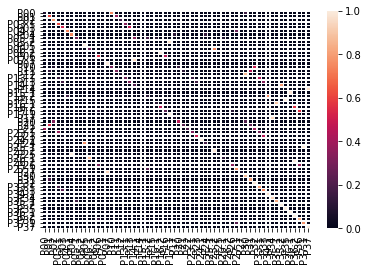

In [17]:

# perform rowwise normalisation on mapping_adj
prop_names = [myP.name for myP in network.memory.Ps]
vis_mappings(mapping_mat=mapping_adj,prop_names=prop_names)
error_val = mapping_error(mapping_mat=mapping_adj)
print(error_val)

In [16]:
baseline_mapping = np.ones((mapping_adj.shape))
baseline_mapping[:,:] = 1.0/baseline_mapping.shape[0]
print get_metrics(baseline_mapping)

(0.049999999999999836, 0.049999999999999906, 0.04999999999999987)


In [20]:
temp = []
for repetition in range(REPETITIONS):
    temp.append(simulated_data[repetition][0][-1])
temp = np.array(temp)
np.mean(temp)

0.6524243654212254

In [23]:
import pickle
f = open(parameters['results'],"wb")
pickle.dump(simulated_data,f)
f.close()

# Trials
## The kinds of tests that have been done and their results :

1. Keeping the object hanging (no predicate for object) means the RB is not created for the corresponding object. Weird.

1.1 Making the predicate a one-hot semantic perhaps? - Does not work

1.2 Making the predicate an empty semantic? - Does not work

1.3 Making the predicate a one-hot semantic that is orthogonal to other vectors? still noisy

2. Keeping the predicate hanging (no object for predicate)


3. Making the words 1 hot representations of their lexical properties, so here subject nouns, object nouns have a 1 hot rep, verbs, complemnetizer verbs, adjectives - Does MUCH BETTER. Promising results, but why are the mappings not perfect still?

3.1 Increase/decrease eta - nope - only makes existing connections stronger/weaker

3.2 gamma/delta/Hebbbias - (currently 0.3, .1, .5)

3.3 Don't ignore object semantics, and keep asDORA True - works better than 3.0

3.4 Try changing the predicate to the noun and keep the object empty - worked fine

4. Added loss metric. Now retry for all previous analysis - 100 runs

4.1 with one_to_one=True and max_norm=False, asDORA = True, ignore_object_sem = False, RMSE = 0.09

4.2 with one_to_one=True and max_norm=True, asDORA = True, ignore_objetct_sem=False, RMSE = 0.05 (def looks better)

4.3 try to use WordGCN and RMSE = .14

4.4 baseline_mapping RMSE = 0.103 (better than wordGCN :O )

4.5 setting embedding dimension = 5, and testing for simple word2vec model, RMSE = 0.12 (still worse than baseline)

5. Understanding object/predicate semantic usage :

5.3 strategic mapping has to be True for asDORA == False ( see do_mapping() )

5.4 Try with new semantic update - previous update was non linear max norm update. New update uses only link weight * parent act - RMSE = 

5.5 Try with new semantic update - added one hot semantic to empty object to distinguish it from other semantics, made sure ignore_object_semantics does not do what it should in the update_semantic code. 
RMSE = 0.098

5.6 Try with making predicate empty rather than object, RMSE = 0.108 :/ 

## Firing order similarity analysis : 

To make mapping more efficient, we have to consider firing order similarity in the mix. To make things easy, we have the firing order of the propositions in the driver. This is given by the ordering of the RBs themselves. 

To downweight/upweight the existing mapping connections, we need to consider the following :

5.1 We consider mappings in RBs and above. Therefore for every RB in the driver, we take a look at the POs that are connected to it in the driver, and the RB it maps to in the recipient, and its POs in the Recipient.

5.2 The mapping connection between RBs is upweighted if the indices of its POs match. Ex - RB1 maps to RB2 with weight w. PO11 and PO12 are the POs connected to RB1, and PO21 and PO22 are the POs connected to RB2. index(PO11), index(PO12), index(PO21), index(PO22) indicate where they appear in the RBs. Spearman Rank correlation between them should point to how similar they are. 

## Stuff to do : 

1. First, collect all mapping hypotheses in one place. This consists of all connections from Driver propositions to all recipient tokens of same type.

1.1 Don't break it now, but the Luce's choice algorithm is a bit weird. Gotta see why they use it. - instead of random threshold to retrieve analogs, use a fixed threshold = 0.1 currently

1.2 with threshold = 0.1, biasing proposition length as well, RMSE = 0.11 - looks bad. Got to find out a way to include RB firing order instead. 

1.3 Make sure P in parent is mapped to P in parent only. 

1.4 After taking out the one to one mapping constraint, mappings improve. - RMSE = 0.0853, set parent_bias = 0.5! 

1.5 setting parent_bias = 0.1 , 0.088 (not significant enough imo)

1.6 see how firing order similarity is affecting mapping coeff. Currently, mapping is in SSL, guided by a simple Hebbian learning rule that has coactivation as its basis. added correlations between activations to update_hyp. Correlations + one_to_one == True, RMSE = 0.067, one_to_one == False, RMSE = 0.077 (higher rmse :O )

1.7 Something to test out - parent and child modes need to be updated based on presence of parentRBs, not activations alons, nah? 

1.8 Run with larger prop number

1.9 Non recursive correlational mapping - 0.111

2.0 Firing by POs, mapping not reset after each run (god knows why that was being done in the first place)

2.1 Why does retrieval by bias_analog work so strangely? 

## Results - 

1.1 Collect RMSE over time, and plot the evolution
1.2 Comparison across word embedding strategies used
1.3 Record RB firing for proposition 0 in Ding stimuli style
